In [1]:
!nvidia-smi

Tue Nov 17 08:06:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   38C    P8    24W / 250W |   6191MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   42C    P0    35W / 250W |   1065MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

First, we grab matplotlib, and set the old "classic" style for some reason only Rui knows.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('classic')

In [3]:
import numpy as np
import torch

These are the local imports. Make sure you import the correct model!

In [4]:
## from model.models import SimpleCNN4Layer_D35_sp as Model
from model.models_mds_F import FourFeature_CNN6Layer_D as Model
##from model.collectdata import collect_data, collect_truth
##from model.collectdata_mdsA import collect_data, collect_truth
from model.collectdata_poca_KDE import collect_data_poca, collect_truth

from model.training import select_gpu
from model.plots_mdsA import plot_ruiplot
from model.efficiency import pv_locations, efficiency
from model.core import modernize

Select a GPU here. Same numbering as the NVidia-SMI tool.

In [5]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


Pick a file to load.

In [7]:
##validation = collect_data('dataAA/20K_POCA_kernel_evts_200926.h5',
validation = collect_data_poca('dataAA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5',
##validation = collect_data_poca('willNewData/Nov3_2020_80k_1.h5',
                          batch_size=1,
                          slice=slice(500),
                          masking=True, shuffle=False,
                          device=device,
                          load_XandXsq=True,
                          load_xy=True)



Loading data...
Loaded dataAA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5 in 0.436 s
Constructing 500 event dataset took 2.436 s


In [8]:
import h5py
##XY_file = 'dataAA/Oct03_20K_val.h5'
##XY_file = 'dataAA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5'
XY_file = 'willNewData/Nov3_2020_80k_1.h5'

with h5py.File(XY_file, mode='r') as XY:
    xmax = np.asarray(XY['Xmax'])
    ymax = np.asarray(XY['Ymax'])

> Note: to get the real PV locations, use `collect_truth('file.h5', pvs=True)` to collect PVs (or SVs with `pvs=False`)

Let's just see how many NaNs we have in the dataset.

In [9]:
print(*np.sum(np.isnan(validation.dataset.tensors[1].cpu().numpy()), 1))

6 6 13 6 24 34 12 24 12 11 24 12 6 6 0 6 0 6 11 0 23 11 6 18 6 6 6 12 12 17 12 6 12 17 17 23 12 0 12 23 24 6 12 34 12 9 24 23 5 0 6 12 6 12 18 30 12 36 18 6 0 16 23 6 18 12 6 18 5 6 24 0 6 23 18 18 0 12 6 35 30 6 12 6 24 6 18 12 12 18 11 6 6 6 18 6 12 24 18 16 6 12 6 0 6 6 24 6 6 29 17 6 29 24 6 23 12 18 0 12 11 11 0 12 7 12 10 6 18 35 36 6 6 6 18 19 6 5 30 18 6 0 23 17 21 18 12 6 17 6 14 17 16 6 24 18 17 6 36 0 6 0 6 12 6 0 0 6 5 12 6 0 24 6 17 18 24 0 6 6 12 6 12 11 0 6 6 12 6 6 0 18 6 11 18 12 6 0 12 6 35 24 12 0 6 12 17 12 12 0 6 6 0 11 6 18 23 20 24 18 46 0 6 12 6 6 6 16 40 6 5 6 5 12 6 18 6 18 17 34 6 6 0 12 10 24 11 23 12 12 0 24 18 29 18 12 18 12 6 26 12 12 12 18 12 5 24 12 6 12 12 6 12 11 12 12 18 17 29 6 18 18 12 12 17 23 0 12 24 18 12 0 17 12 18 18 6 6 28 6 12 6 6 18 6 12 6 12 6 12 6 6 18 6 0 24 36 12 6 12 5 6 12 12 23 0 24 13 11 12 6 6 12 6 11 12 24 35 11 23 6 12 12 18 28 18 6 24 11 12 12 12 11 11 24 12 18 12 6 18 12 29 17 10 12 6 0 24 6 0 12 6 12 12 10 12 0 8 6 30 18 6 0 0

In [10]:
PV = collect_truth('dataAA/Oct03_20K_val.h5', pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

Loaded dataAA/Oct03_20K_val.h5 in 0.03303 s
PV.n.shape =     (20000,)
PV.n[0].shape =  7
PV.x[0] =        0.0067699254 -0.05386329 0.0018882935 -0.035012268 -0.010384369 0.045956675 -0.073287025
PV.y[0] =        0.00076032506 -0.001020242 -0.03236149 0.043514606 -0.08862019 -0.06502226 -0.0052683405
PV.z[0] =        163.4873 80.101074 1.0544614 -36.59213 115.55979 48.95428 126.700806
PV.n[0] =        34 10 4 23 4 29 4
PV.cat[0] =      1 1 0 1 0 1 0


In [11]:
PV.n.max().max()

96

In [12]:
PV.cat[0]

array([1, 1, 0, 1, 0, 1, 0], dtype=int8)

In [13]:
SV = collect_truth('dataAA/Oct03_20K_val.h5', pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])

Loaded dataAA/Oct03_20K_val.h5 in 0.02386 s
SV.n.shape =     (20000,)
SV.n[0].shape =  8
SV.x[0] =        0.010110953 0.0021237247 0.045436032 0.20971942 -0.16212782 0.0306345 -0.036008105 0.023469282
SV.y[0] =        0.004470912 -0.03932457 -0.018049993 -0.007921243 -0.09059714 -0.084428996 0.062232733 -0.017153485
SV.z[0] =        163.6645 150.67242 163.82443 55.91566 223.25316 85.7269 -37.02821 -96.02165
SV.n[0] =        1 0 2 0 0 0 1 0
SV.cat[0] =      0 -1 1 -1 -1 -1 0 -1


Select a model to load. Make sure it matches the model you imported above.

> #### Mike note:
>
> If you use an old-style model, comment out the `d = modernize(d, 3)` line - that converts the old model key names to the new format.

In [14]:
#name = '/share/lazy/schreihf/PvFinder/models/Dec11_SimpleCNN4Layer_D35_sp_first200epochs_240K_lr_3em5_bs512_Alt_Loss_A_4p5_final.pyt'
##name = '/home/sokoloff/pv-finder/notebooks/Dec21_SimpleCNN4Layer_D35_sp_yetAnother200epochs_240K_lr_1em3_bs512_Alt_Loss_A_4p5/Dec21_SimpleCNN4Layer_D35_sp_yetAnother200epochs_240K_lr_1em3_bs512_Alt_Loss_A_4p5_final.pyt'
##name = '/home/sokoloff/pv-finder/notebooks/Dec21_SimpleCNN4Layer_D35_sp_yetAnother600epochs_240K_lr_3em4_bs512_Alt_Loss_A_4p5/Dec21_SimpleCNN4Layer_D35_sp_yetAnother600epochs_240K_lr_3em4_bs512_Alt_Loss_A_4p5_final.pyt'
name = 'ML/Aug10_FourFeature_CNN6LayerPlus_TargetsA_First20epochs_160K_lr_1em3_bs64_Alt_Loss_A_3p0/Aug10_FourFeature_CNN6LayerPlus_TargetsA_First20epochs_160K_lr_1em3_bs64_Alt_Loss_A_3p0_final.pyt'
name = 'ML/Aug11_FourFeature_CNN6LayerPlus_TargetsAA_First40epochs_fixedPert_160K_lr_1em3_bs64_Alt_Loss_A_3p0/Aug11_FourFeature_CNN6LayerPlus_TargetsAA_First40epochs_fixedPert__160K_lr_1em3_bs64_Alt_Loss_A_3p0_final.pyt'
name = 'ML/Aug14_FourFeature_CNN6LayerPlus_TargetsAA_400epochs_160K_lr_3em4_bs64_Alt_Loss_A_3p0/Aug14_FourFeature_CNN6LayerPlus_TargetsAA_400epochs_160K_lr_3em4_bs64_Alt_Loss_A_3p0_399.pyt'
name = 'ML/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5_final.pyt'
model = Model().to(device)
d = torch.load(name)
d = modernize(d, 3) # Only use if using the new Model definitions (should be safe if not, but unneccisary)
model.load_state_dict(d)
model.eval()

FourFeature_CNN6Layer_D(
  (conv1): Conv1d(2, 25, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4of6): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5of6): Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 10, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(10, 5, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (ppFc1): Linear(in_features=4000, out_features=4000, bias=True)
  (ppFinalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropou

Let's grab the outputs and labels as normal numpy arrays.

In [15]:
##%%time
with torch.no_grad():
    outputs = model(validation.dataset.tensors[0]).cpu().numpy()
    labels = validation.dataset.tensors[1].cpu().numpy()
## mds    print('outputs = ', outputs)
## mds    print('labels = ',labels)

## mds    print('outputs again = ', outputs)

And here's Rui's plotting code.

In [16]:
test = validation.dataset.tensors[0].cpu().numpy()
print('test.shape = ',test.shape)

test.shape =  (500, 4, 4000)



Event 0: Found 6 of 7, added 0 (eff 85.71%)

Event 0.0:


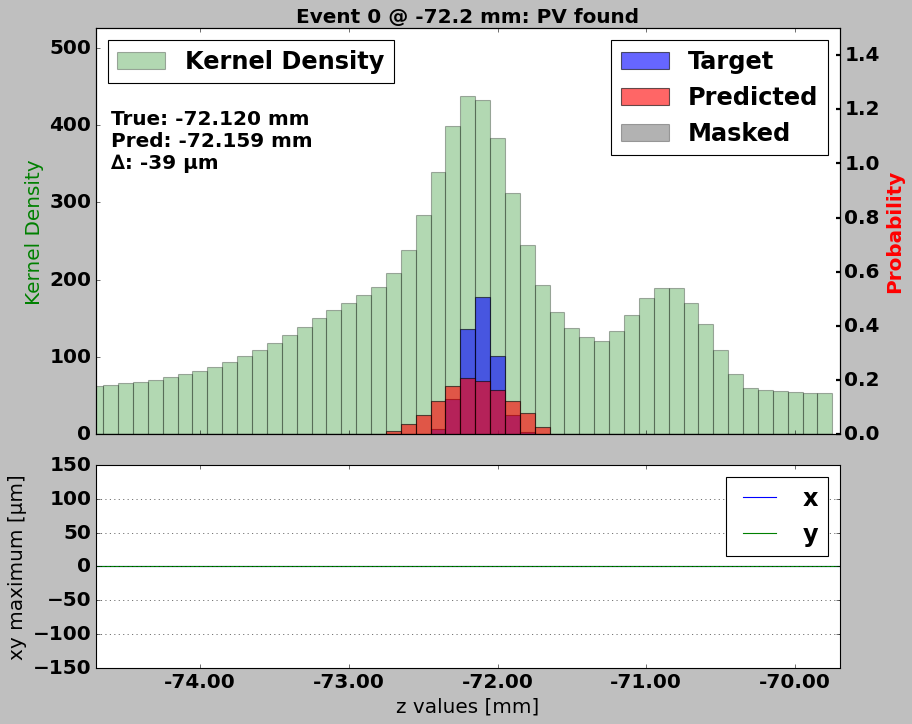


Event 0.1:


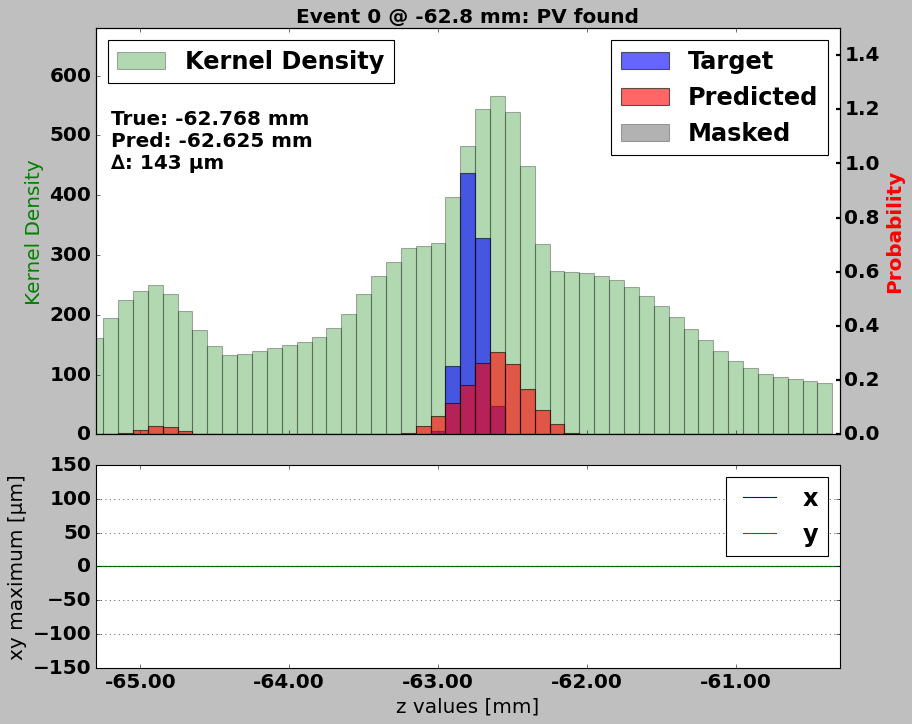


Event 0.2:

PV: 23 tracks (type 1)
  x:   -35 μm
  y:    44 μm
  z:  -36.592 mm

SV: 1 tracks (type 0)
  x:   -36 μm
  y:    62 μm
  z:  -37.028 mm


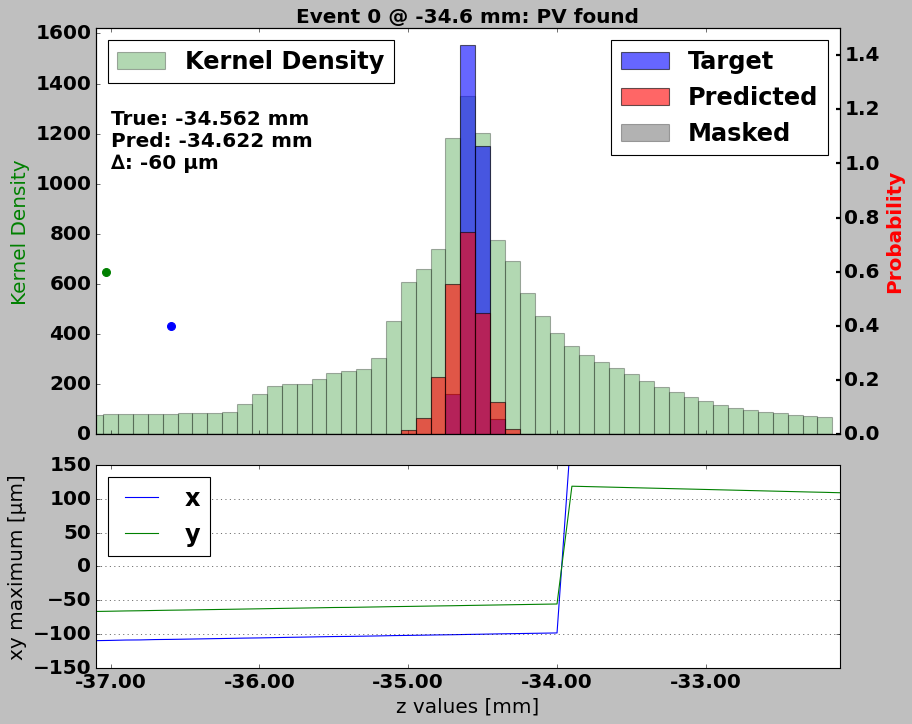


Event 0.3:


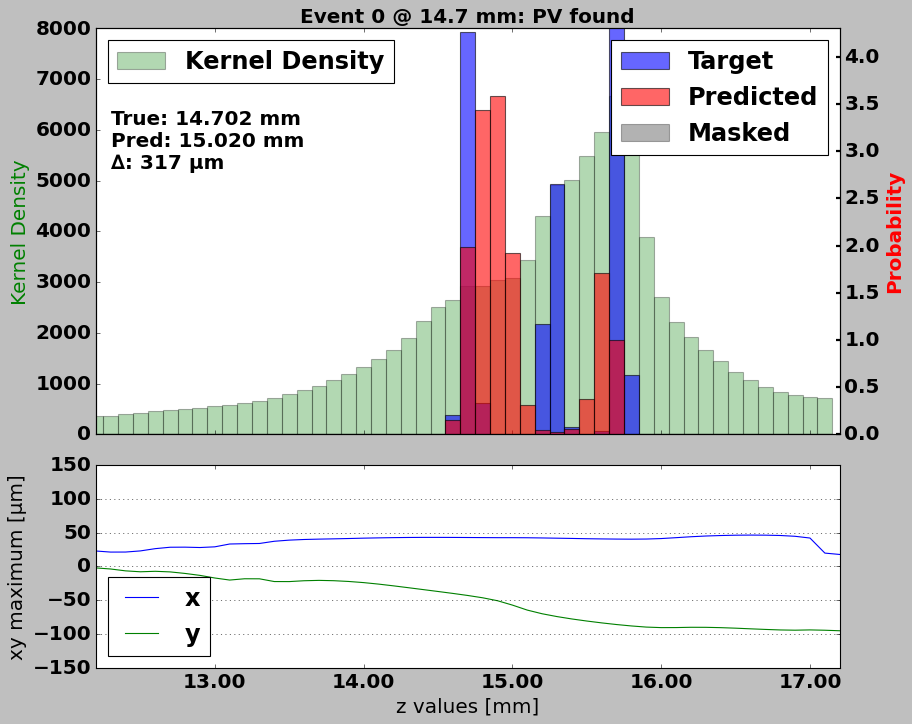


Event 0.4:


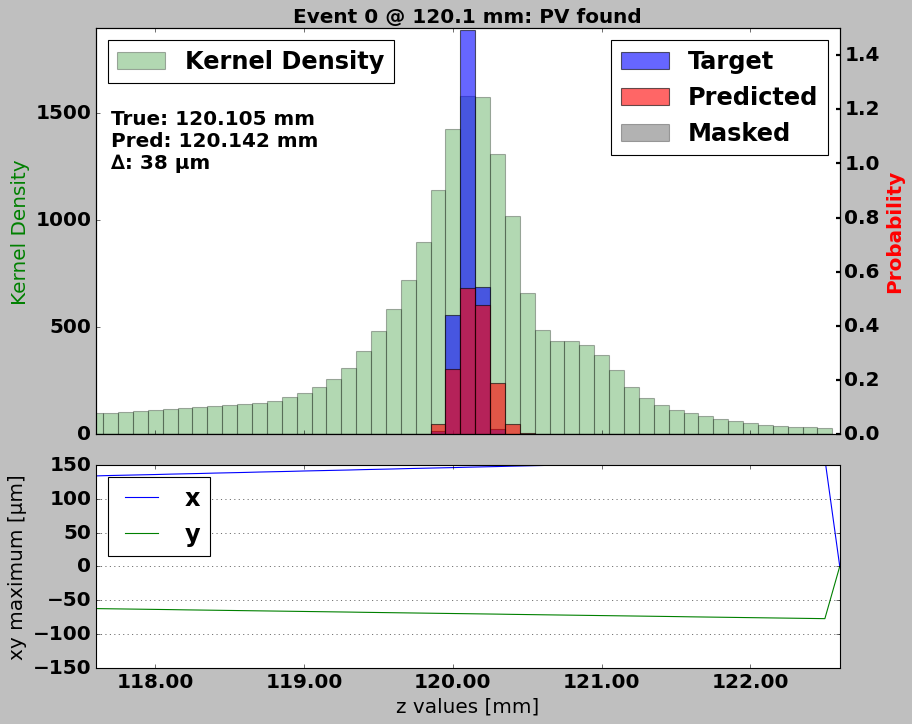


Event 1: Found 8 of 8, added 0 (eff 100.00%)

Event 1.0:


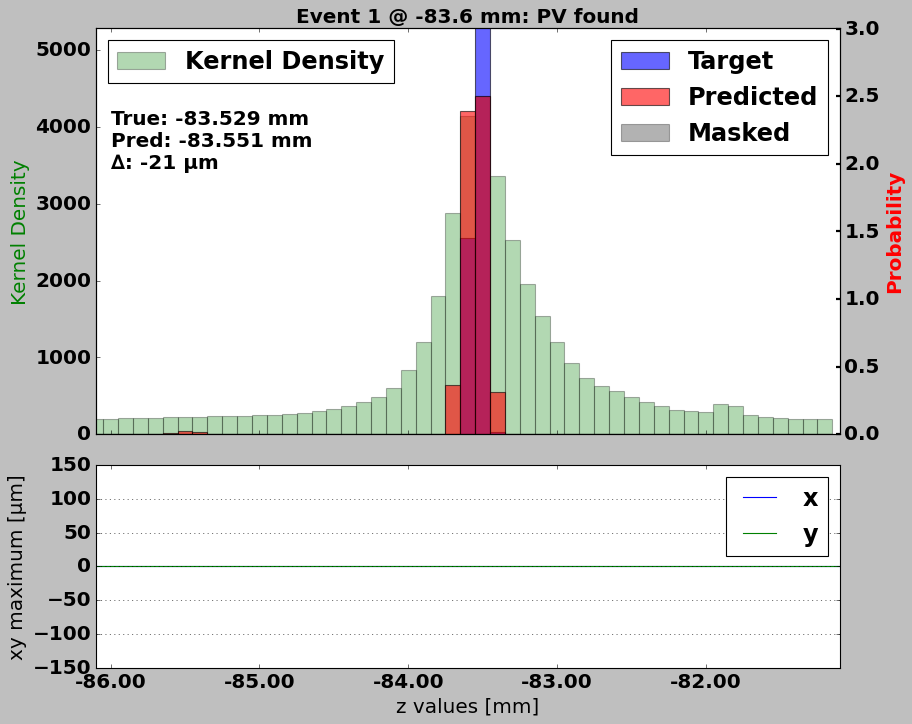


Event 1.1:


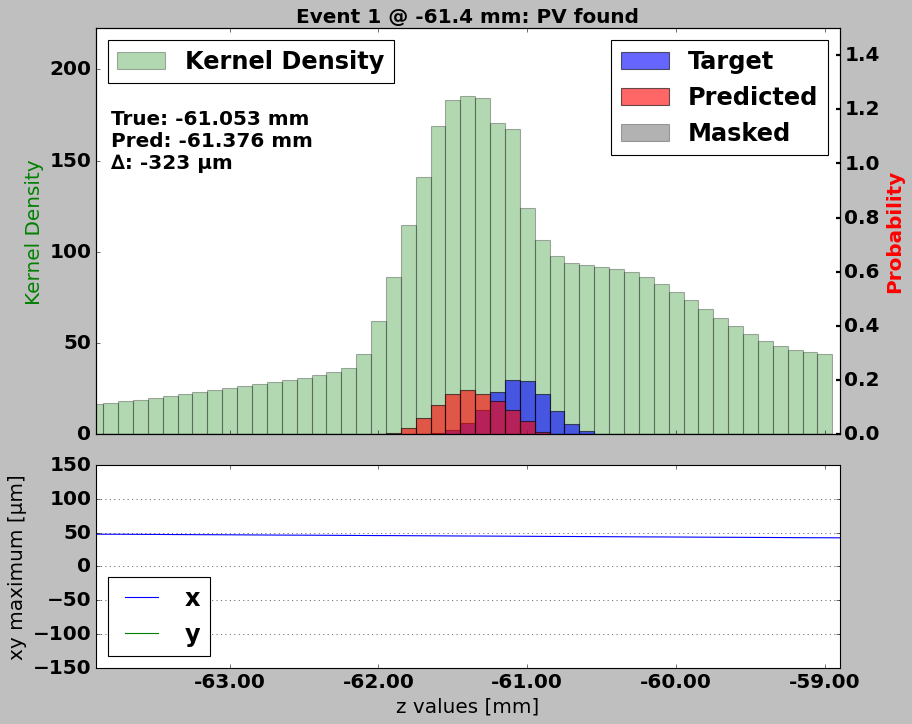


Event 1.2:


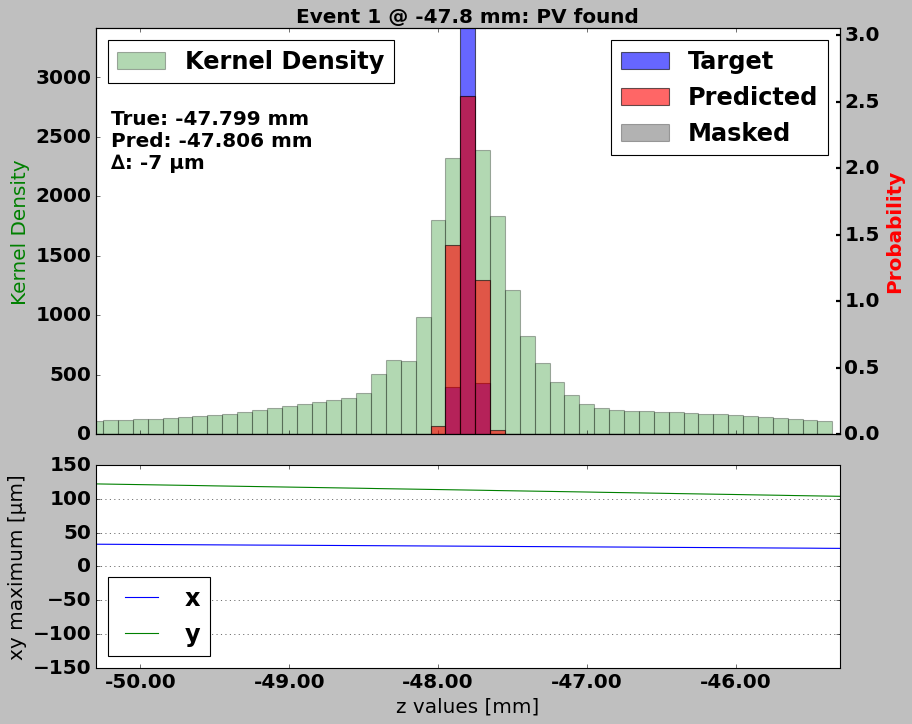


Event 1.3:


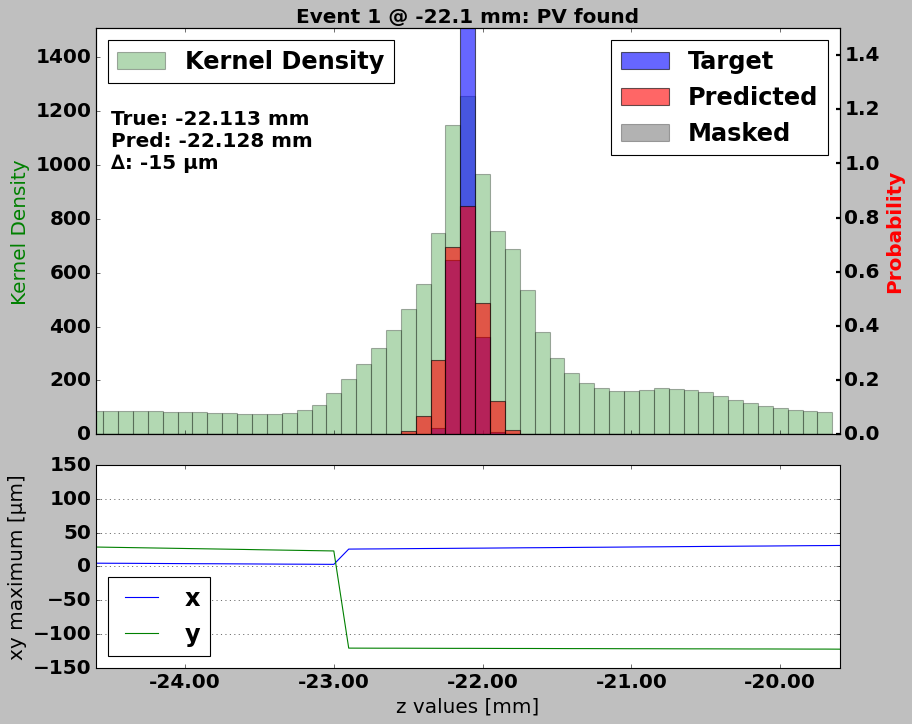


Event 1.4:


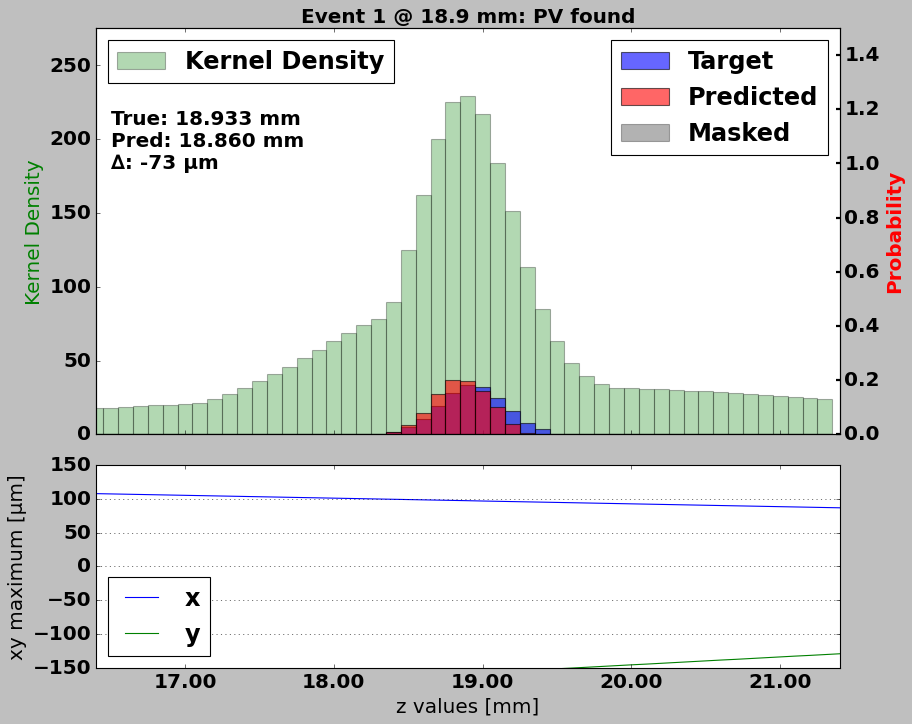


Event 1.5:


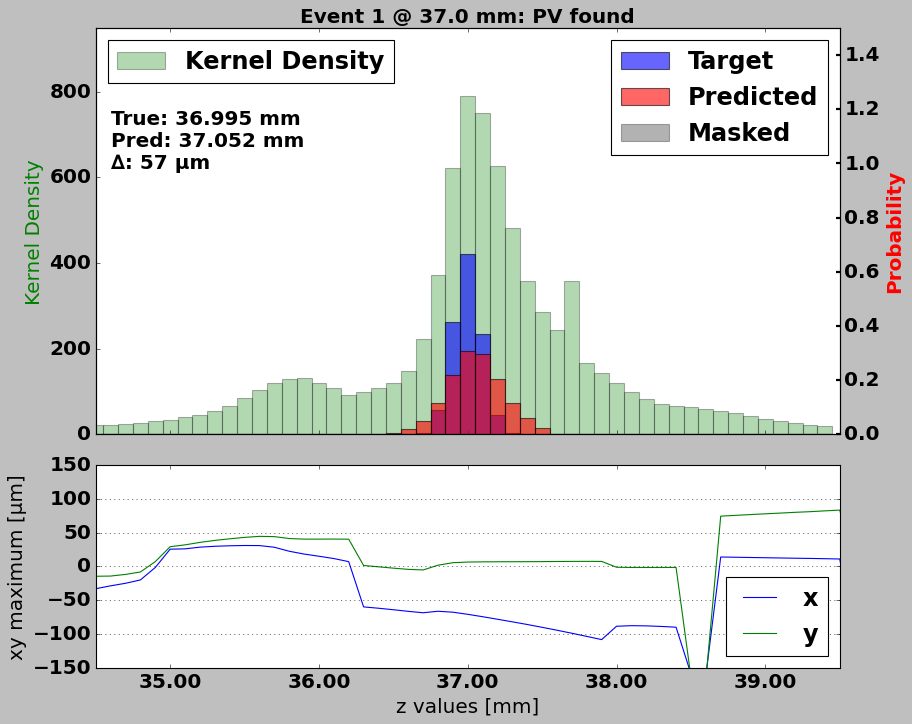


Event 1.6:


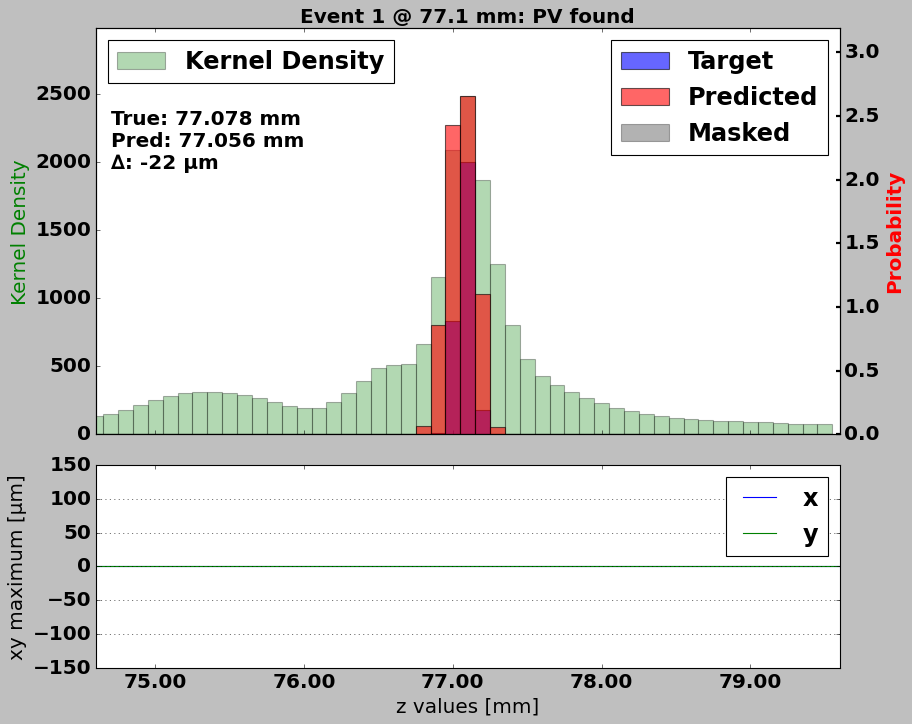


Event 1.7:


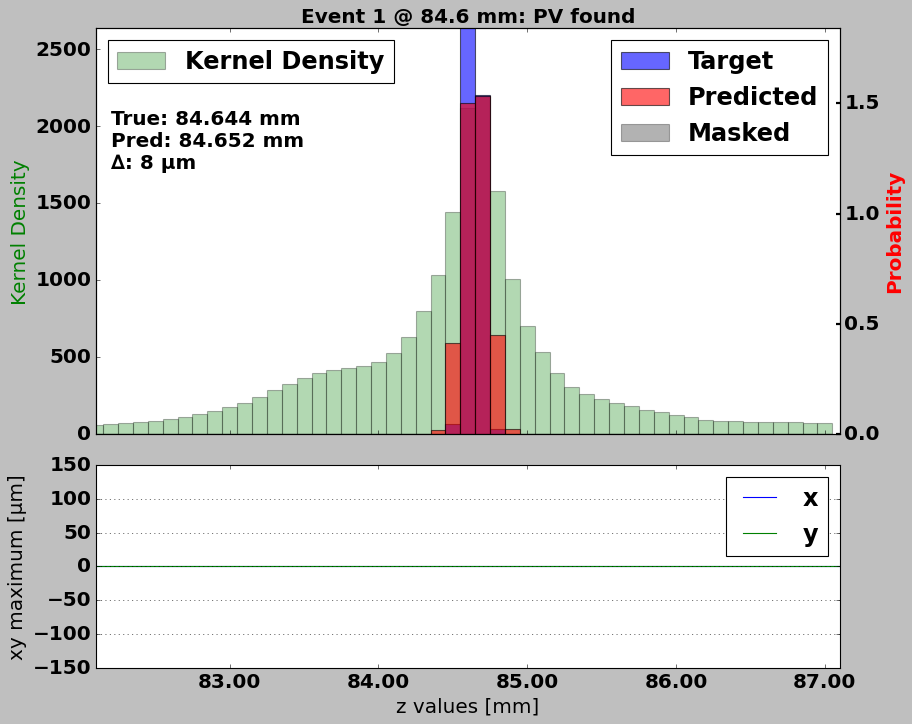


Event 2: Found 5 of 5, added 0 (eff 100.00%)

Event 2.0:


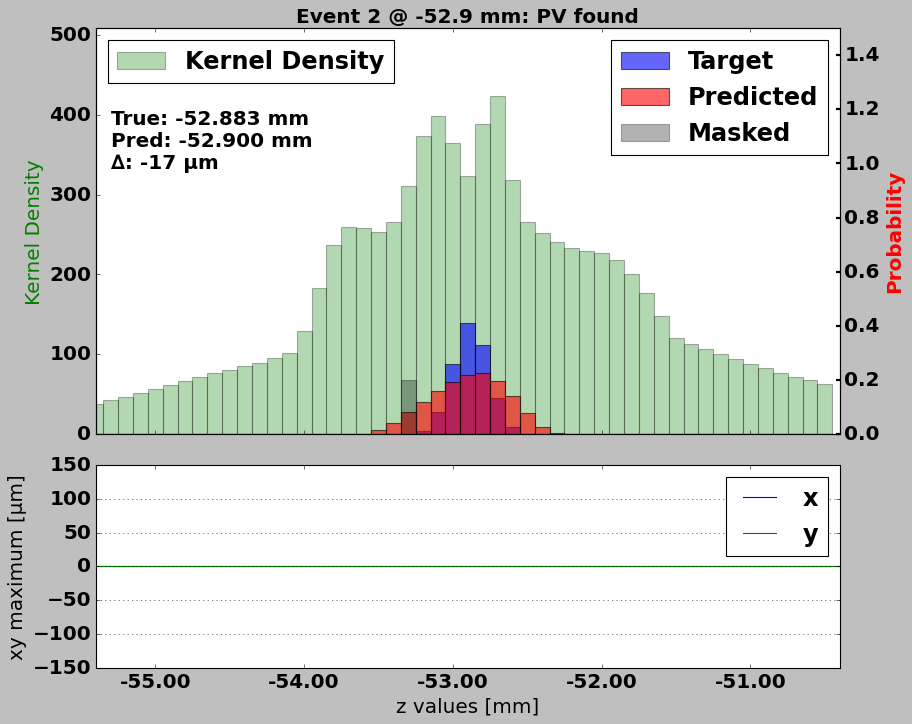


Event 2.1:


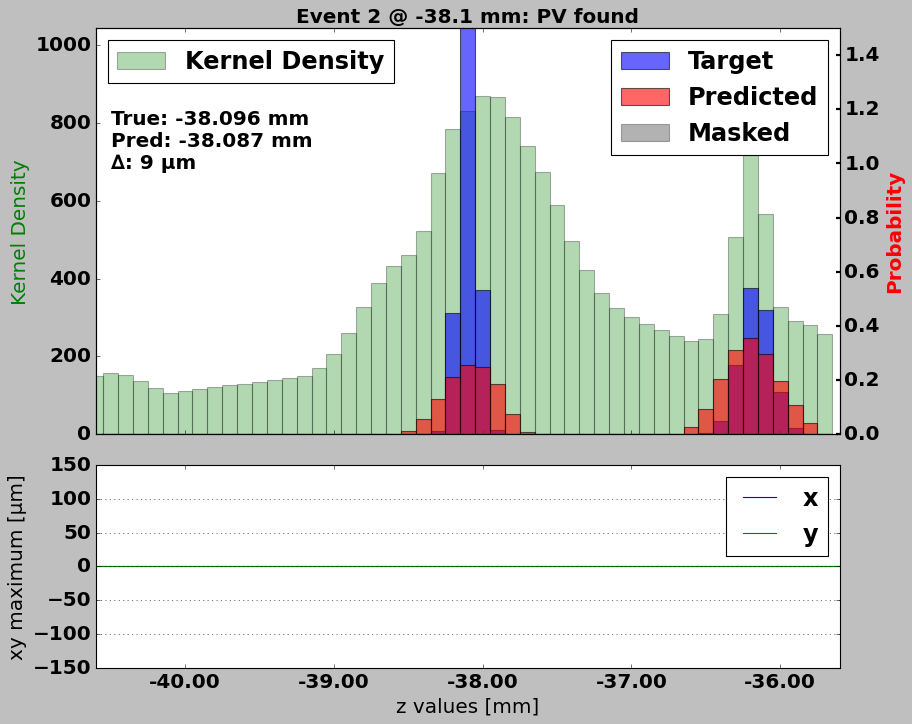


Event 2.2:


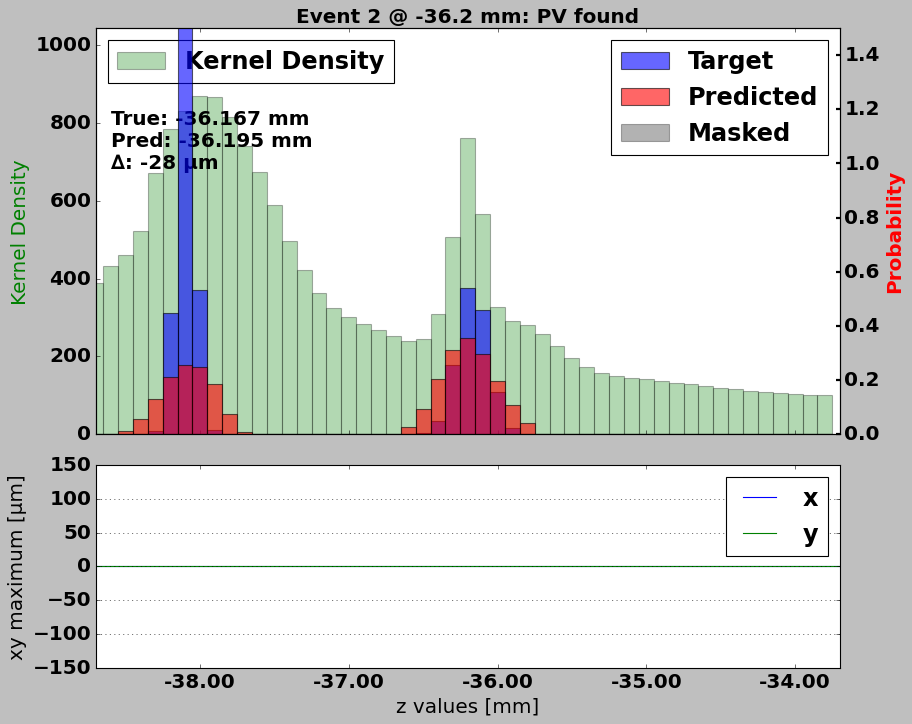


Event 2.3:


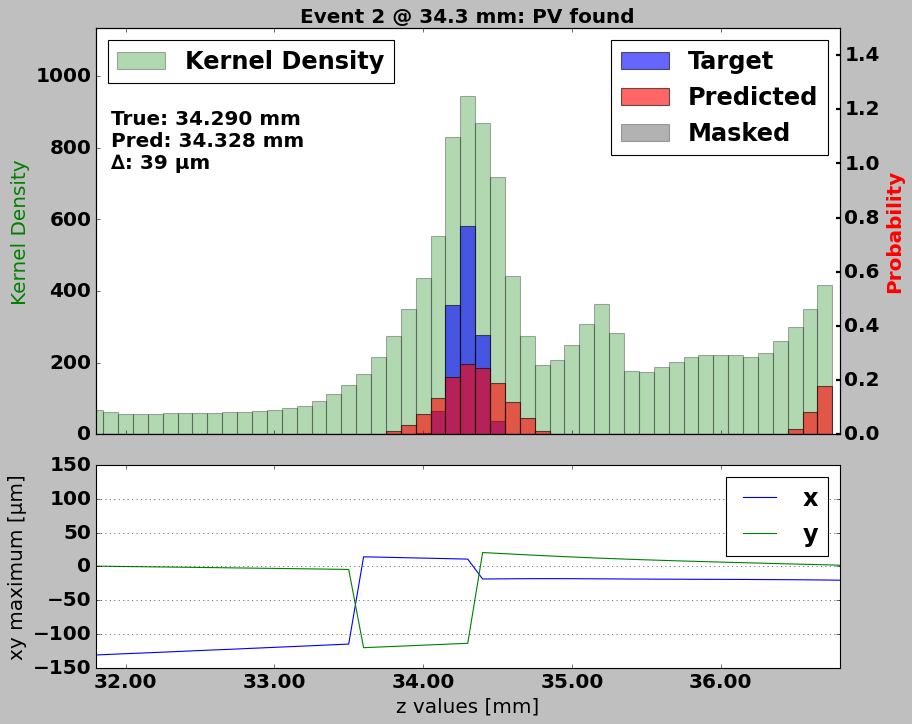


Event 2.4:


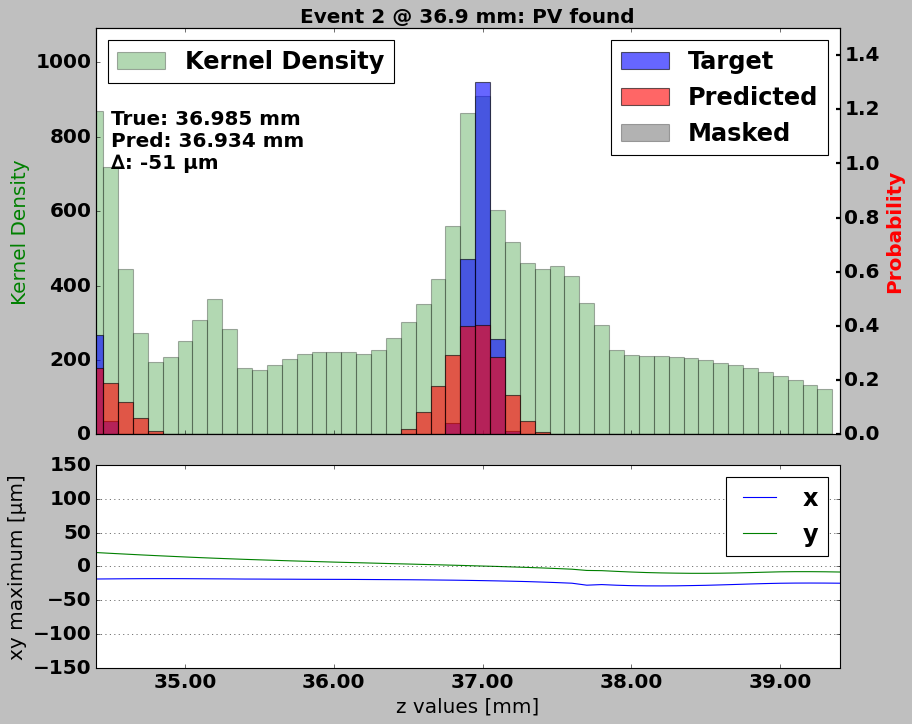


Event 3: Found 2 of 2, added 0 (eff 100.00%)

Event 3.0:


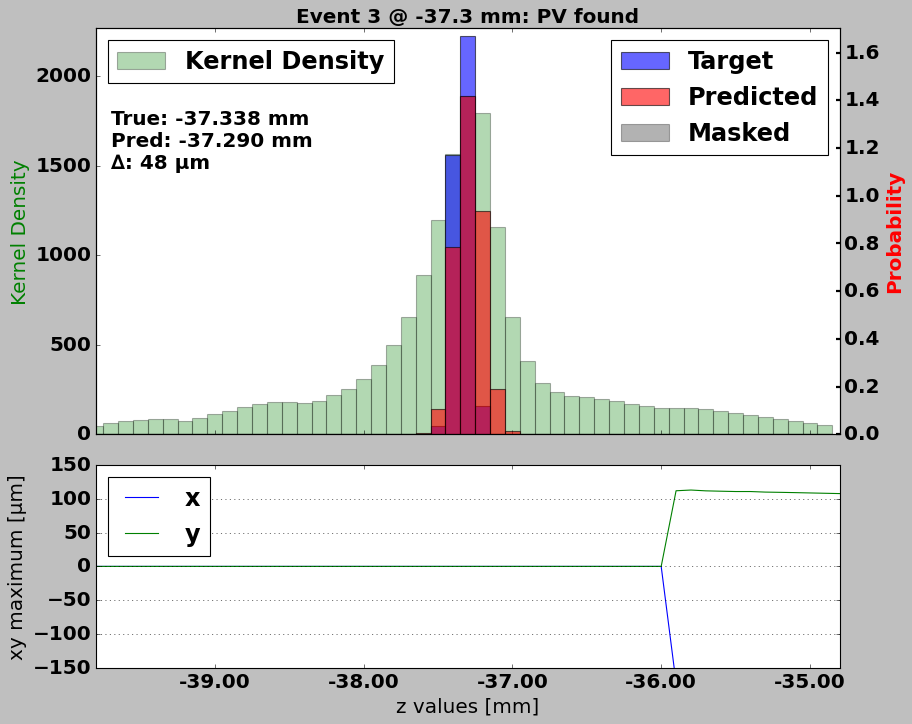


Event 3.1:


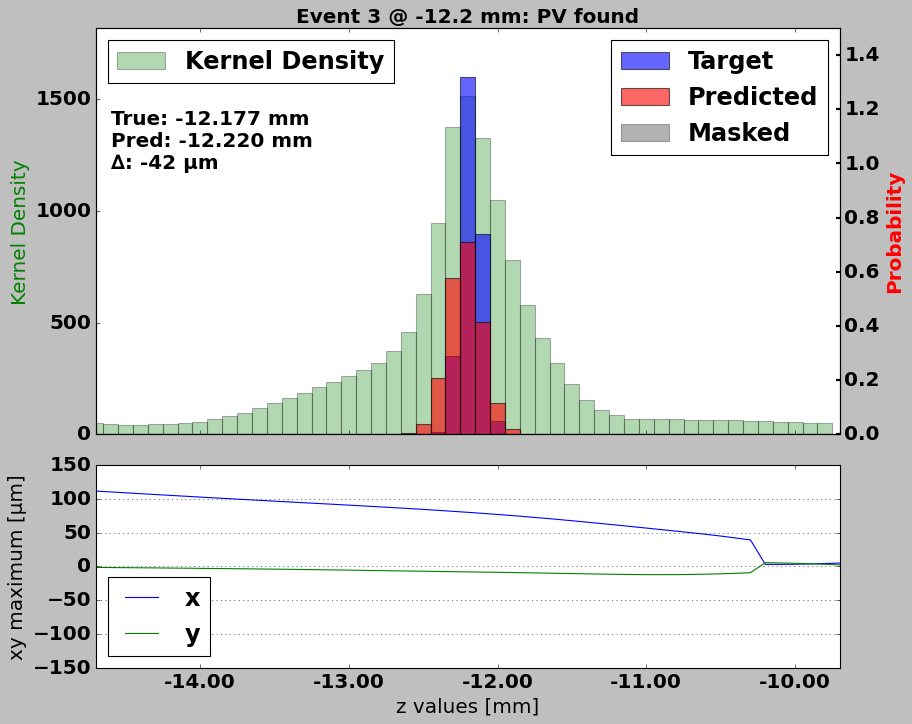


Event 4: Found 4 of 6, added 0 (eff 66.67%)

Event 4.0:


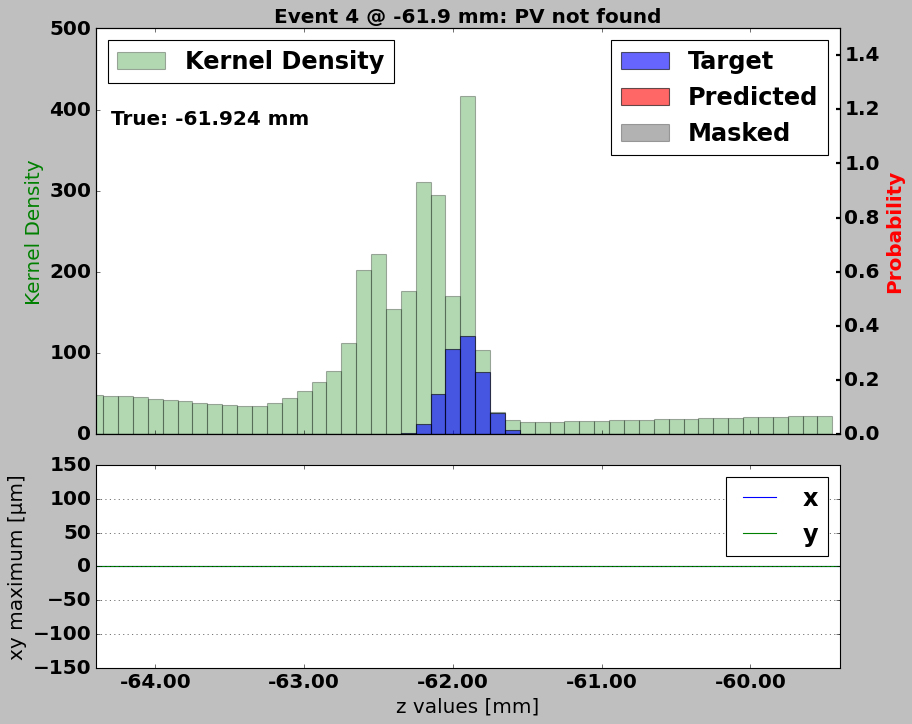


Event 4.1:


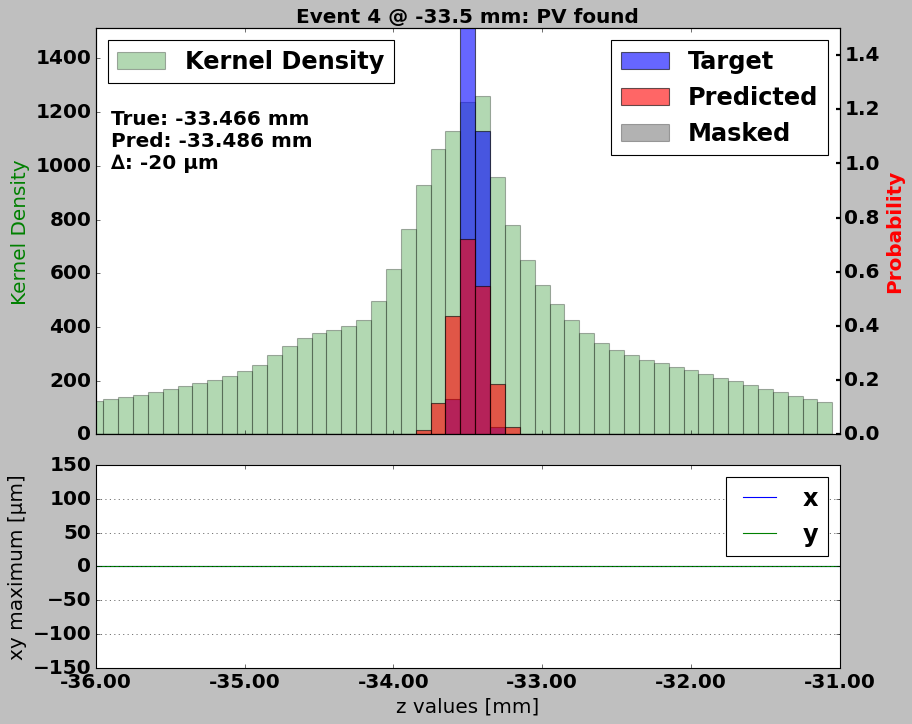


Event 4.2:


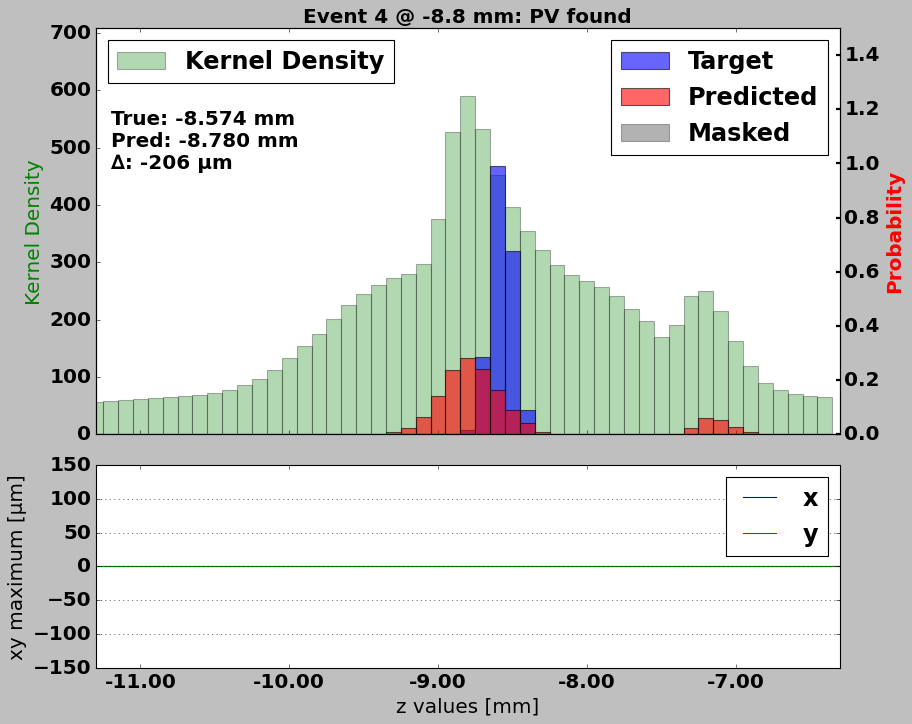


Event 4.3:

PV: 4 tracks (type 0)
  x:    64 μm
  y:   -87 μm
  z:   30.809 mm


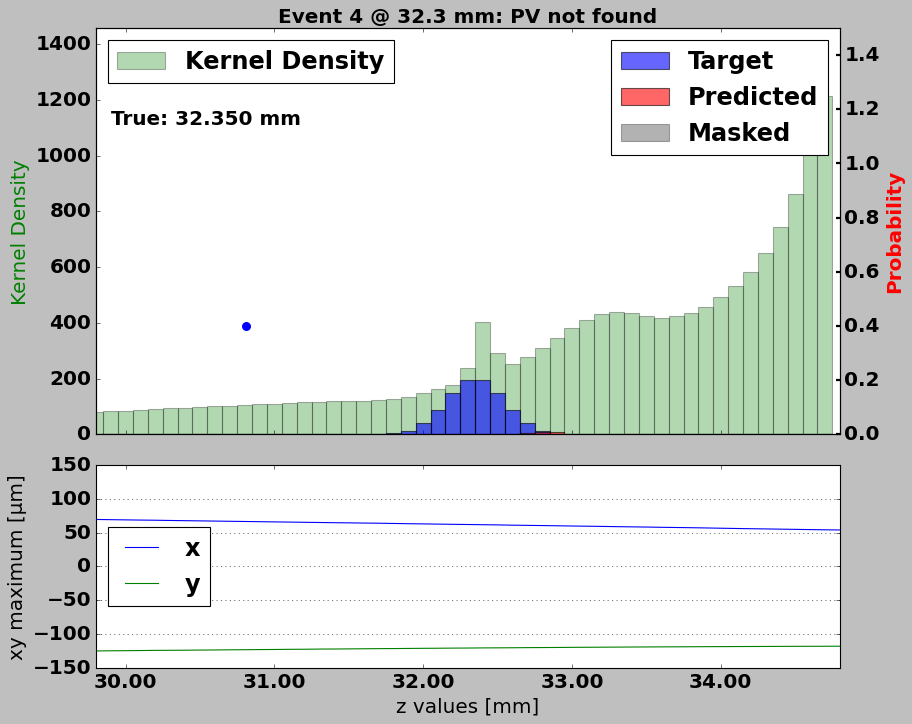


Event 4.4:


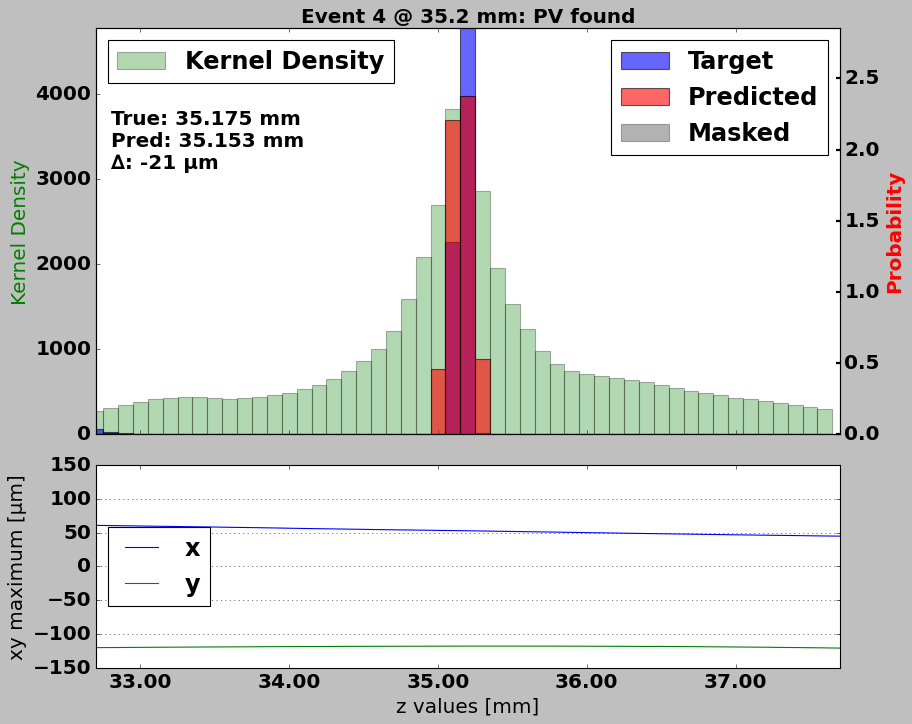


Event 4.5:


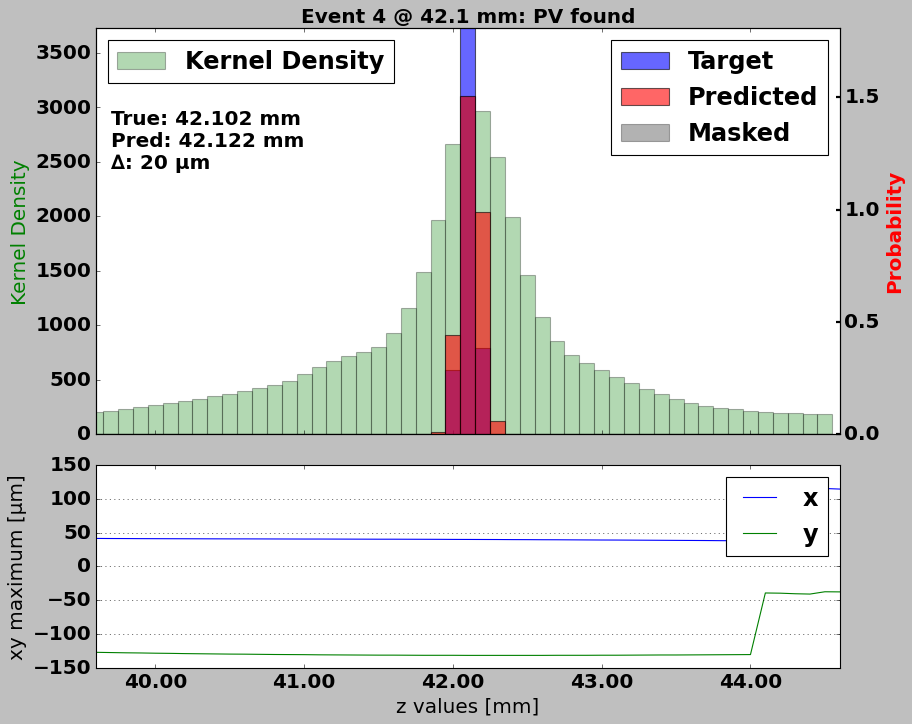


Event 5: Found 9 of 9, added 1 (eff 100.00%)

Event 5.0:


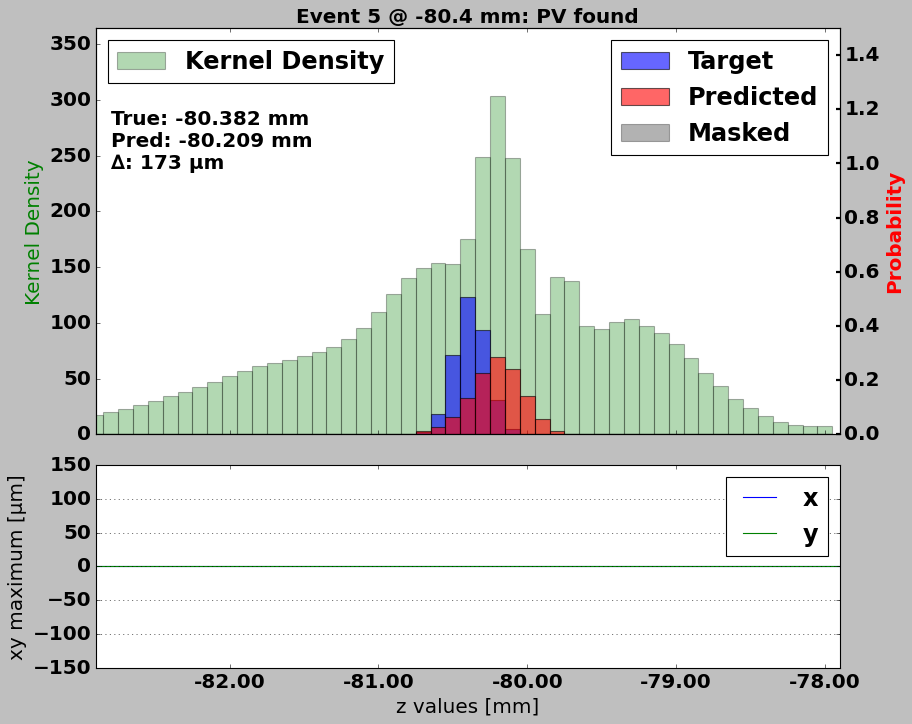


Event 5.1:


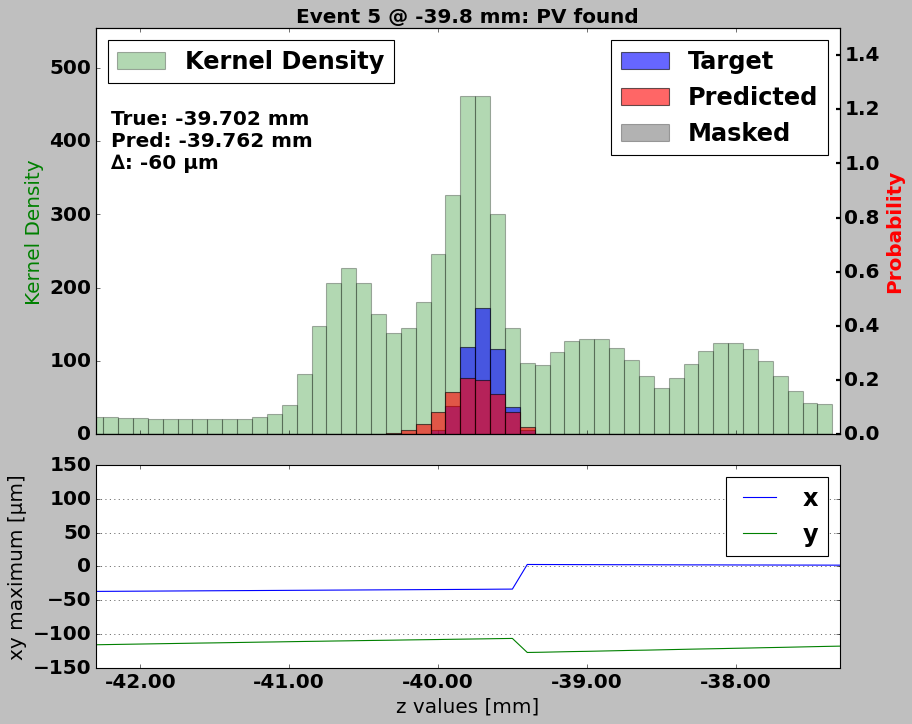


Event 5.2:

PV: 0 tracks (type 0)
  x:   -71 μm
  y:   -50 μm
  z:   19.114 mm

PV: 10 tracks (type 1)
  x:   -10 μm
  y:    29 μm
  z:   19.062 mm

SV: 2 tracks (type 1)
  x:  -291 μm
  y:   -11 μm
  z:   17.677 mm

SV: 2 tracks (type 1)
  x:    -1 μm
  y:    17 μm
  z:   18.915 mm


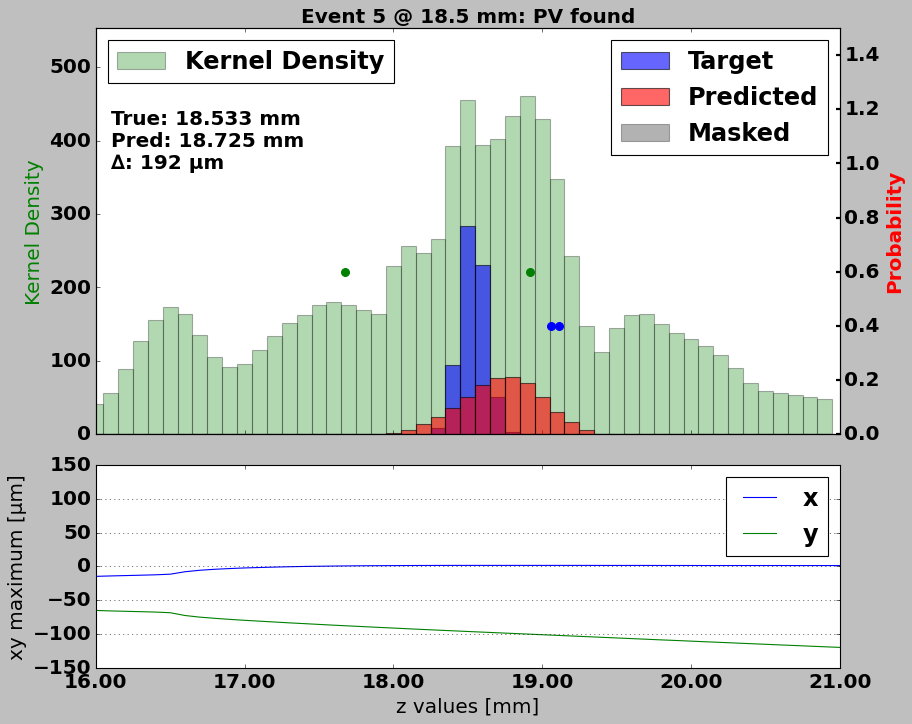


Event 5.3:


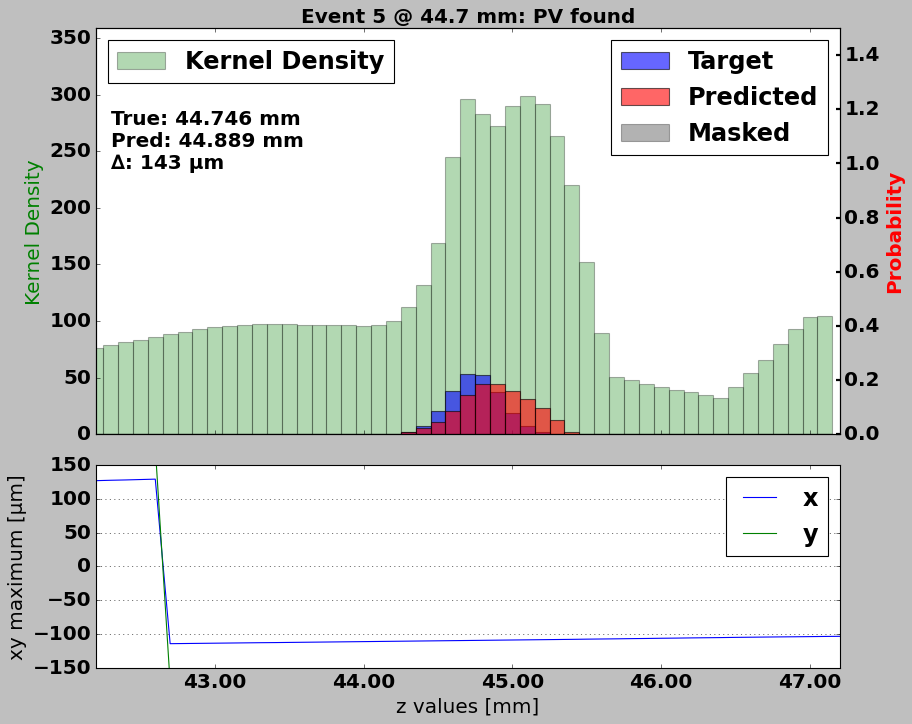


Event 5.4:


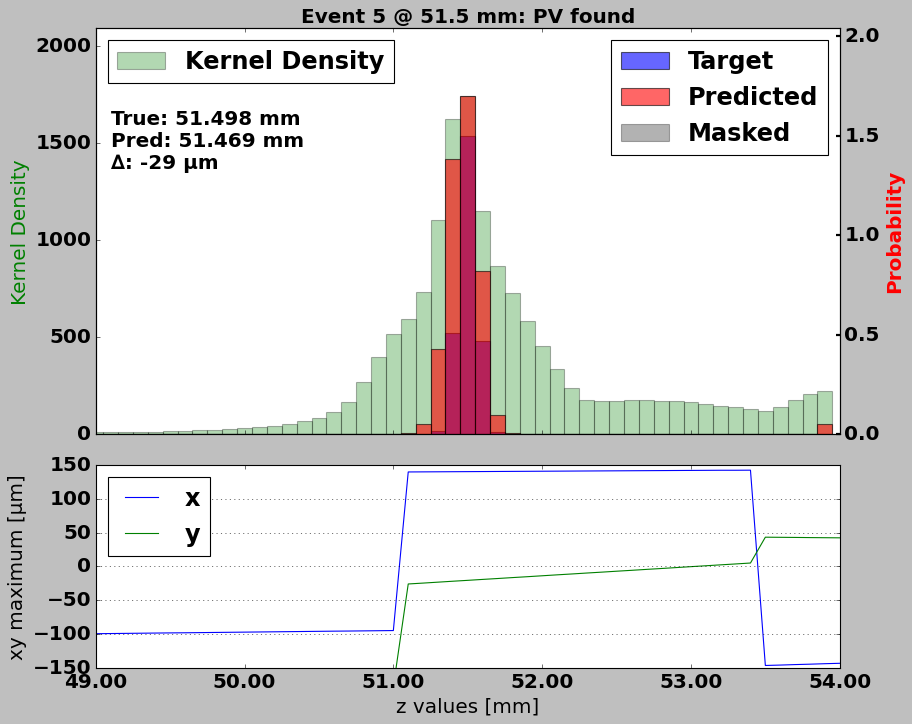


Event 5.5:


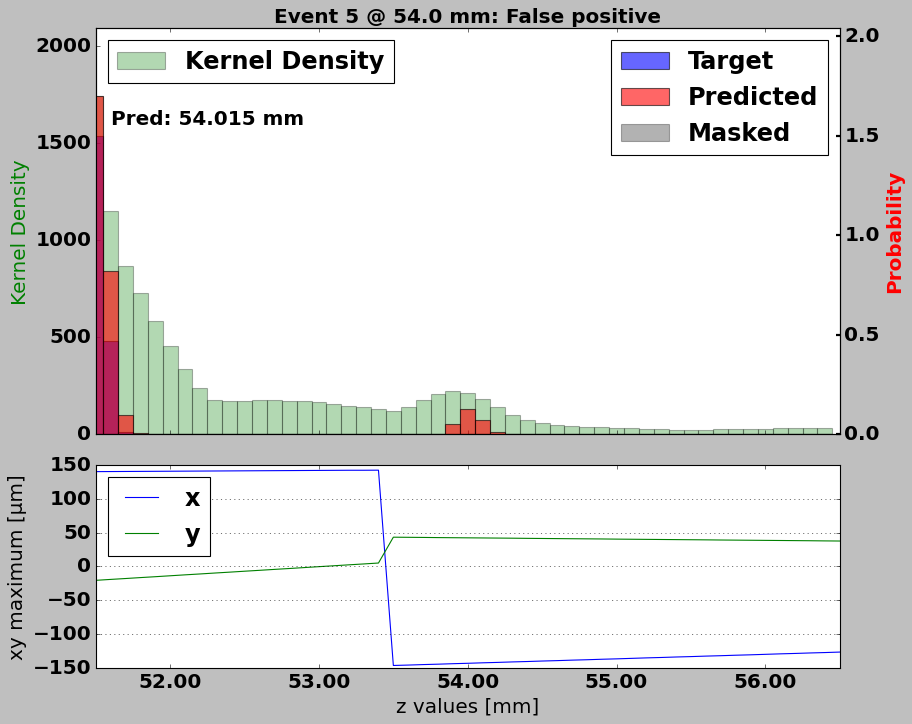


Event 5.6:


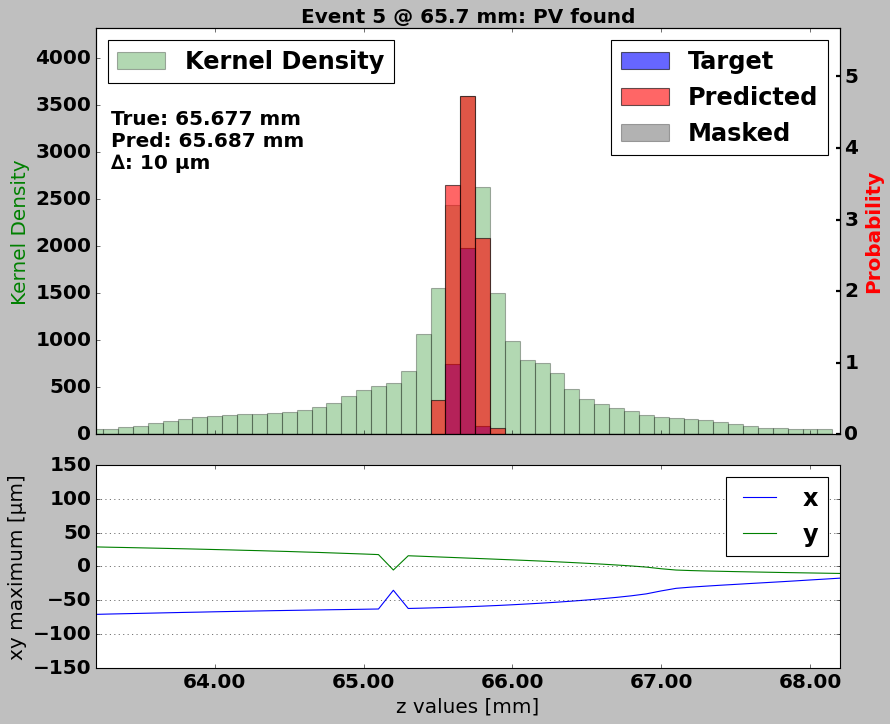


Event 5.7:

PV: 9 tracks (type 1)
  x:    68 μm
  y:    -7 μm
  z:   75.642 mm

PV: 0 tracks (type -1)
  x:    35 μm
  y:    47 μm
  z:   75.505 mm


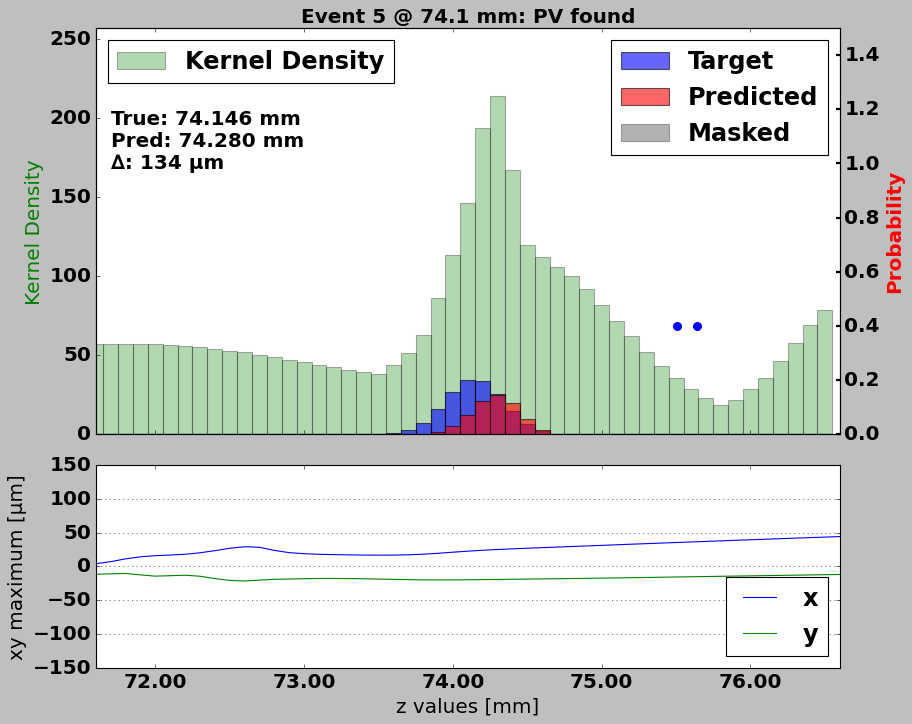


Event 5.8:


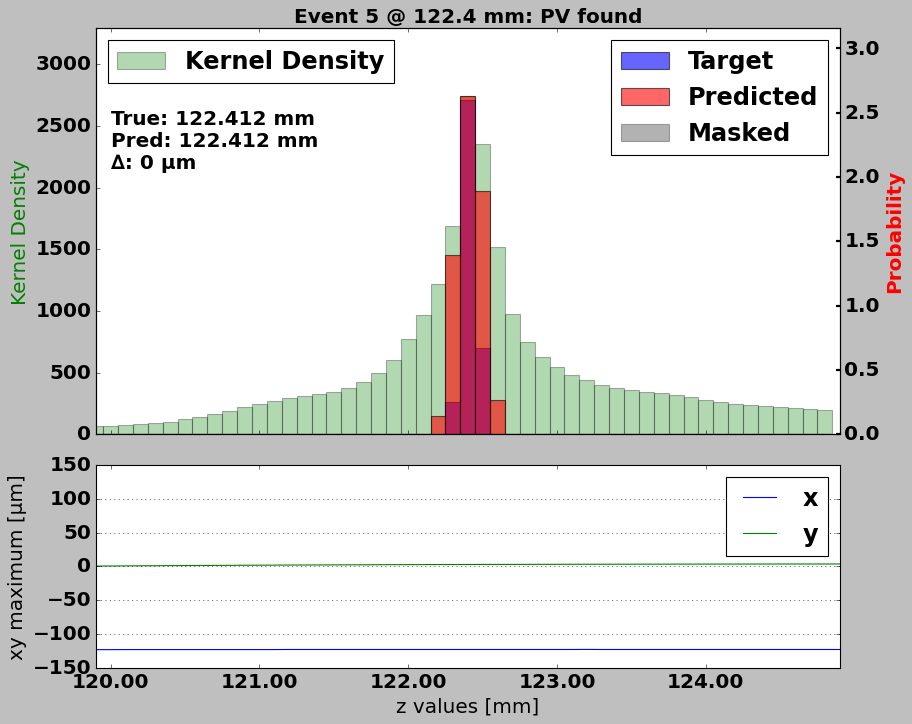


Event 5.9:


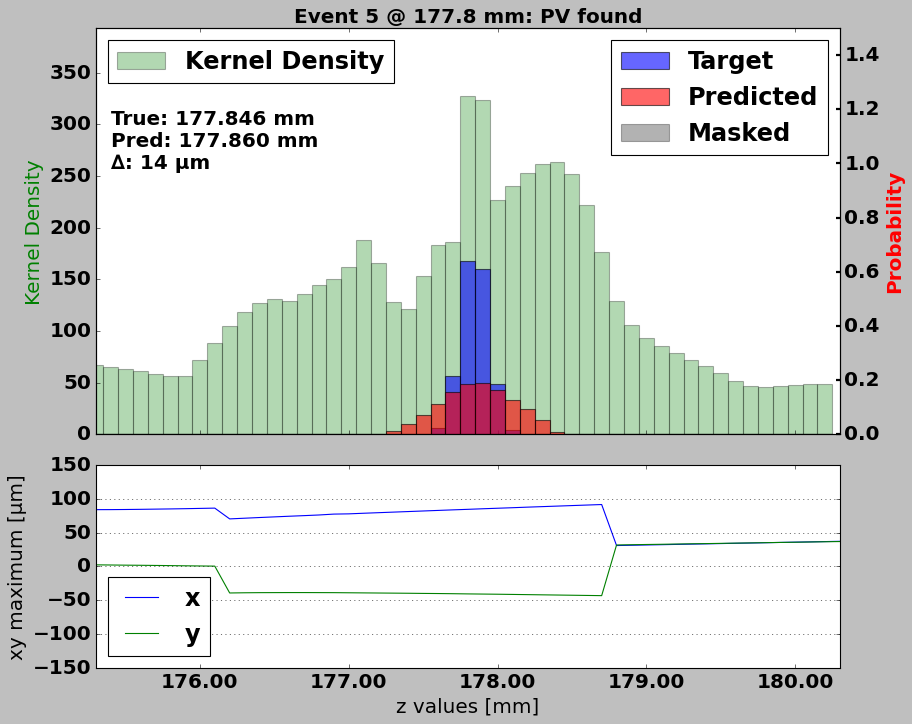


Event 6: Found 7 of 7, added 0 (eff 100.00%)

Event 6.0:


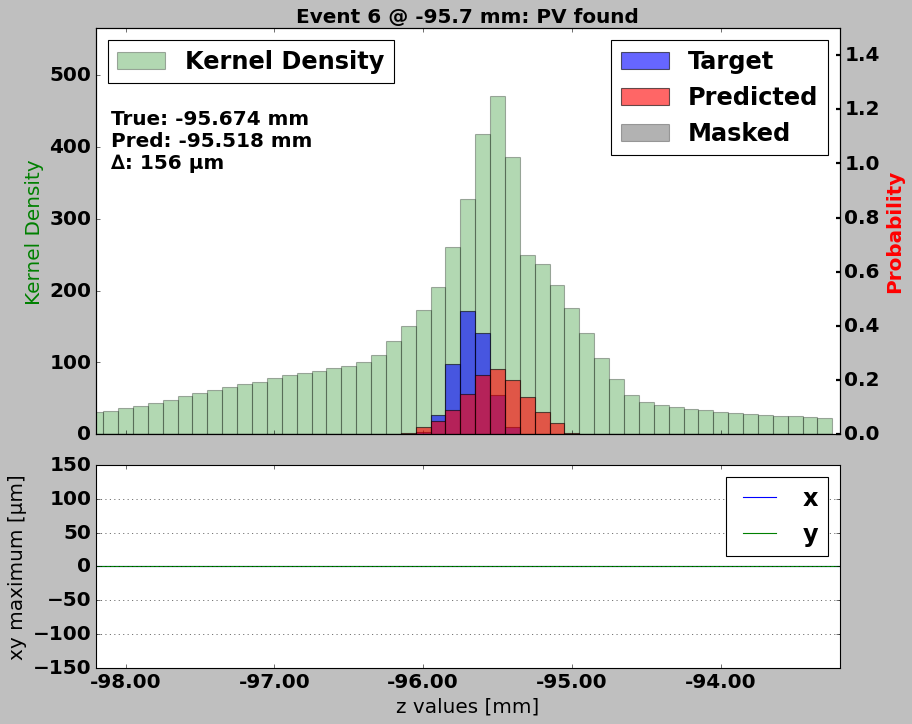


Event 6.1:


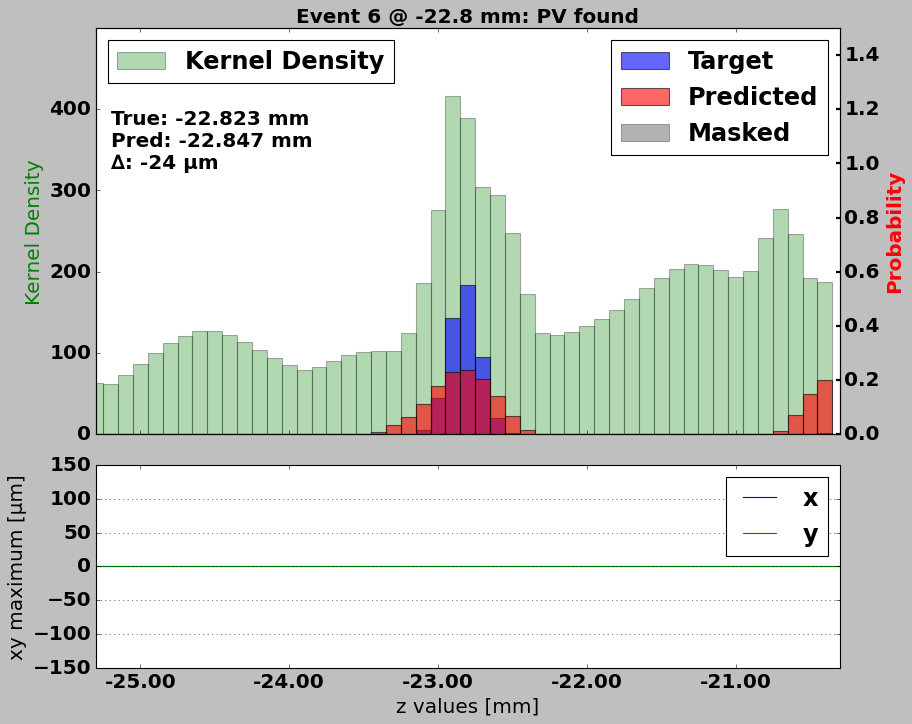


Event 6.2:


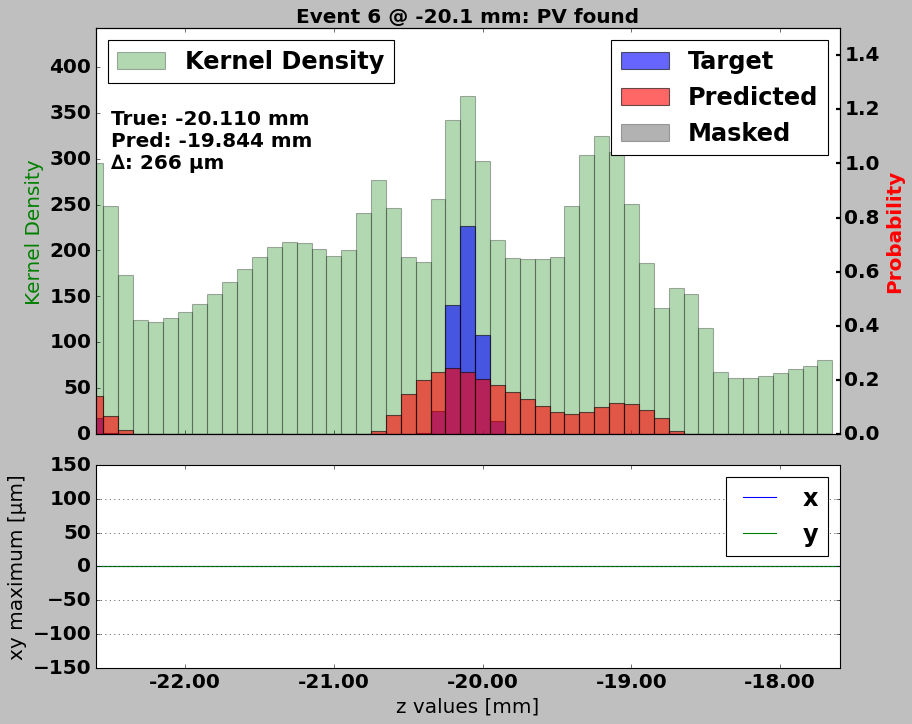


Event 6.3:


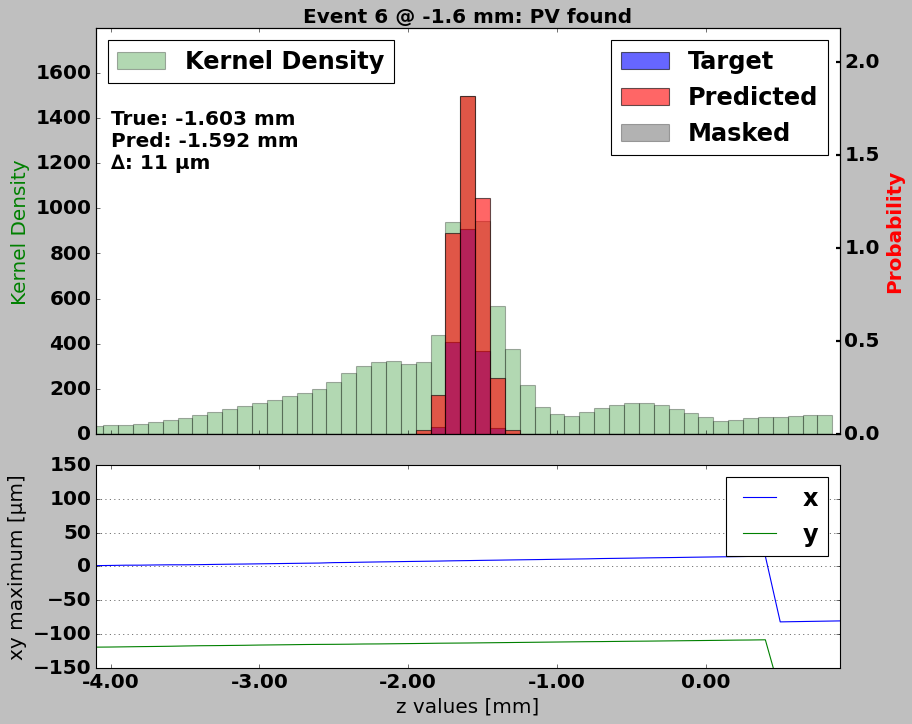


Event 6.4:


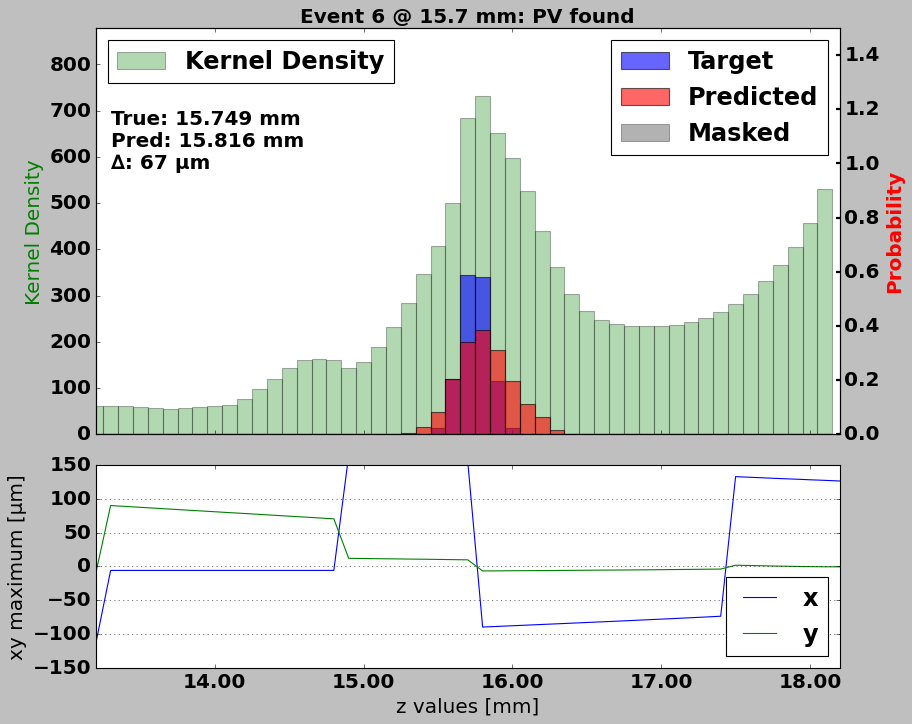


Event 6.5:


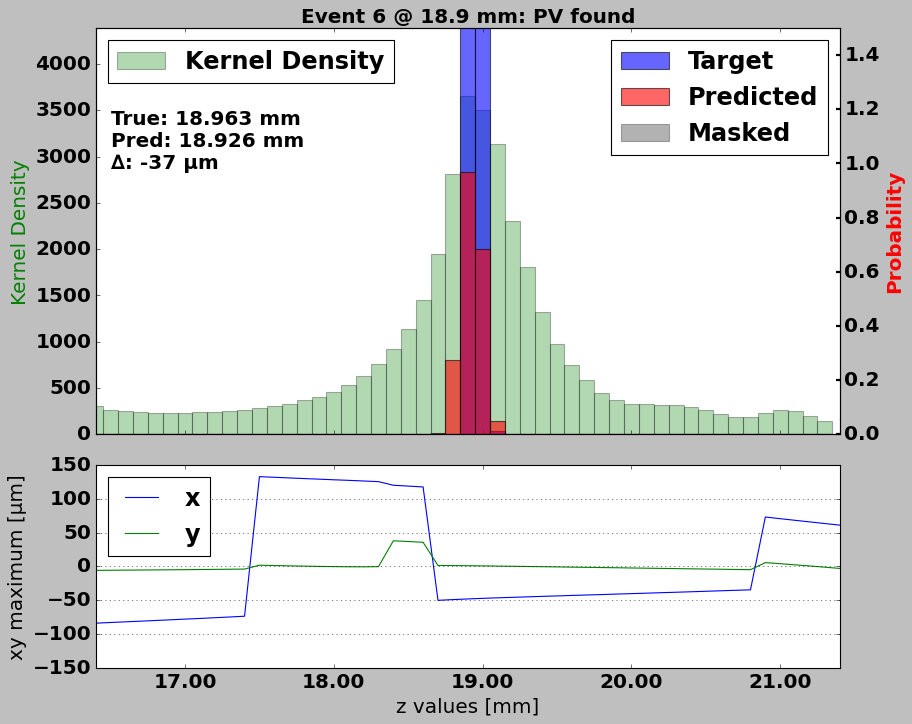


Event 6.6:


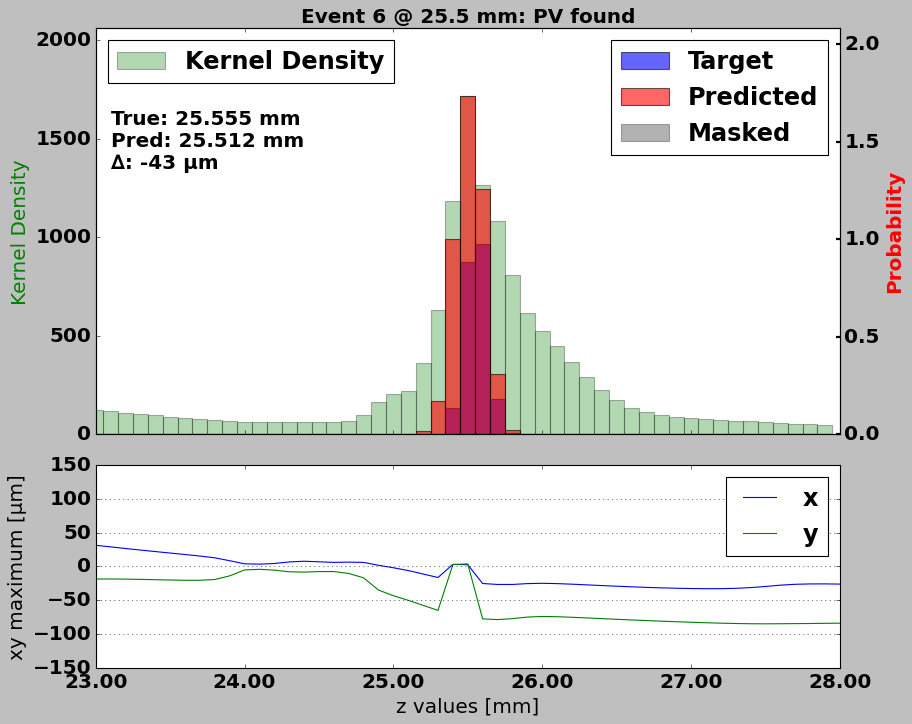


Event 7: Found 8 of 8, added 0 (eff 100.00%)

Event 7.0:


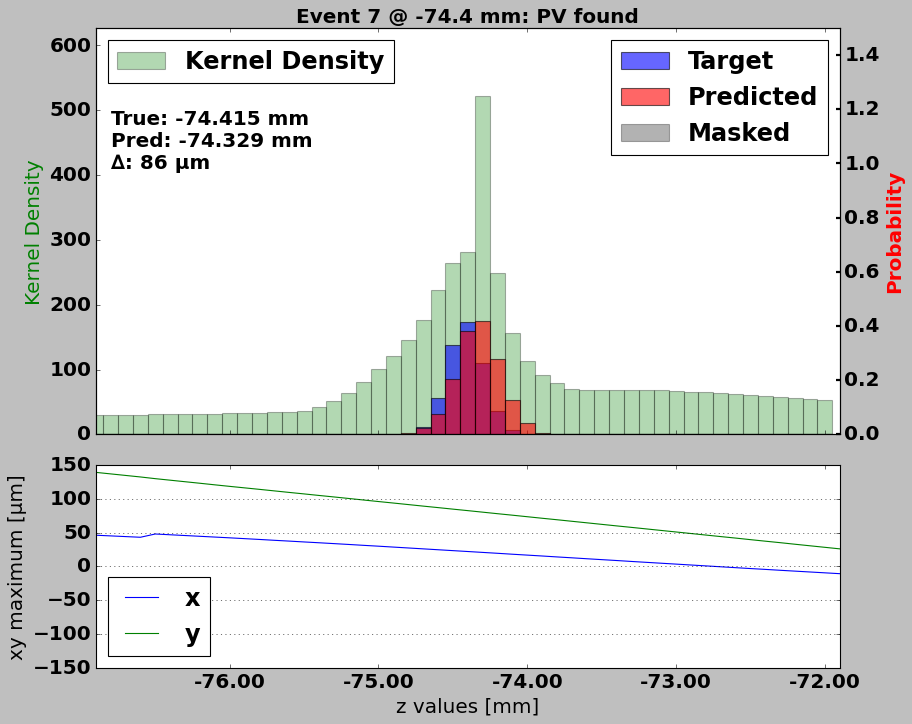


Event 7.1:


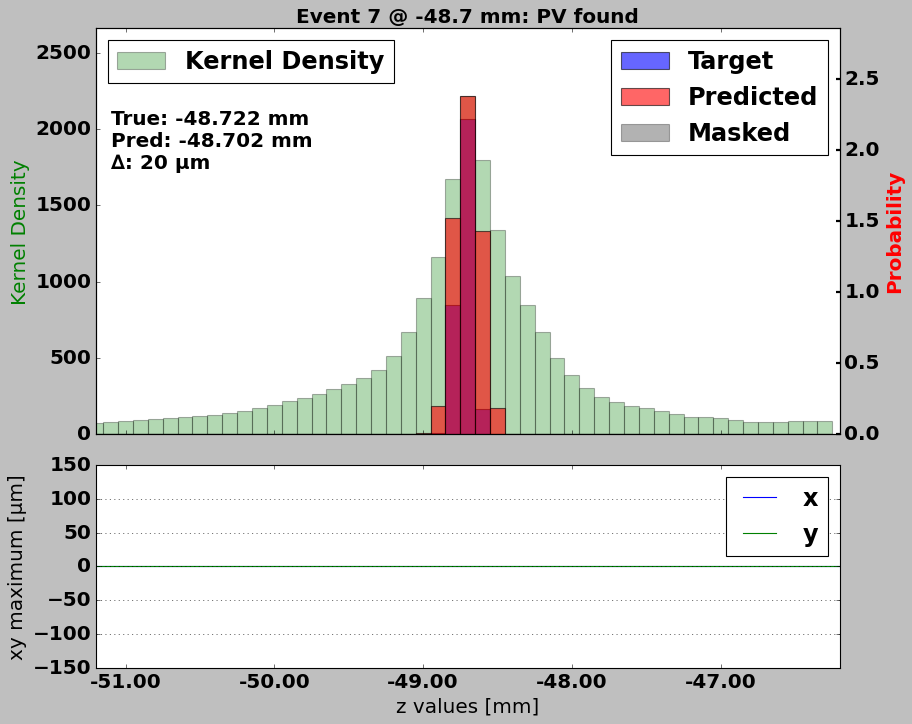


Event 7.2:


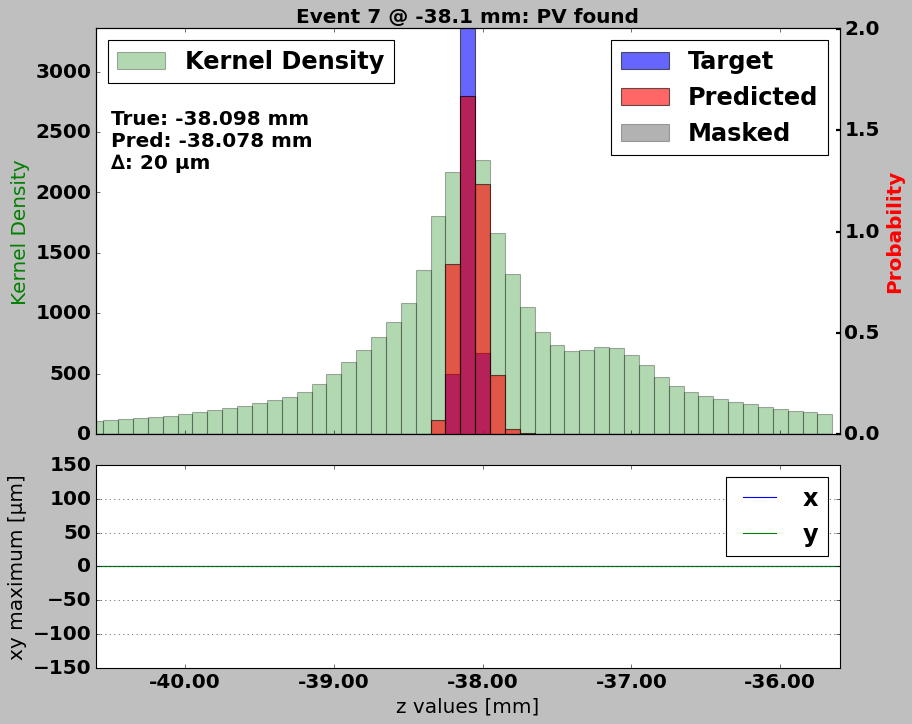


Event 7.3:


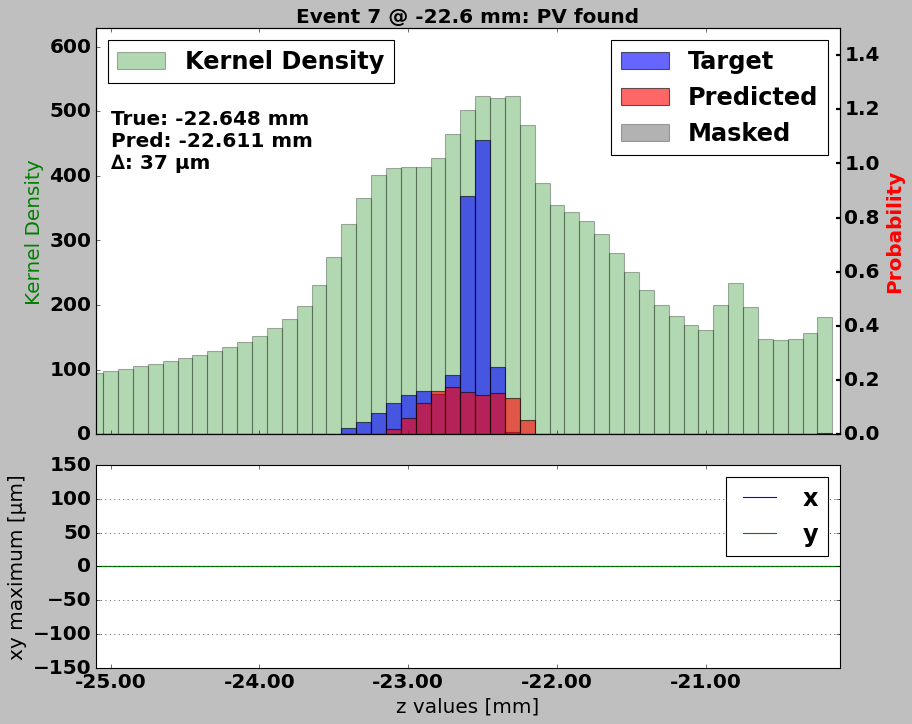


Event 7.4:


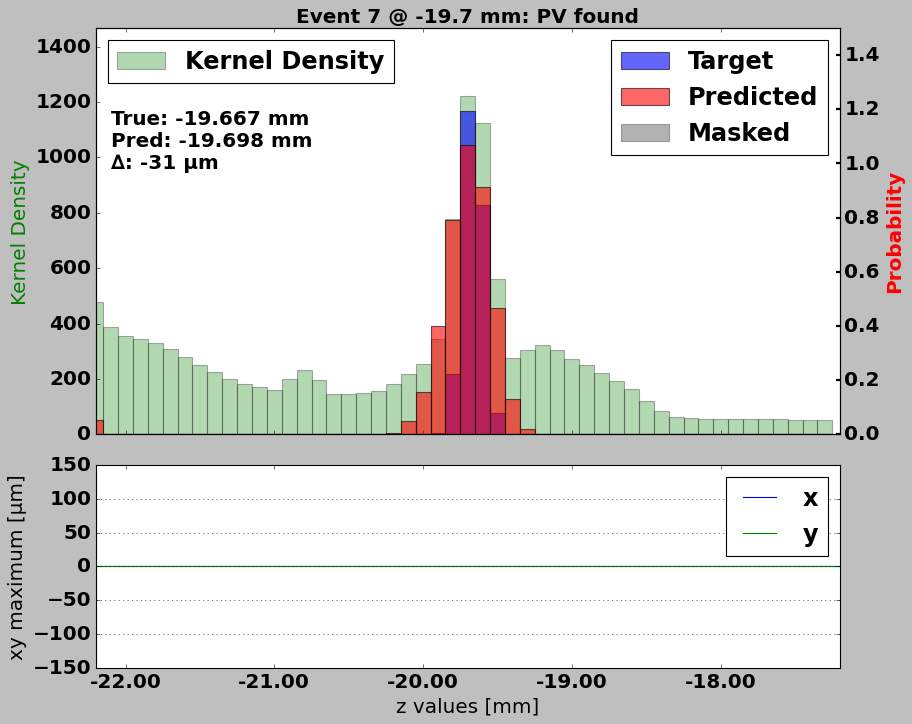


Event 7.5:


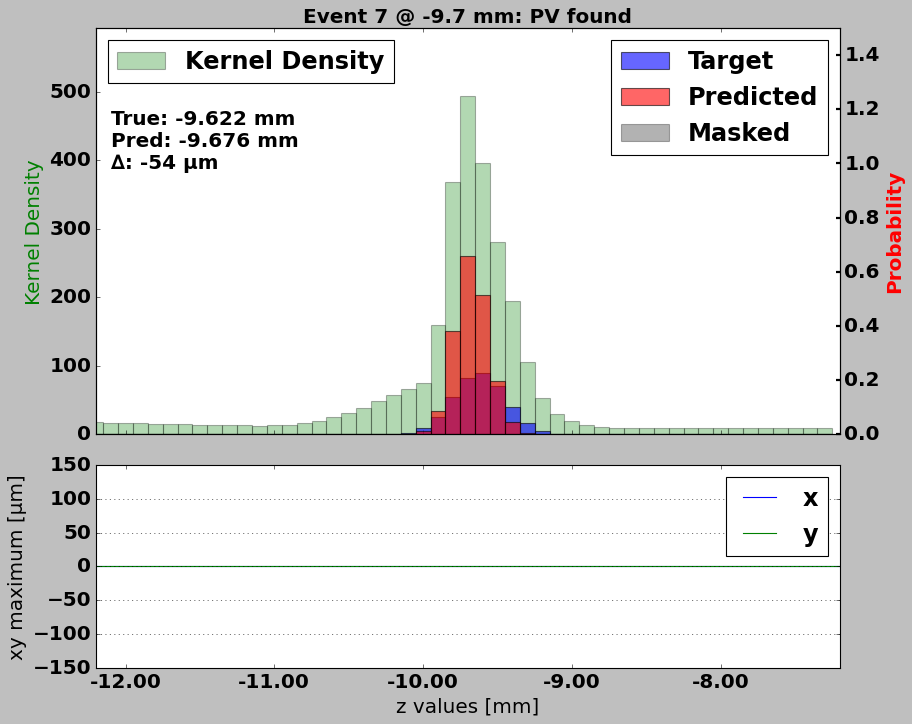


Event 7.6:


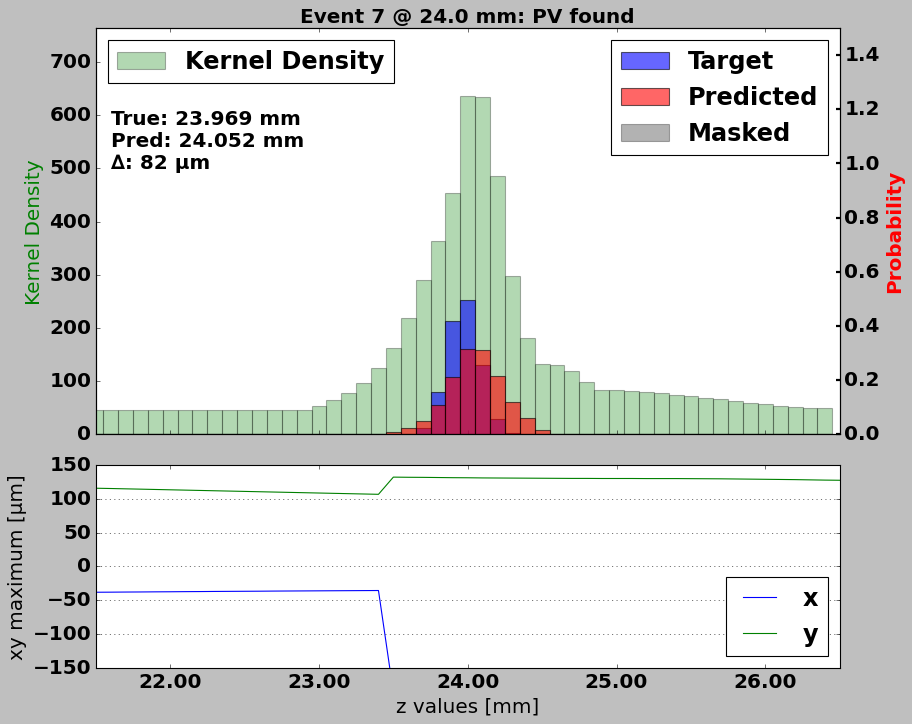


Event 7.7:


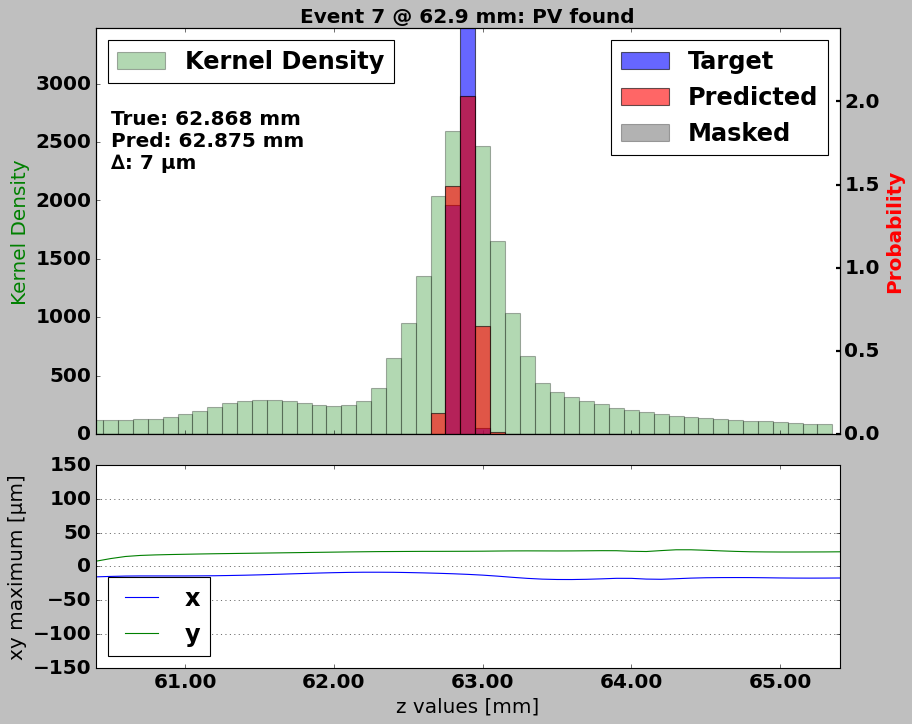


Event 8: Found 6 of 7, added 0 (eff 85.71%)

Event 8.0:


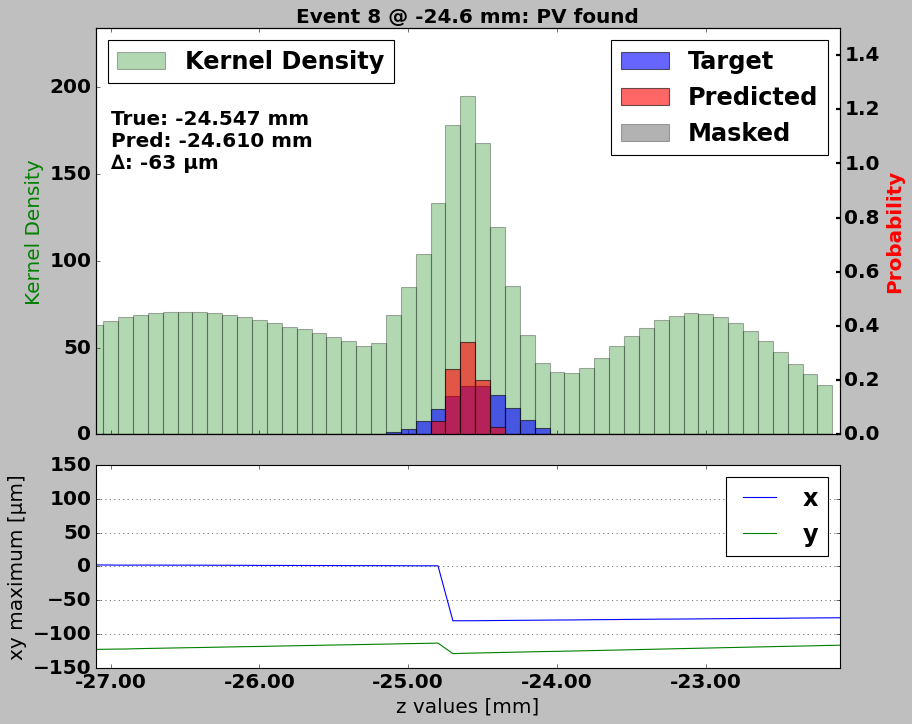


Event 8.1:


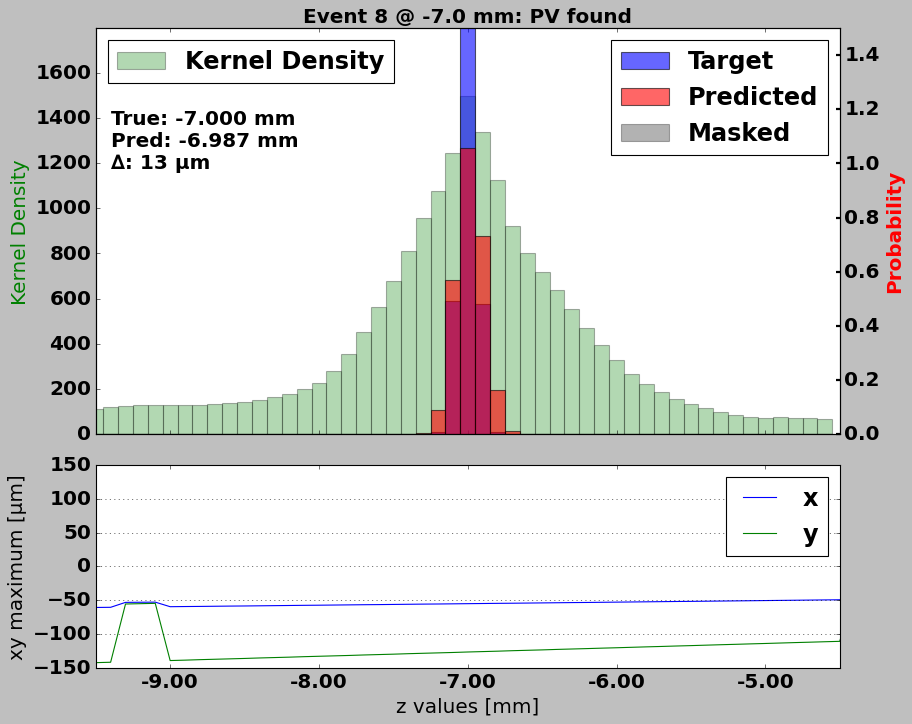


Event 8.2:


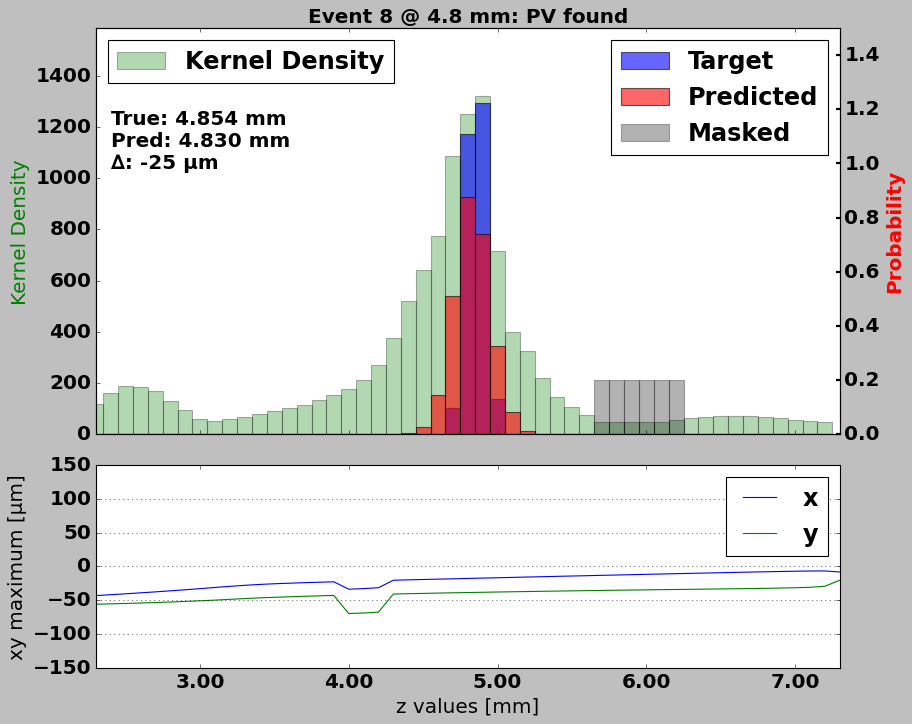


Event 8.3:

PV: 0 tracks (type -1)
  x:   -71 μm
  y:   -36 μm
  z:   24.659 mm


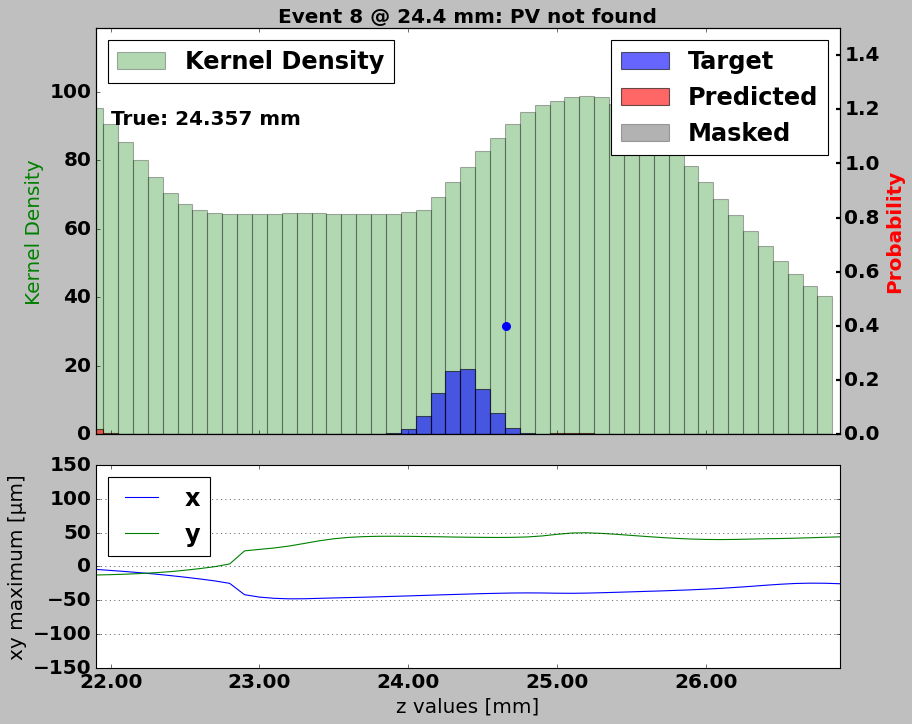


Event 8.4:


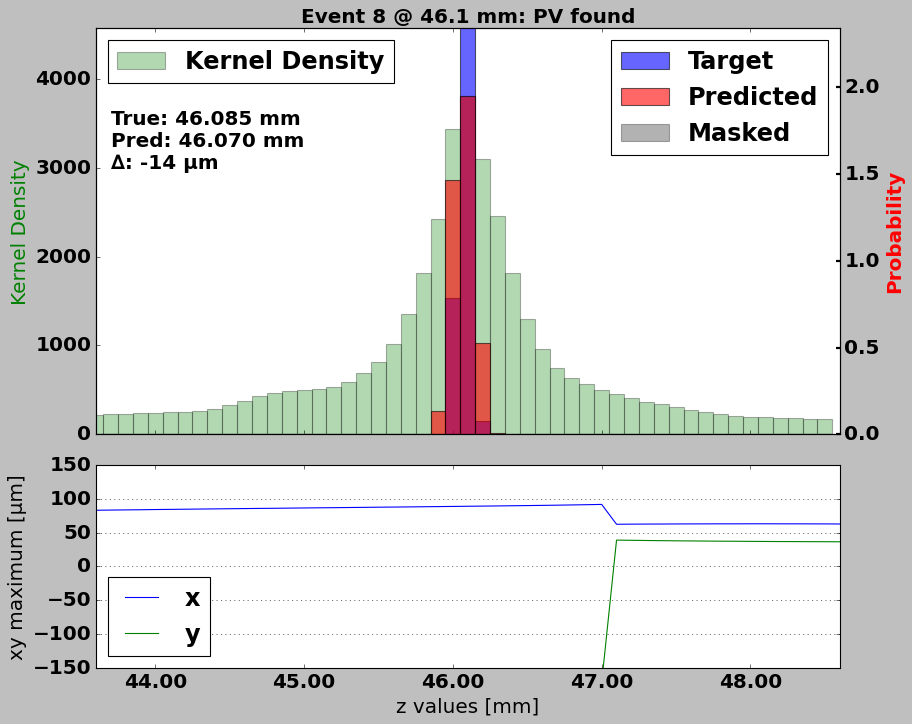


Event 8.5:

PV: 0 tracks (type -1)
  x:    48 μm
  y:    11 μm
  z:   79.426 mm


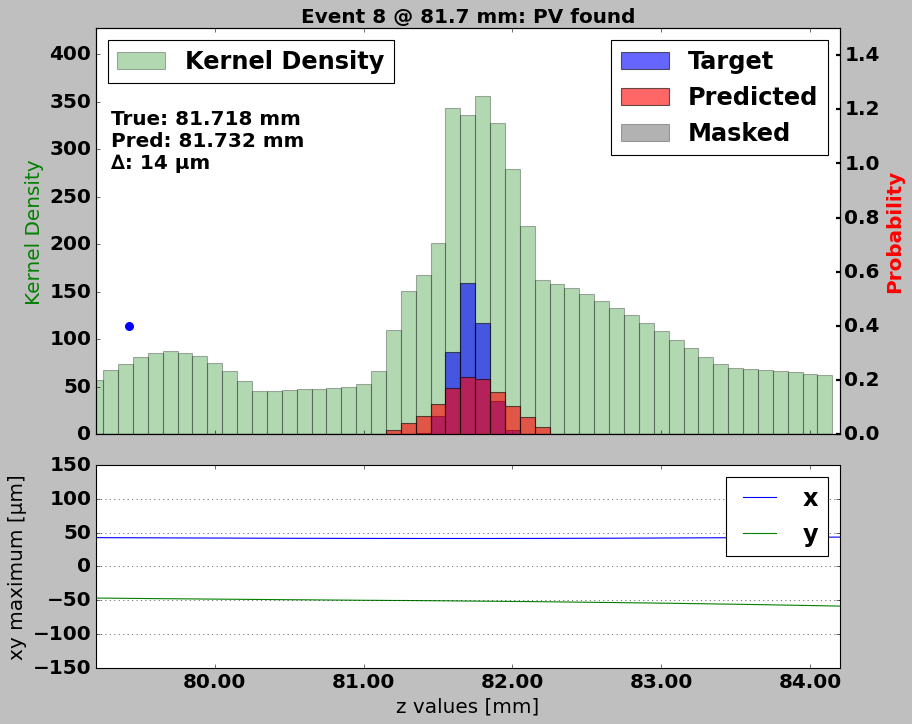


Event 8.6:


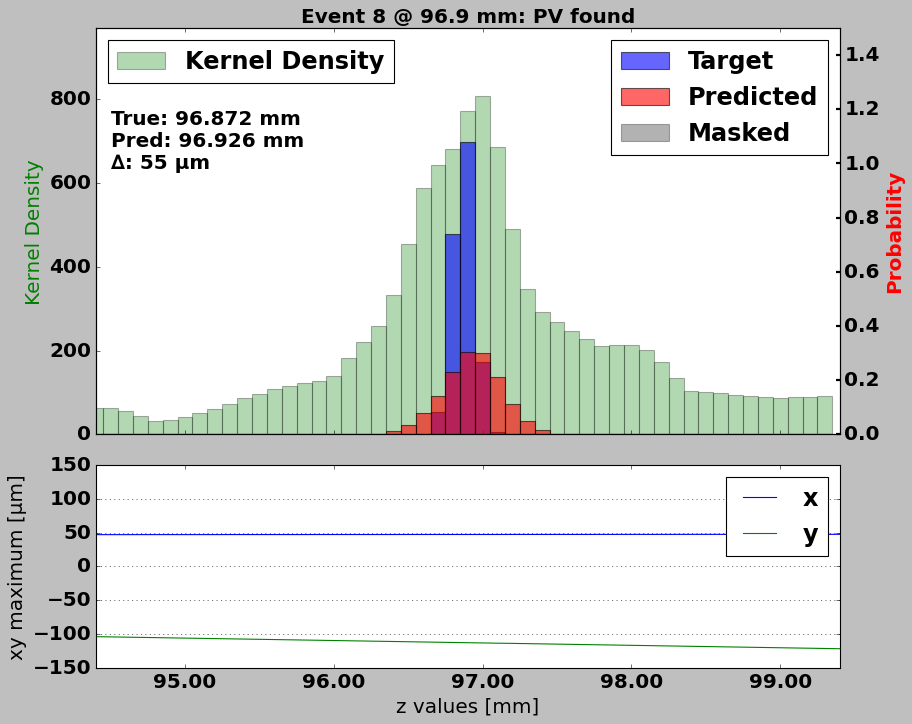


Event 9: Found 2 of 2, added 0 (eff 100.00%)

Event 9.0:


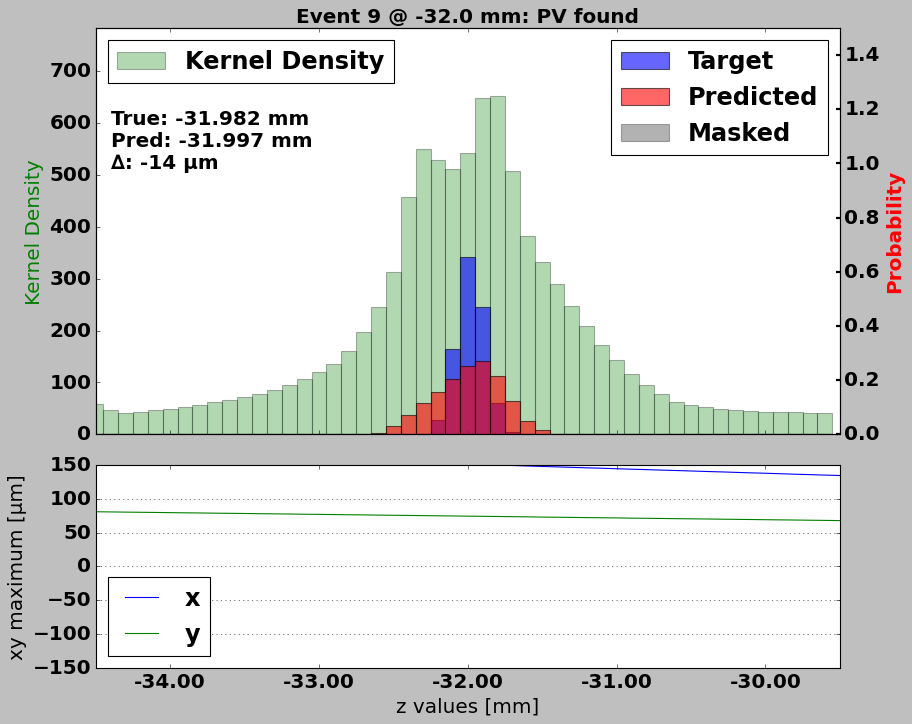


Event 9.1:


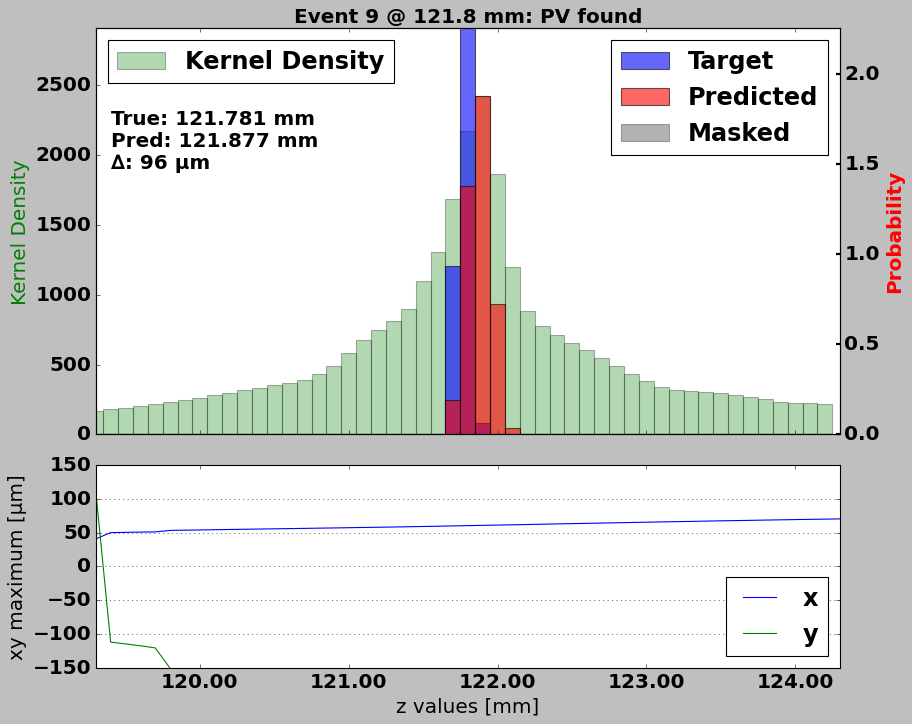


Event 10: Found 7 of 7, added 0 (eff 100.00%)

Event 10.0:


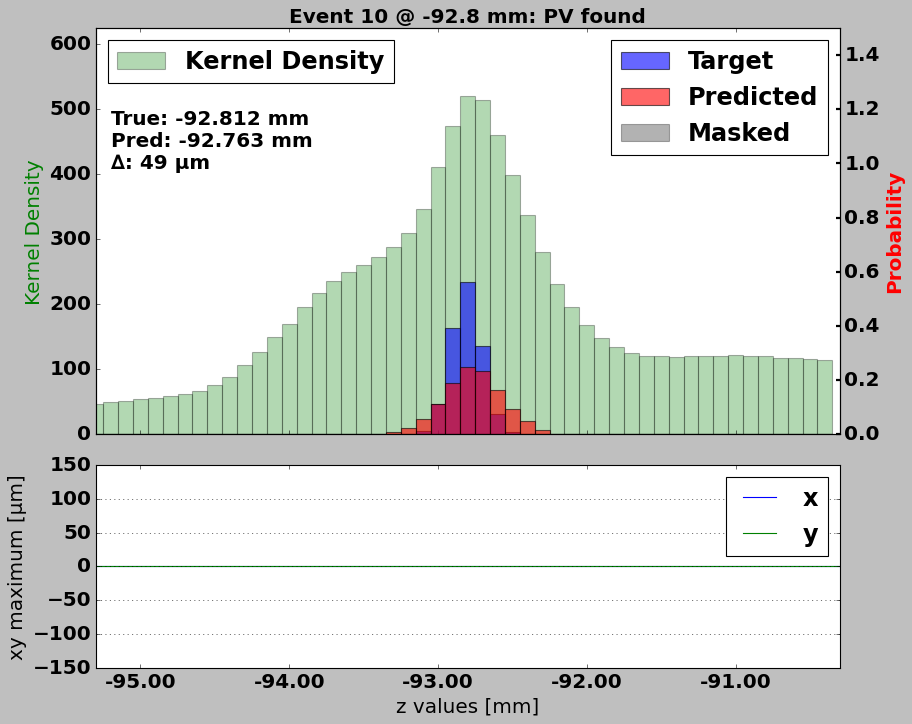


Event 10.1:


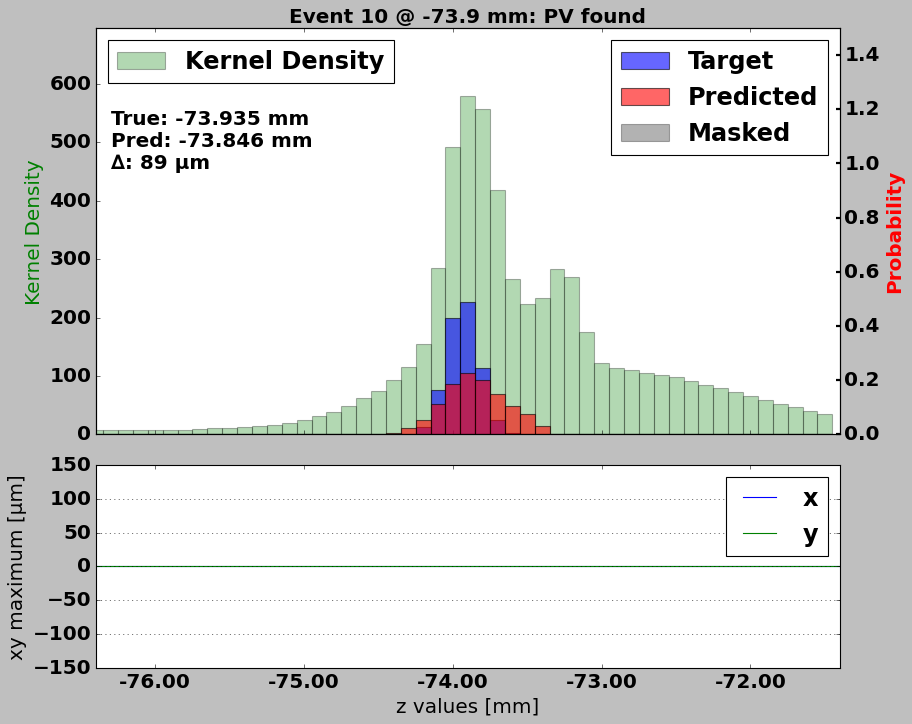


Event 10.2:


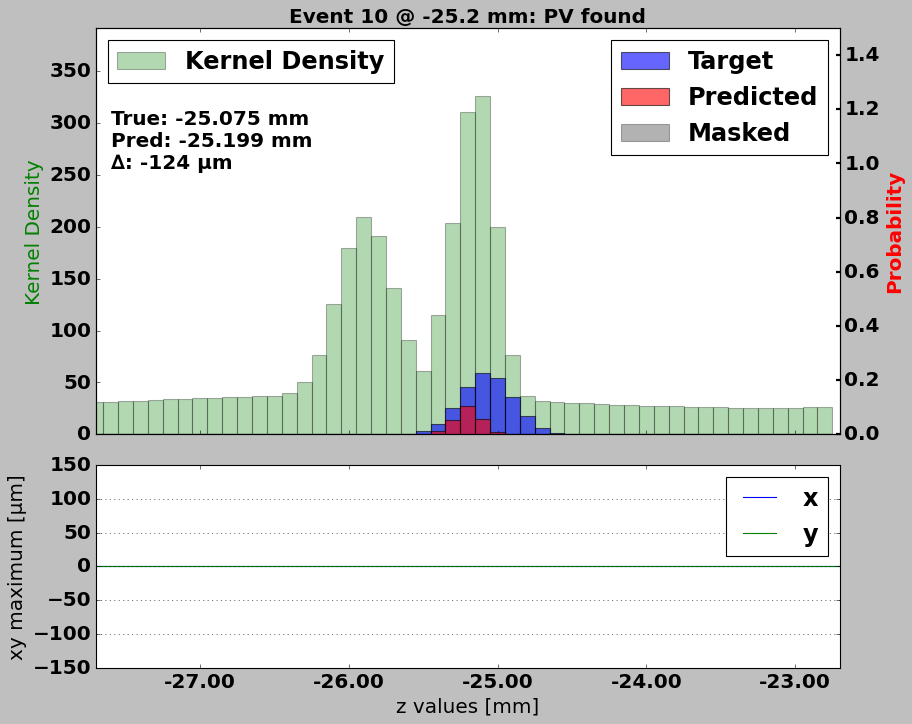


Event 10.3:


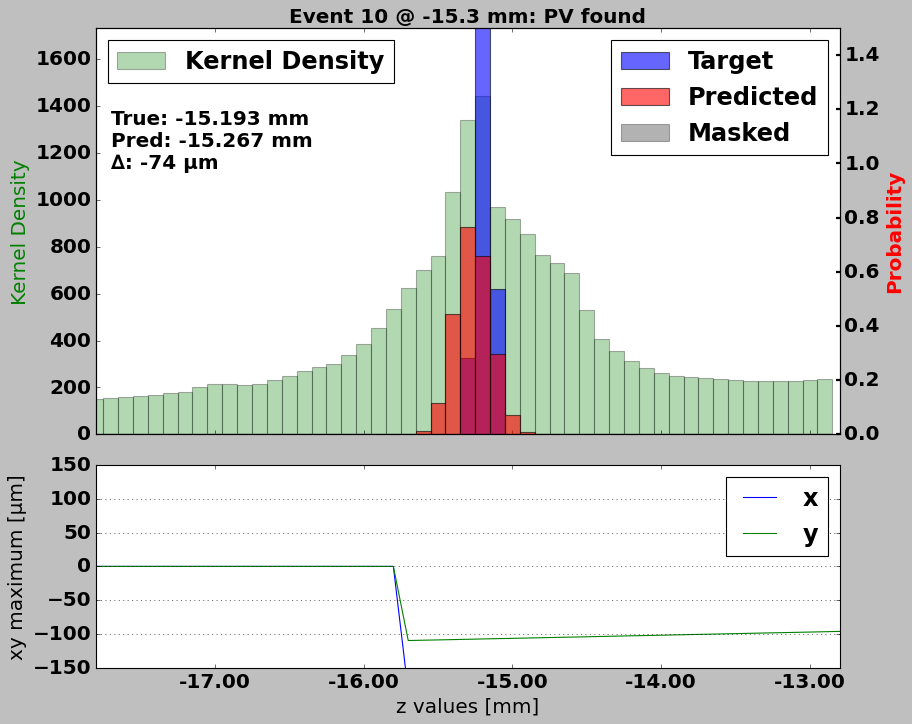


Event 10.4:


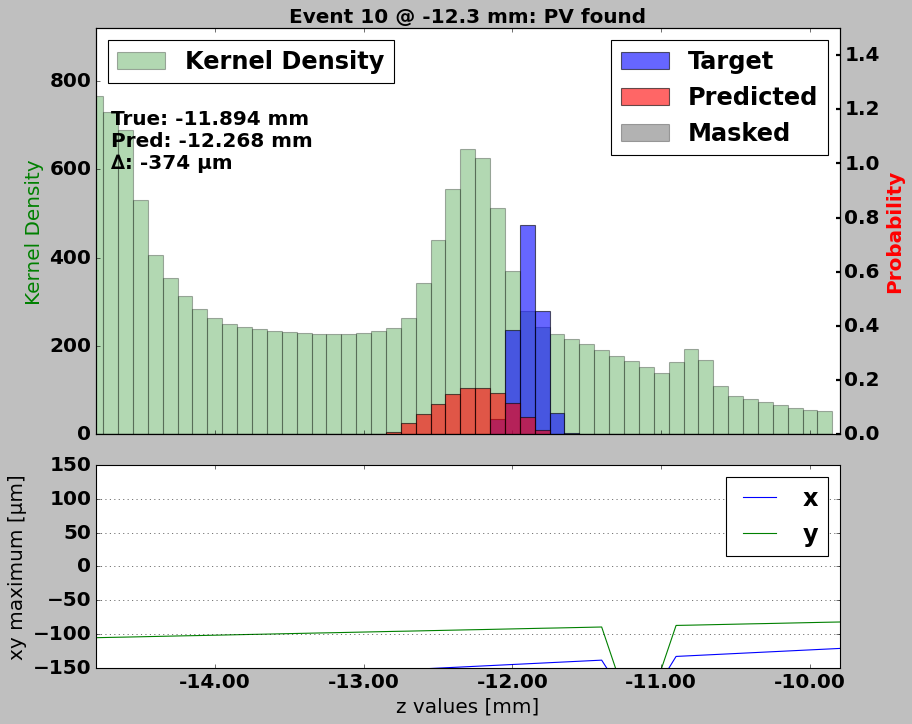


Event 10.5:


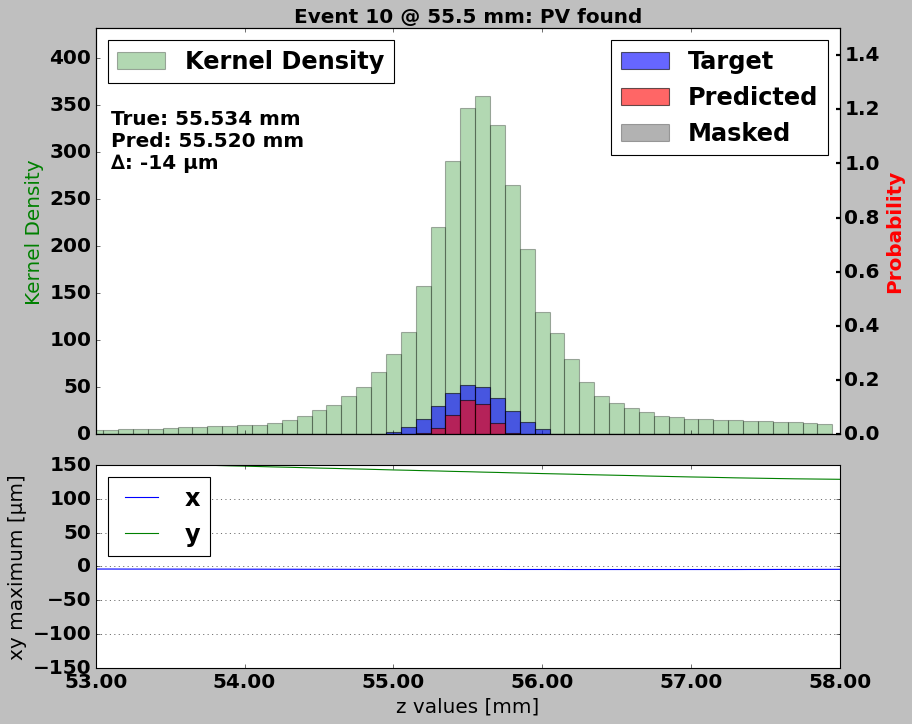


Event 10.6:


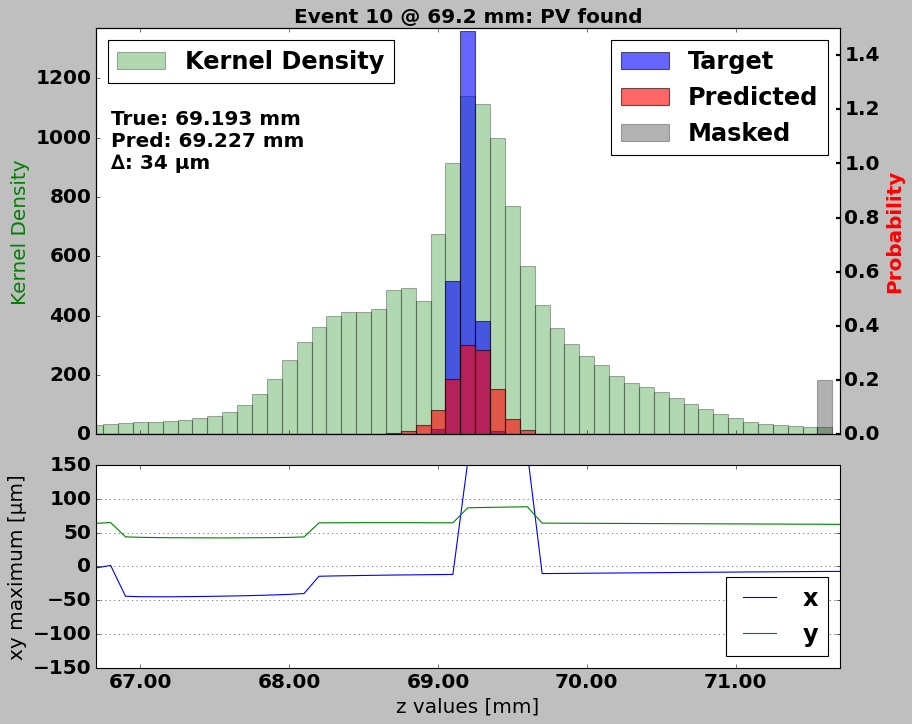


Event 11: Found 4 of 4, added 0 (eff 100.00%)

Event 11.0:


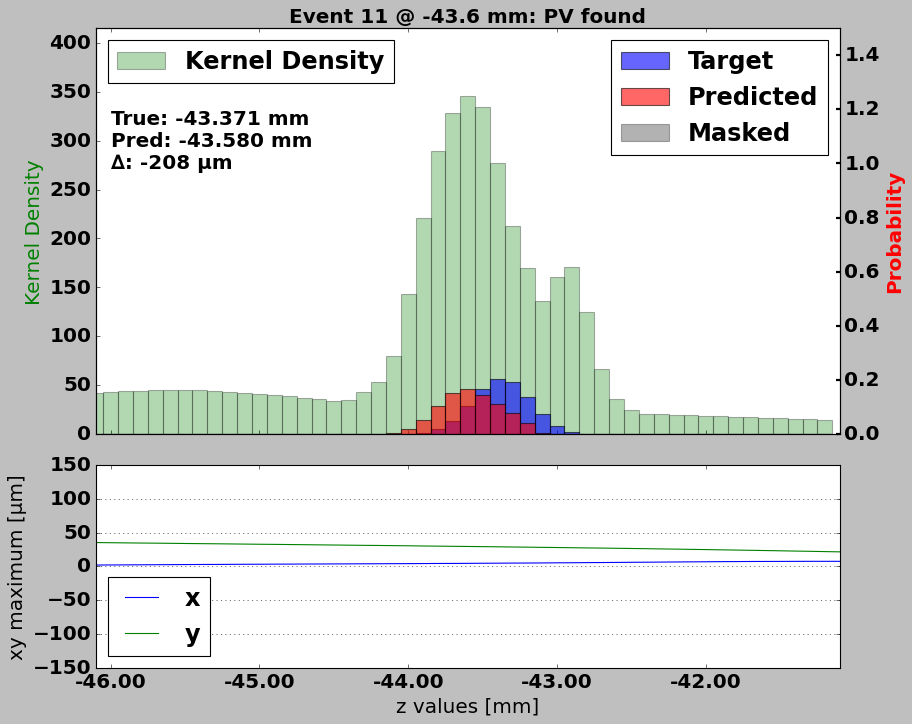


Event 11.1:


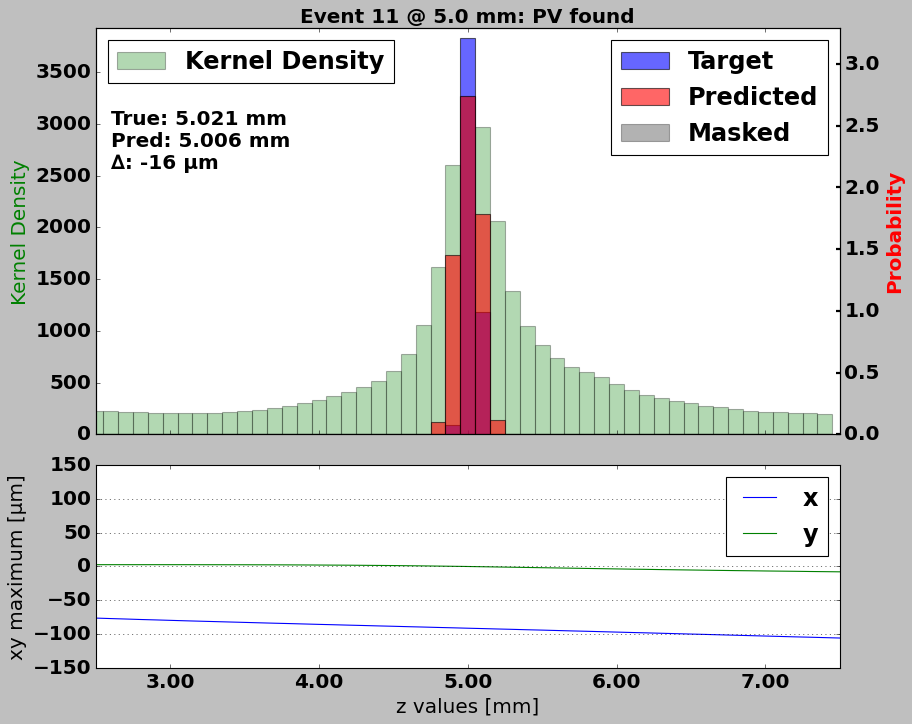


Event 11.2:

PV: 0 tracks (type -1)
  x:   -16 μm
  y:   -12 μm
  z:   53.078 mm


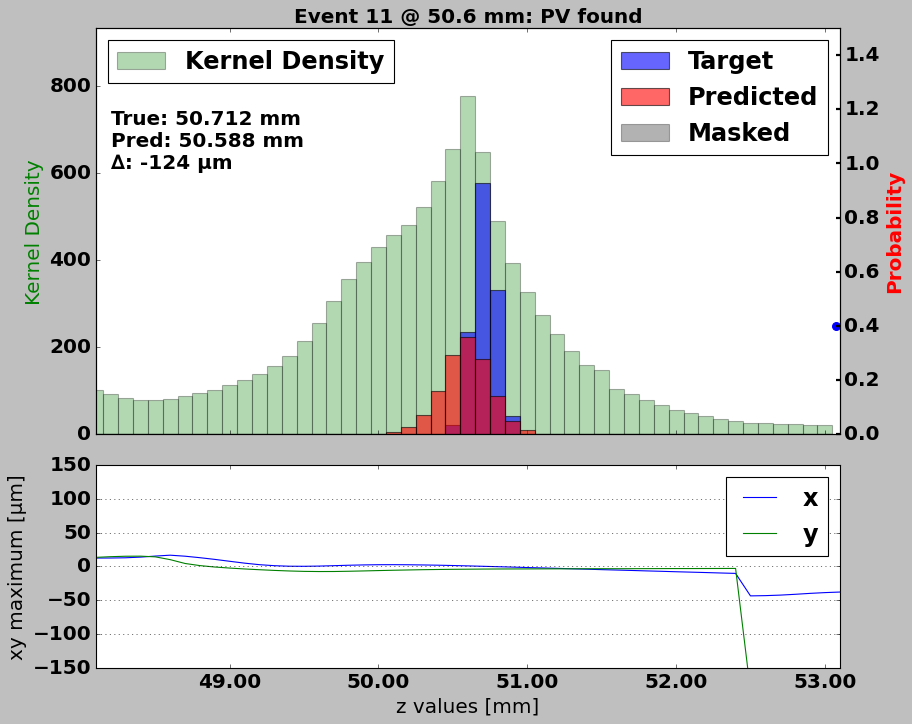


Event 11.3:

PV: 6 tracks (type 1)
  x:    78 μm
  y:   -43 μm
  z:   84.813 mm


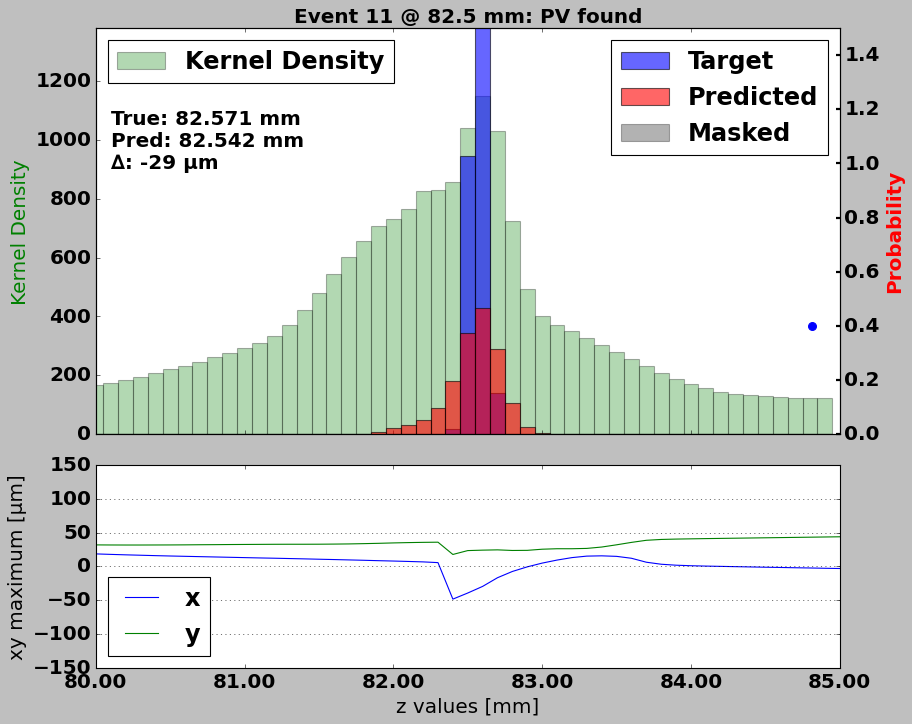


Event 12: Found 6 of 7, added 0 (eff 85.71%)

Event 12.0:


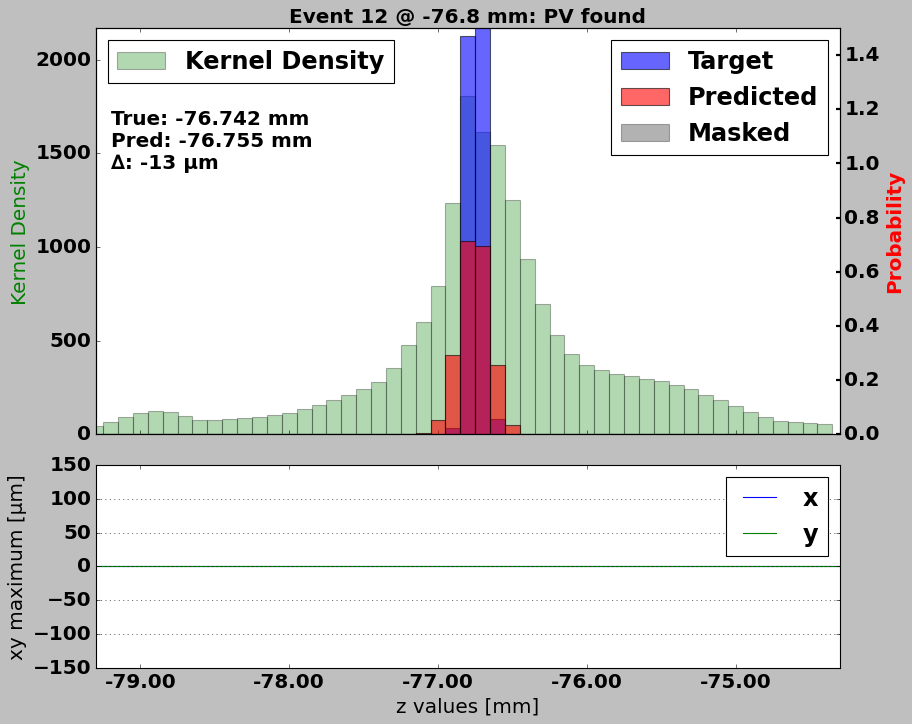


Event 12.1:


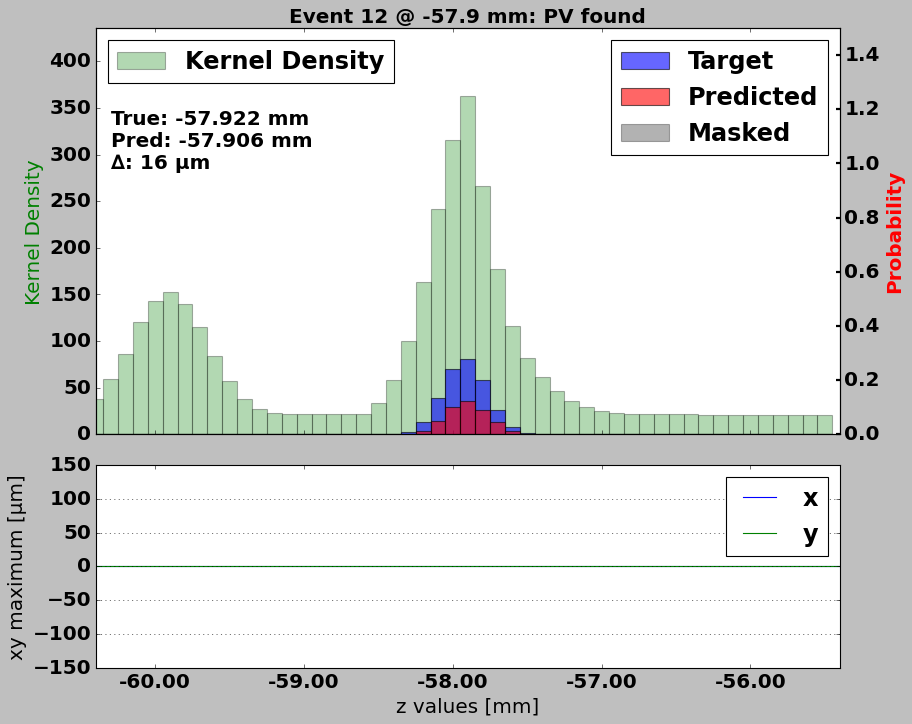


Event 12.2:


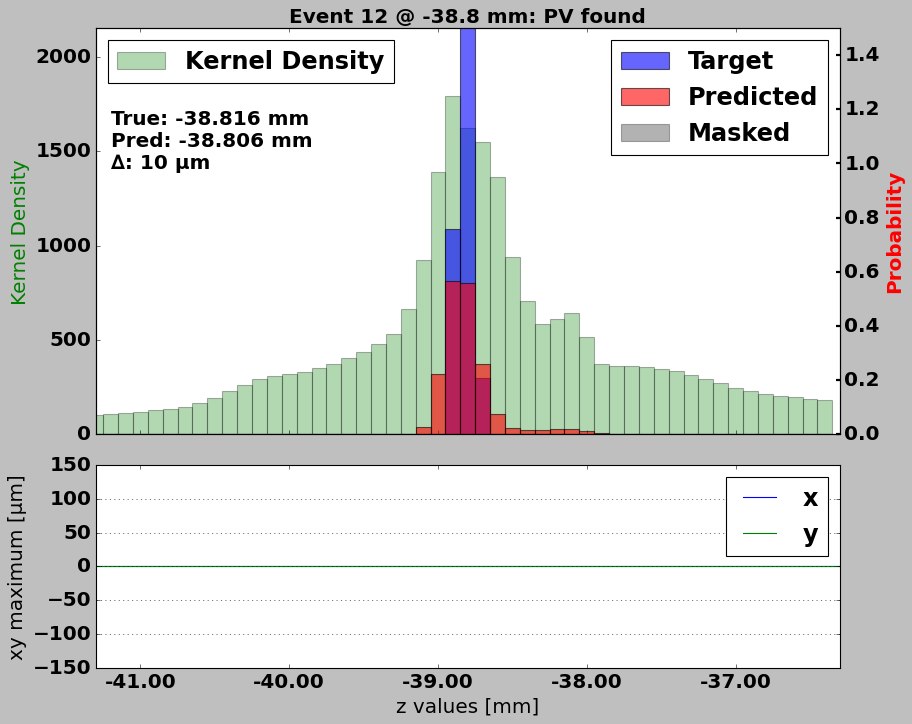


Event 12.3:


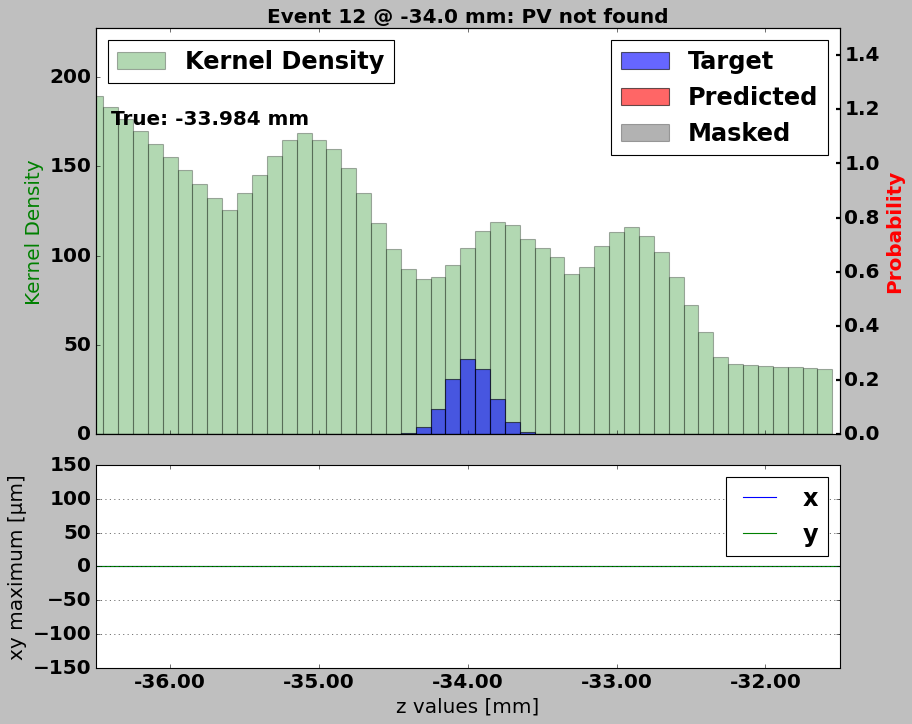


Event 12.4:


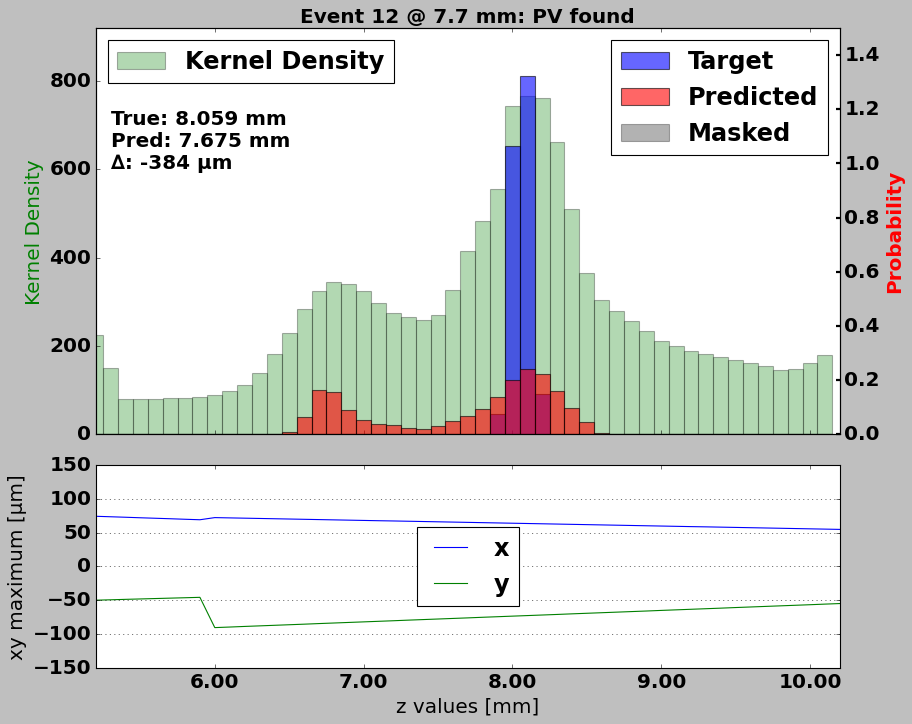


Event 12.5:


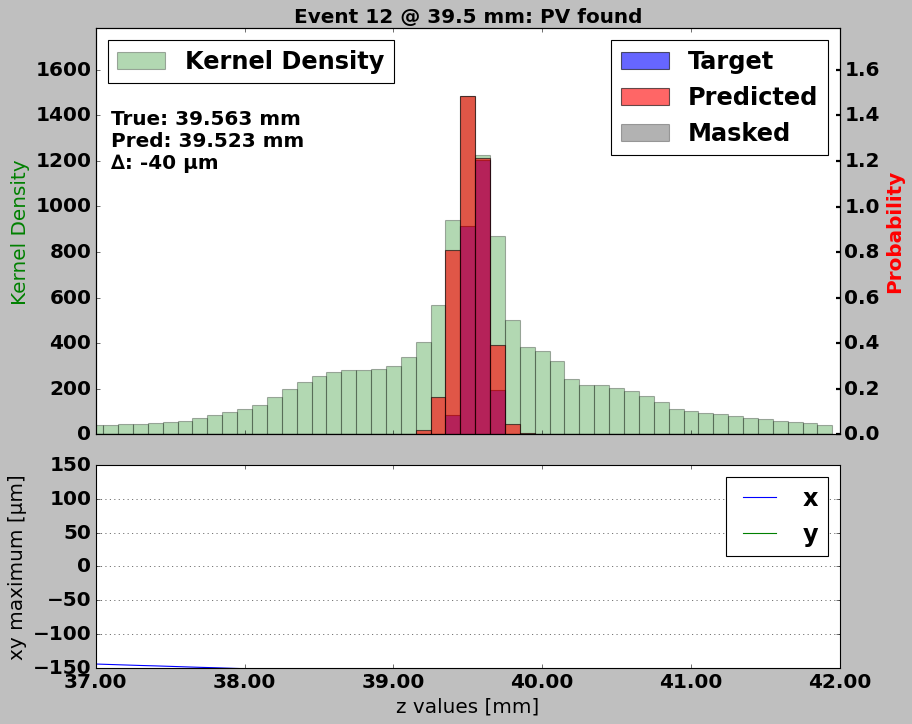


Event 12.6:

PV: 12 tracks (type 1)
  x:    70 μm
  y:    81 μm
  z:   65.952 mm


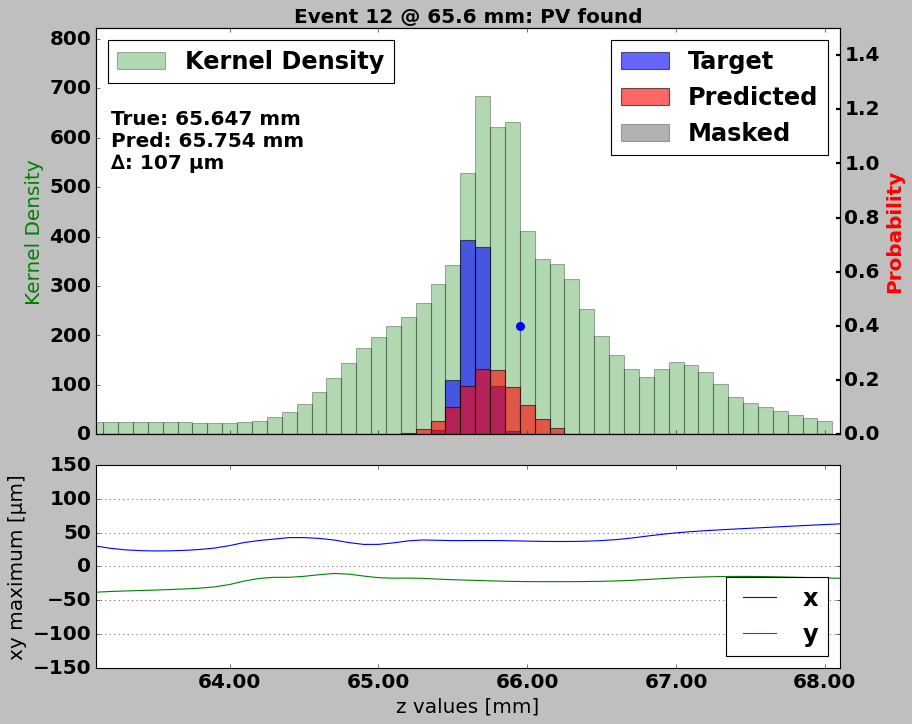


Event 13: Found 2 of 2, added 0 (eff 100.00%)

Event 13.0:


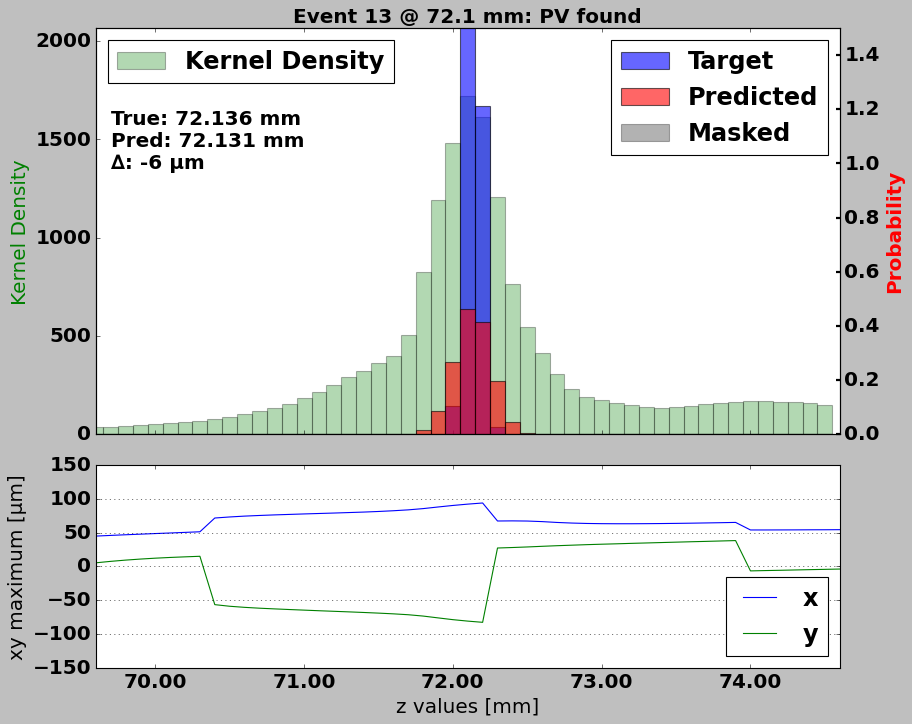


Event 13.1:


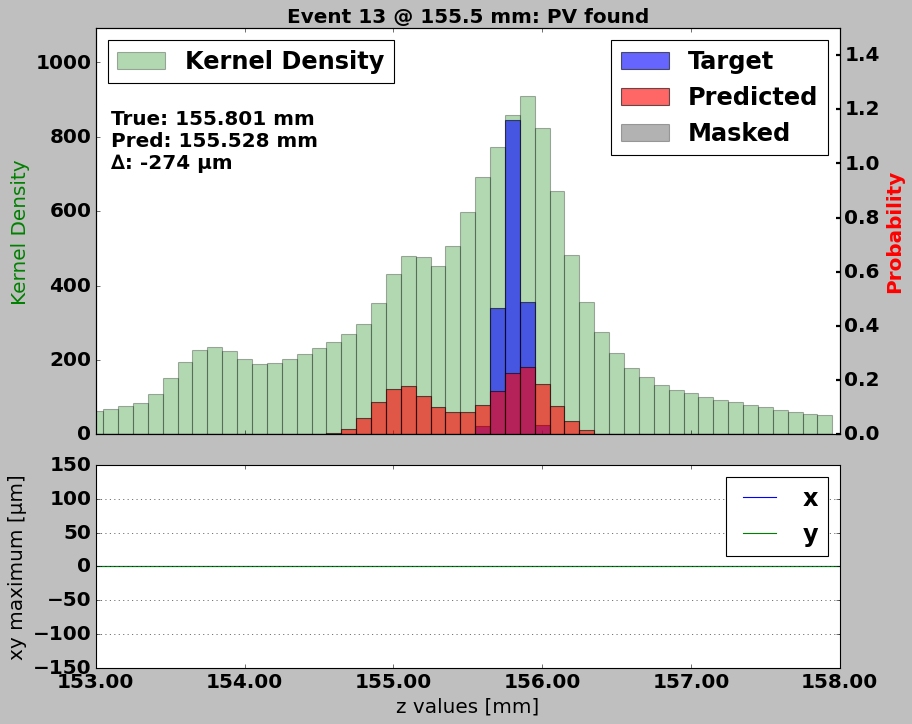


Event 14: Found 9 of 9, added 1 (eff 100.00%)

Event 14.0:


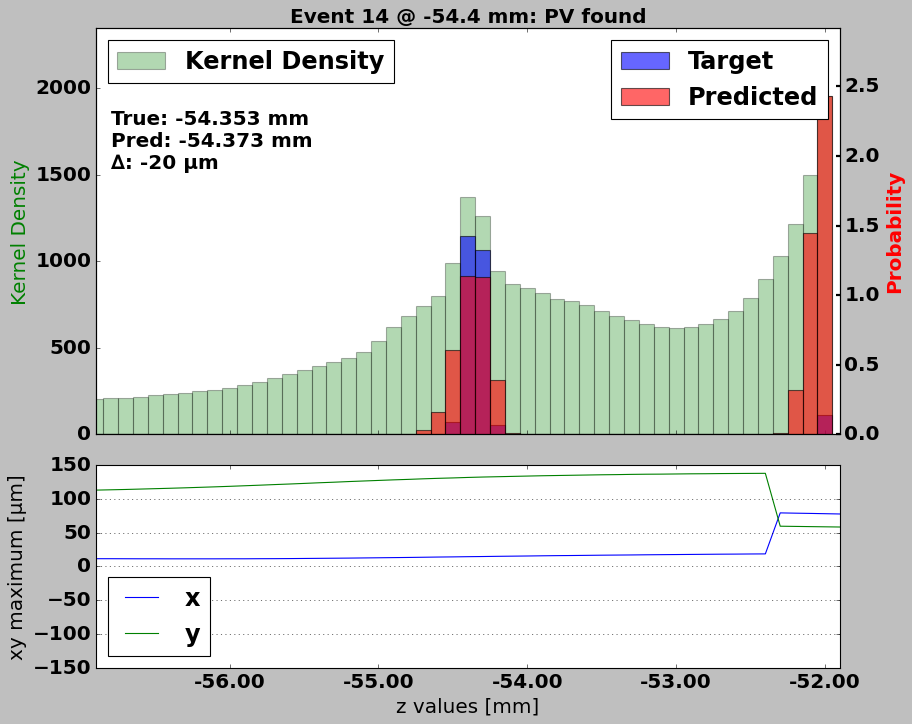


Event 14.1:


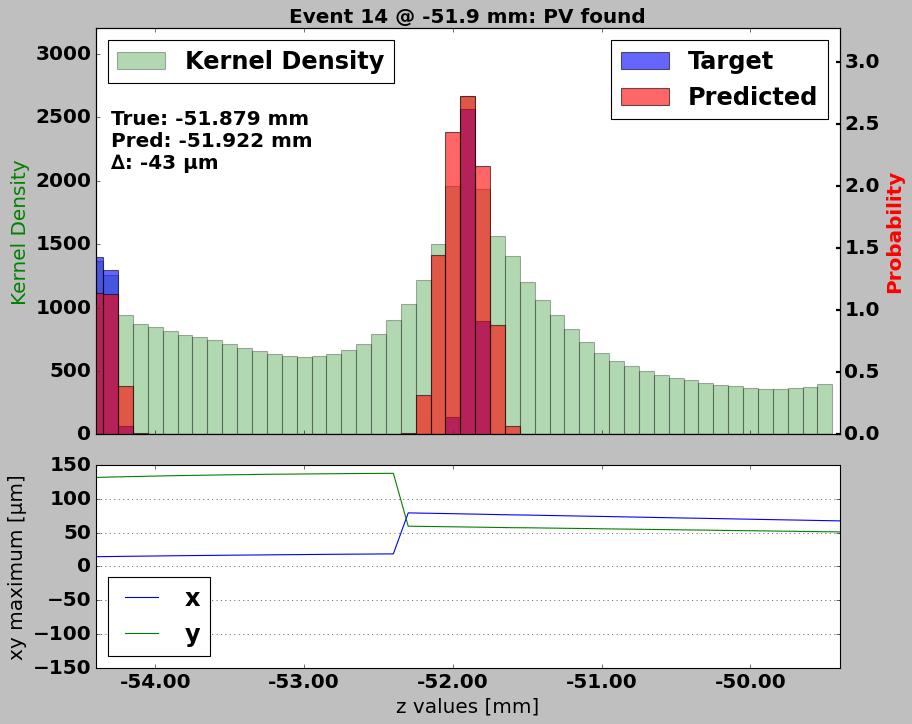


Event 14.2:


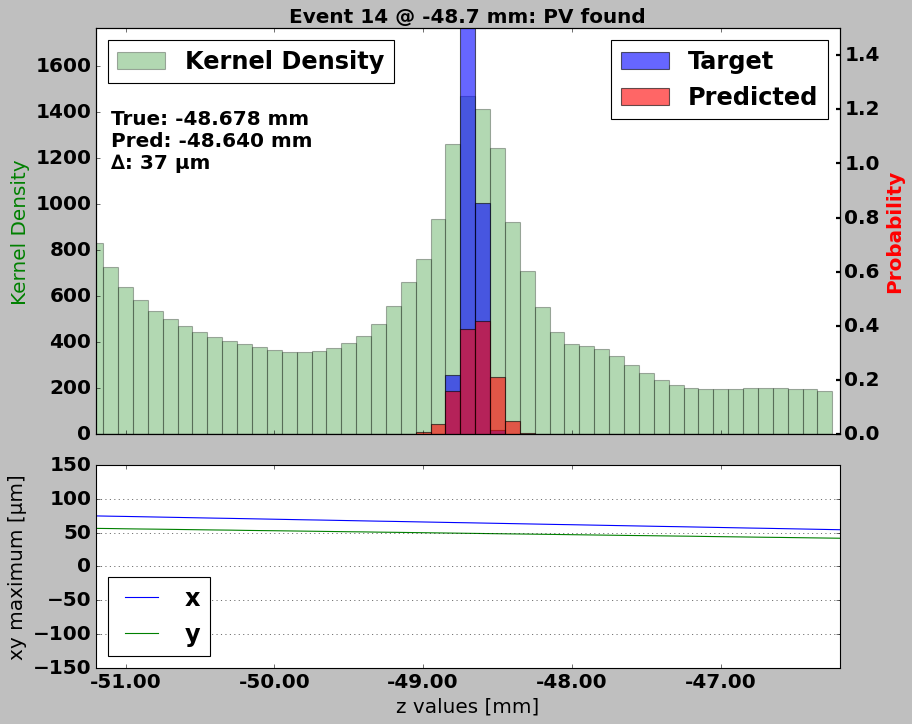


Event 14.3:


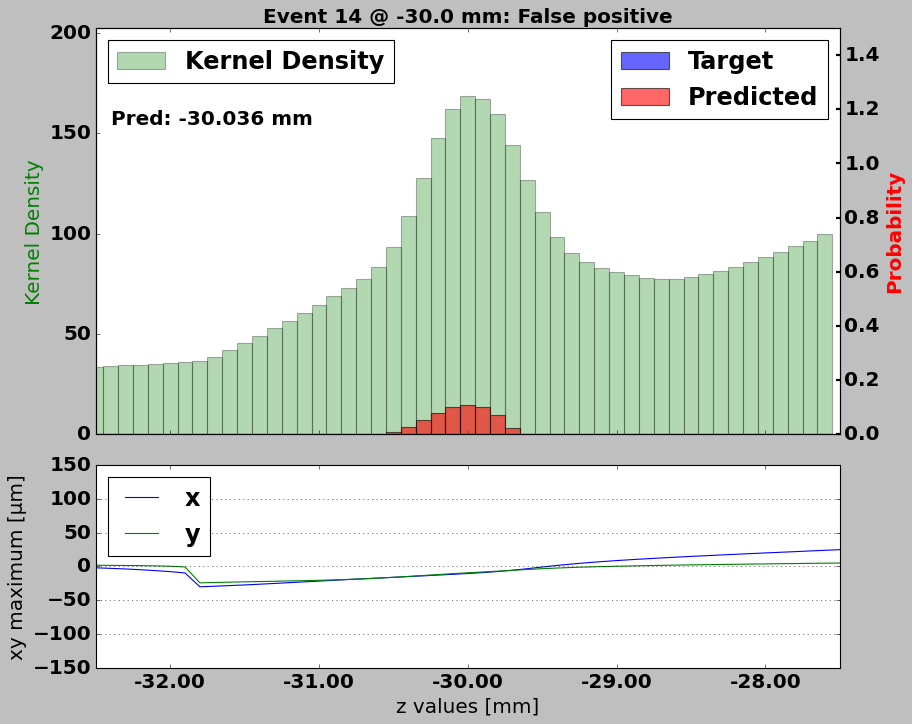


Event 14.4:


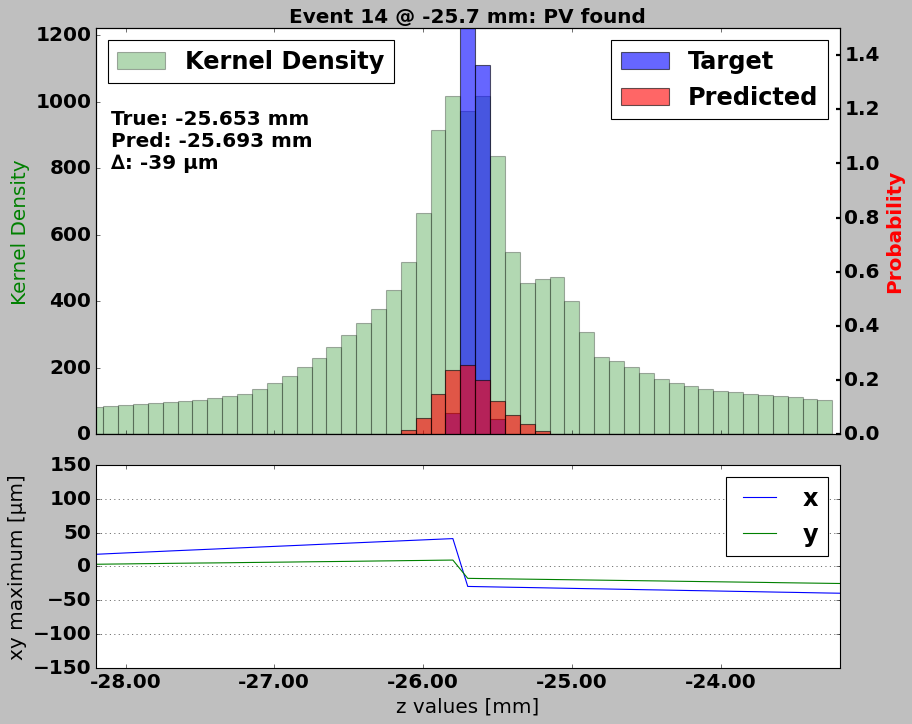


Event 14.5:


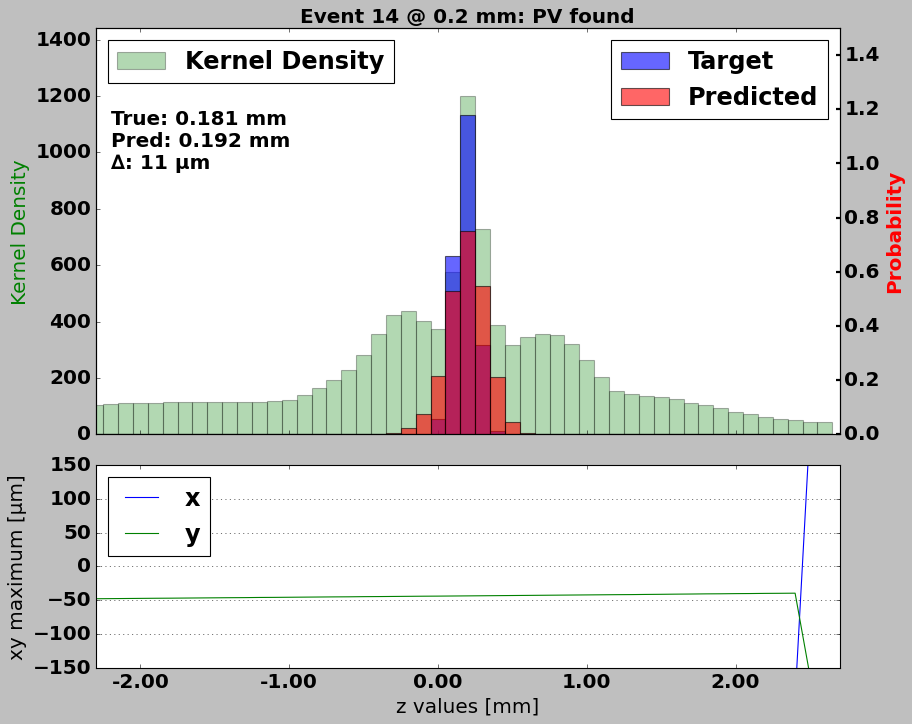


Event 14.6:


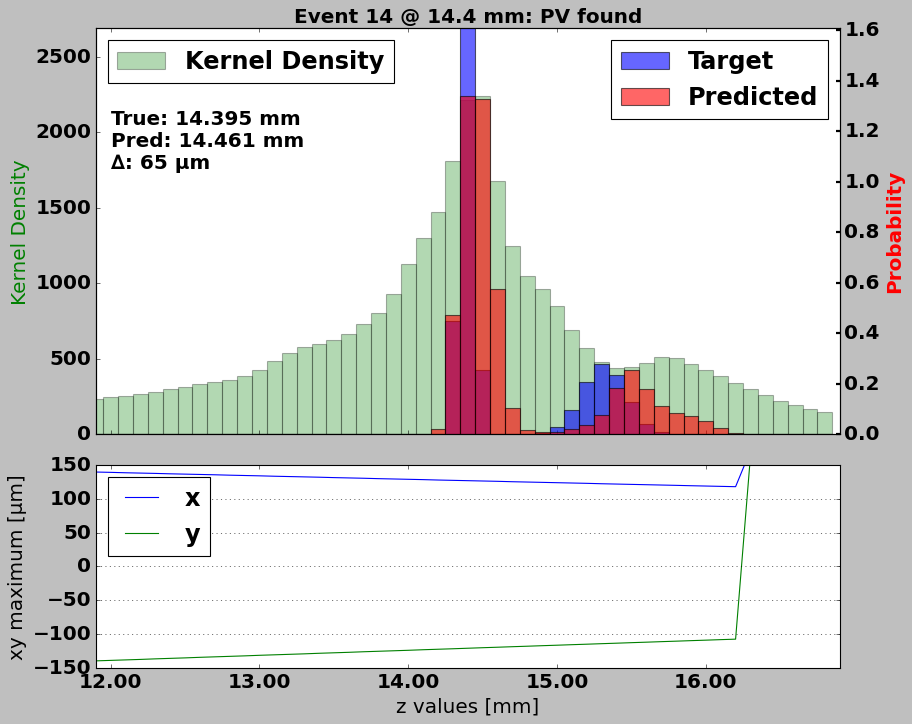


Event 14.7:


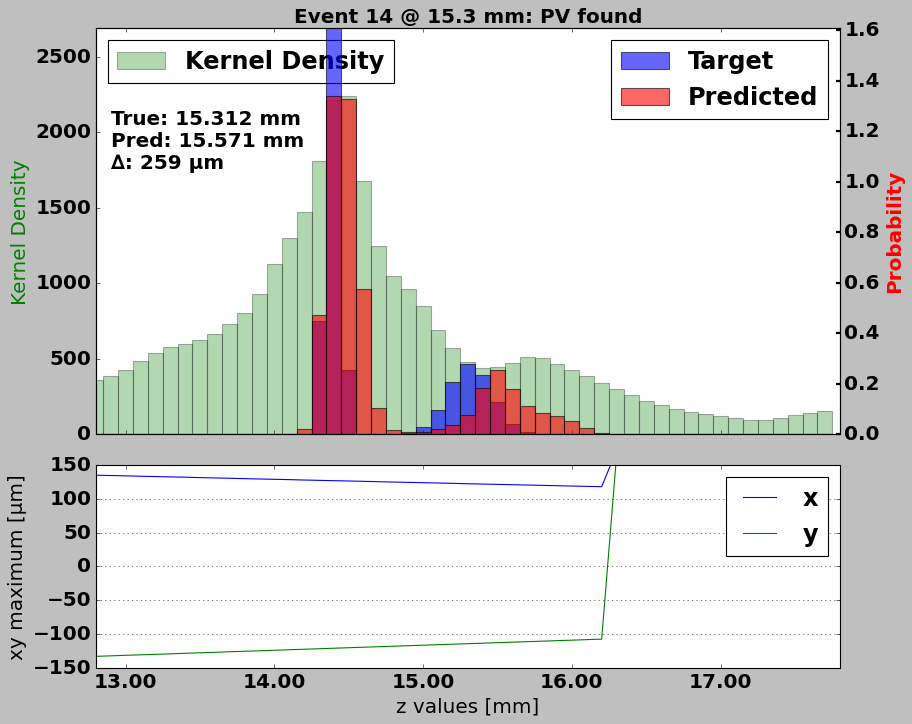


Event 14.8:


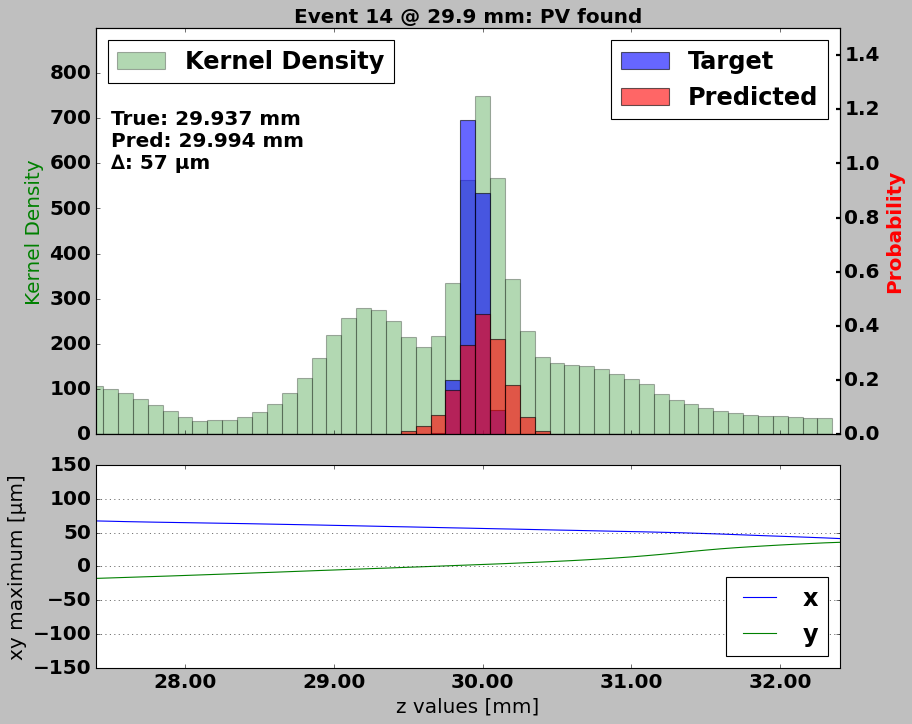


Event 14.9:


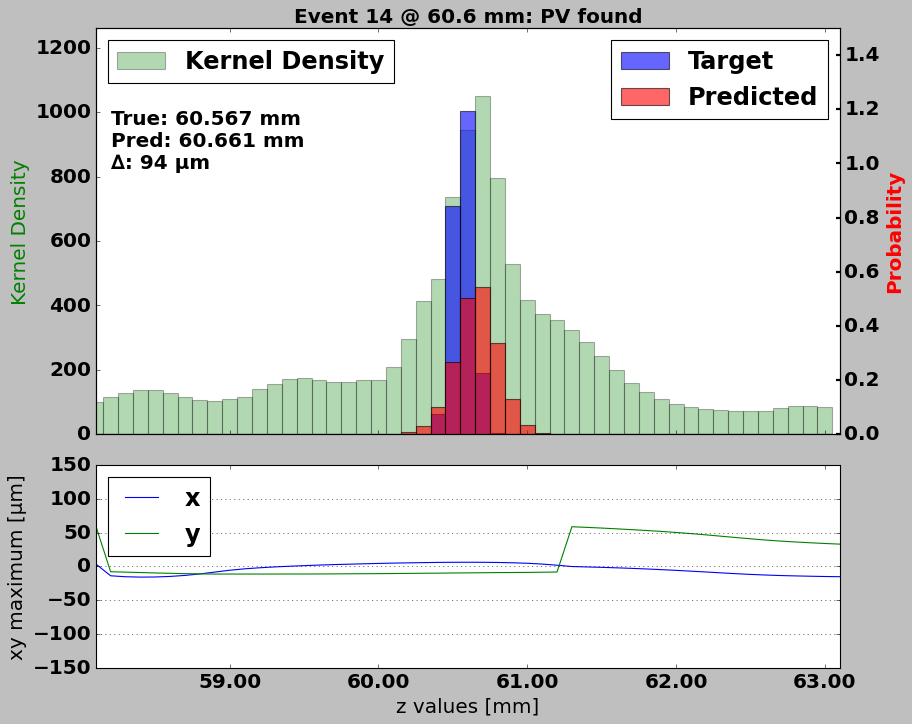


Event 15: Found 3 of 3, added 2 (eff 100.00%)

Event 15.0:


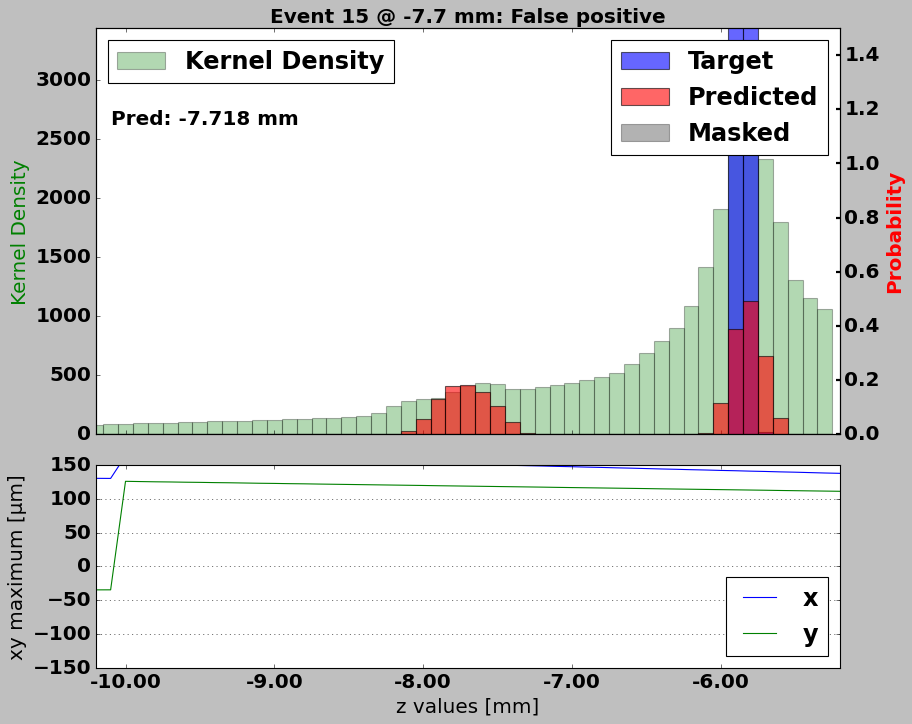


Event 15.1:


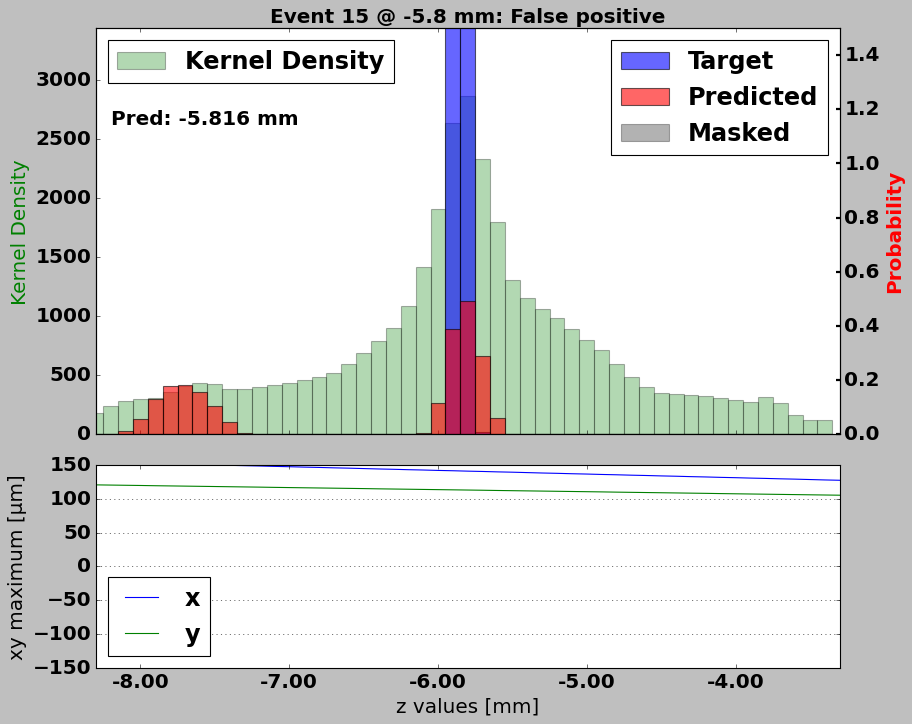


Event 15.2:

PV: 12 tracks (type 1)
  x:    99 μm
  y:    79 μm
  z:   12.864 mm


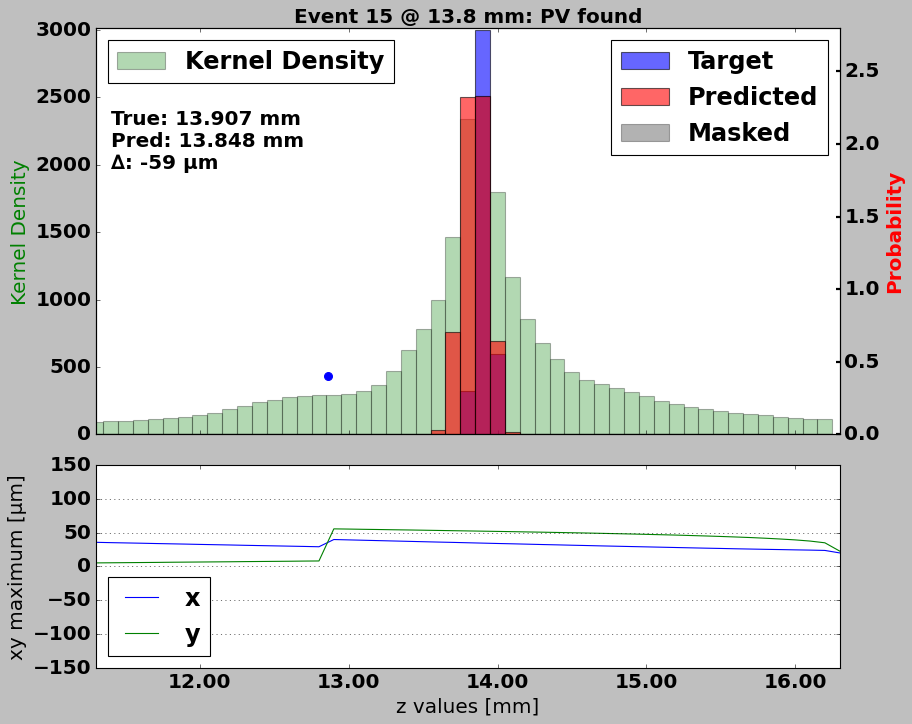


Event 15.3:


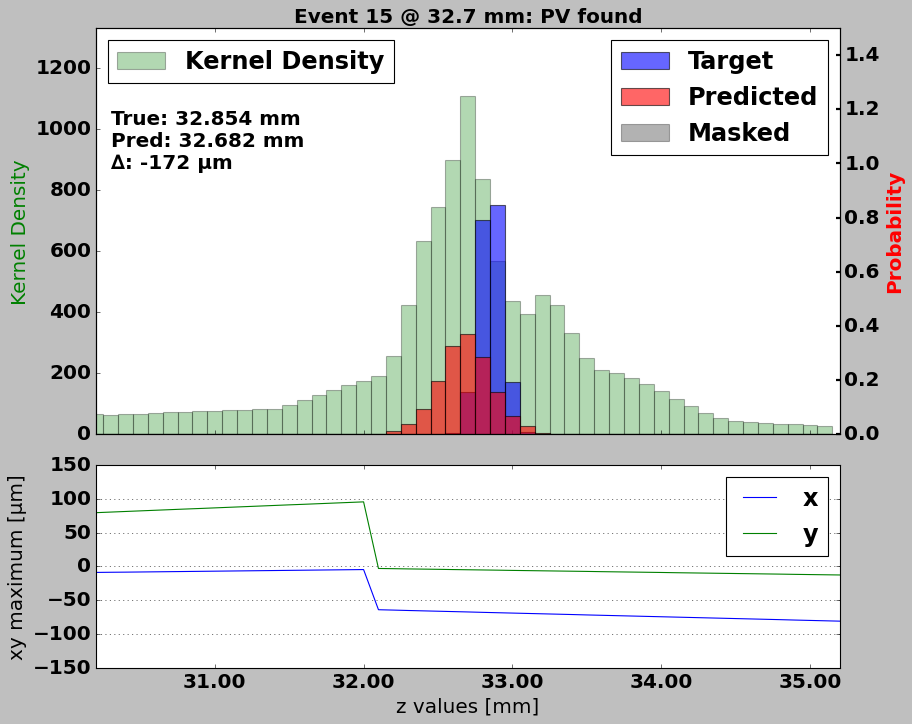


Event 15.4:


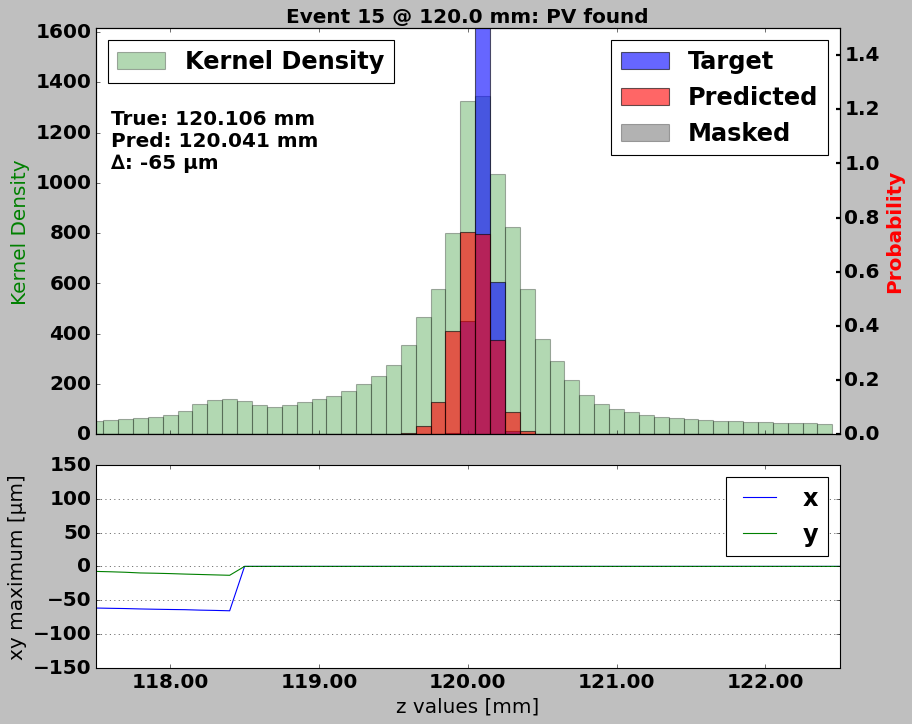


Event 16: Found 4 of 7, added 2 (eff 57.14%)

Event 16.0:


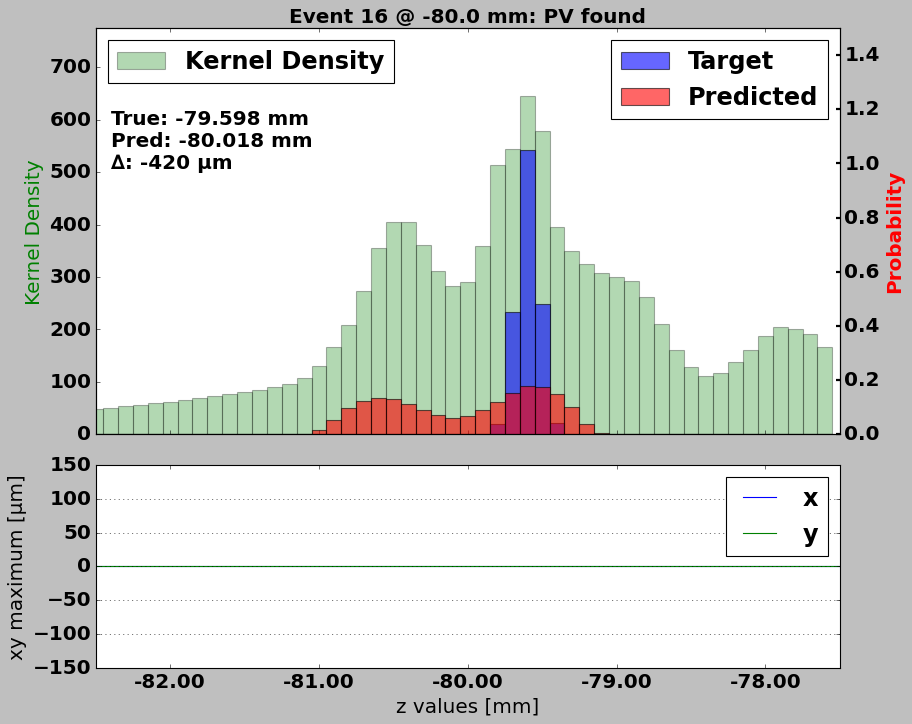


Event 16.1:


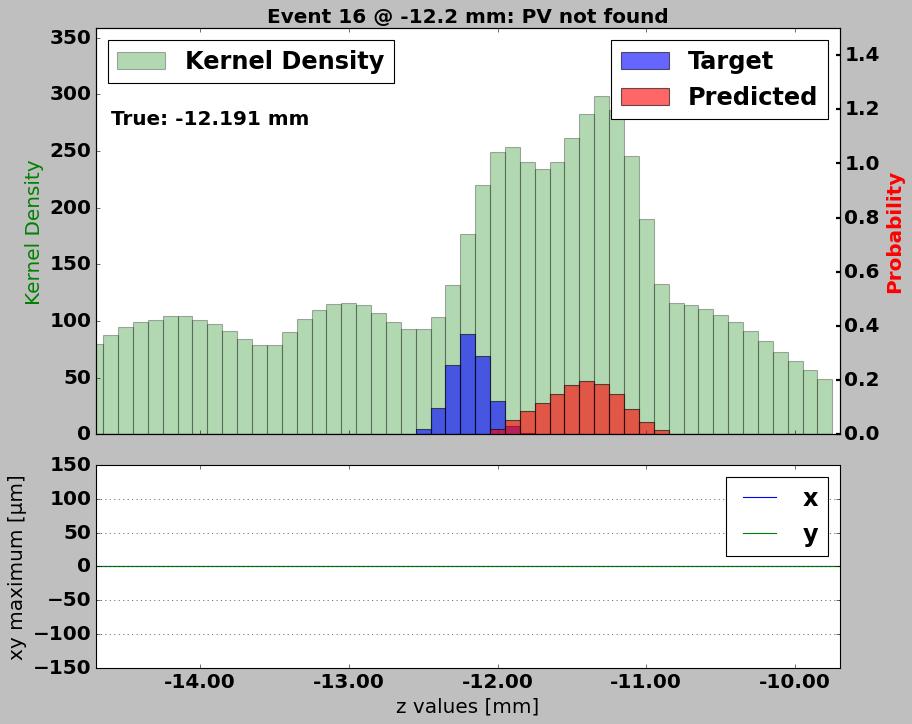


Event 16.2:


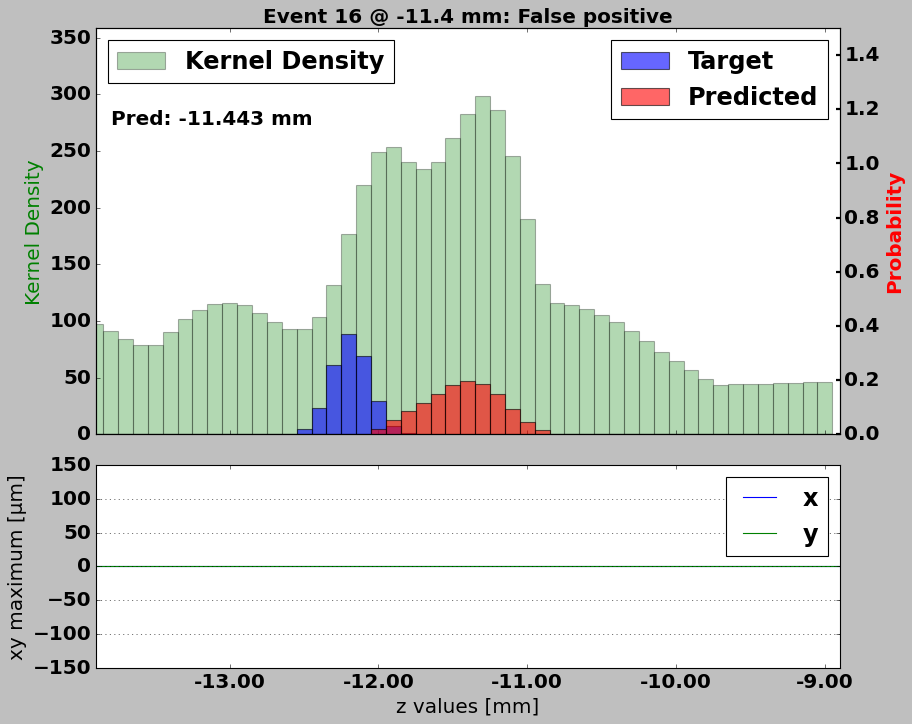


Event 16.3:


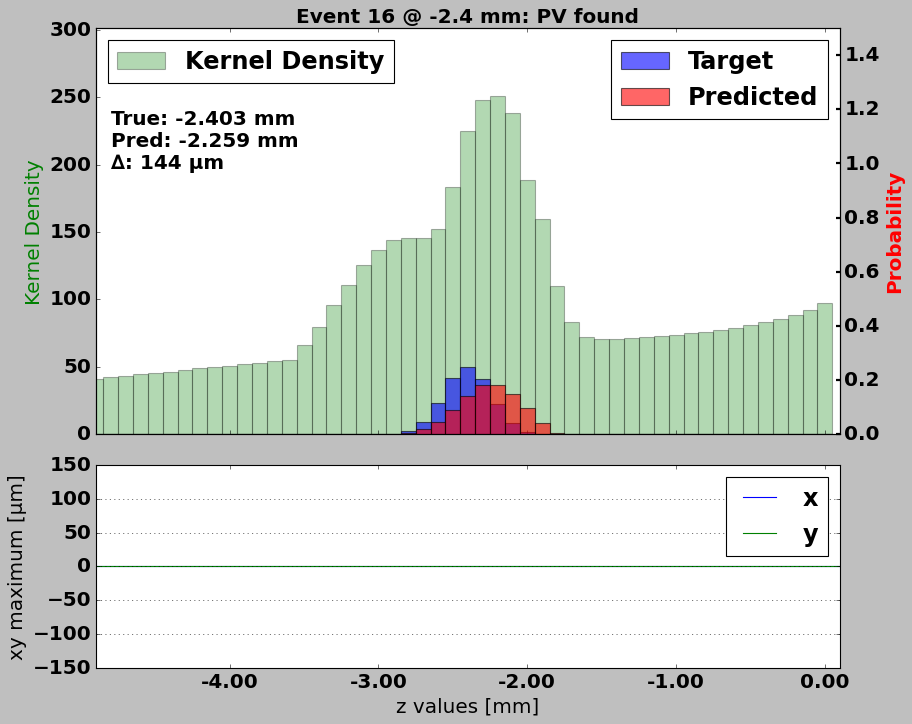


Event 16.4:


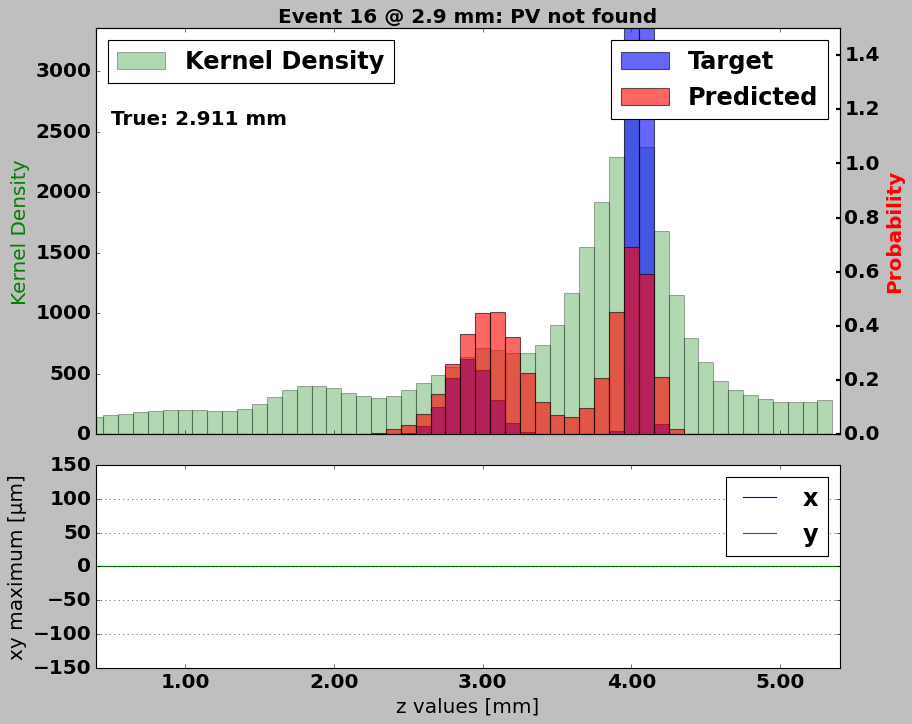


Event 16.5:


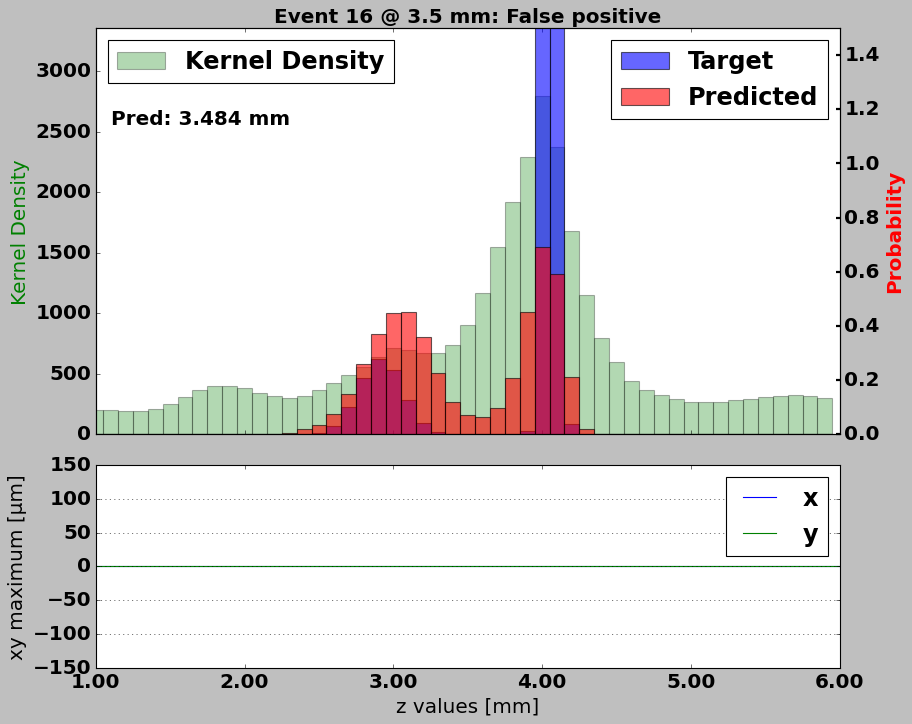


Event 16.6:


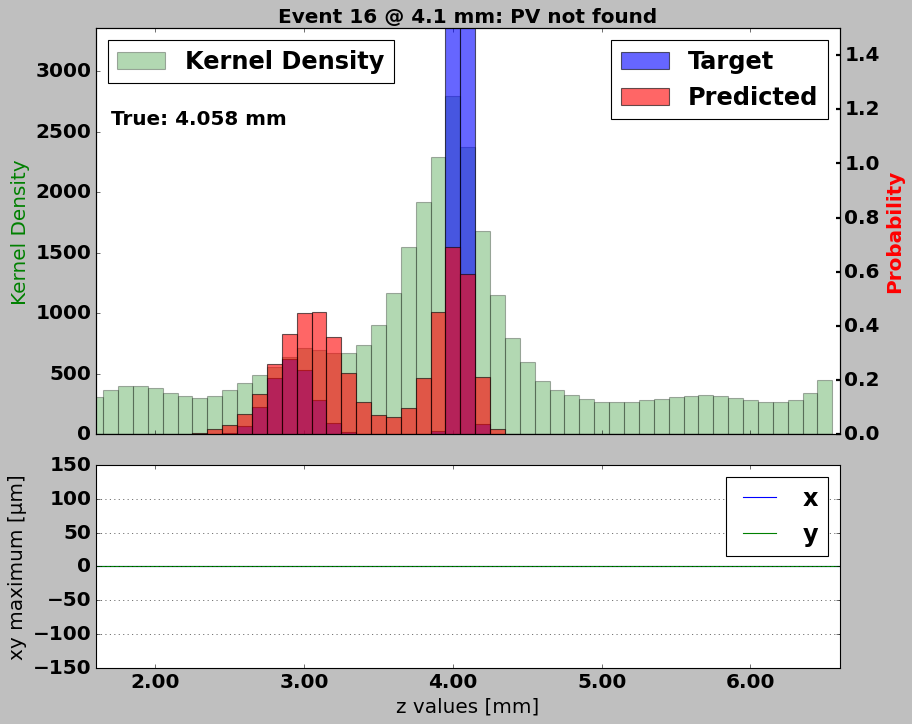


Event 16.7:


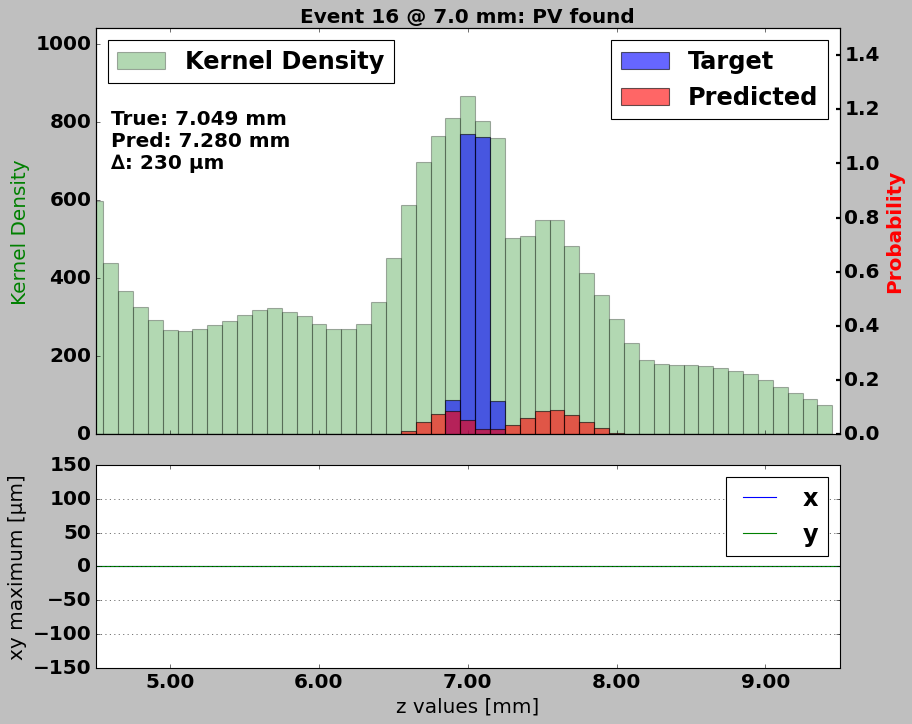


Event 16.8:


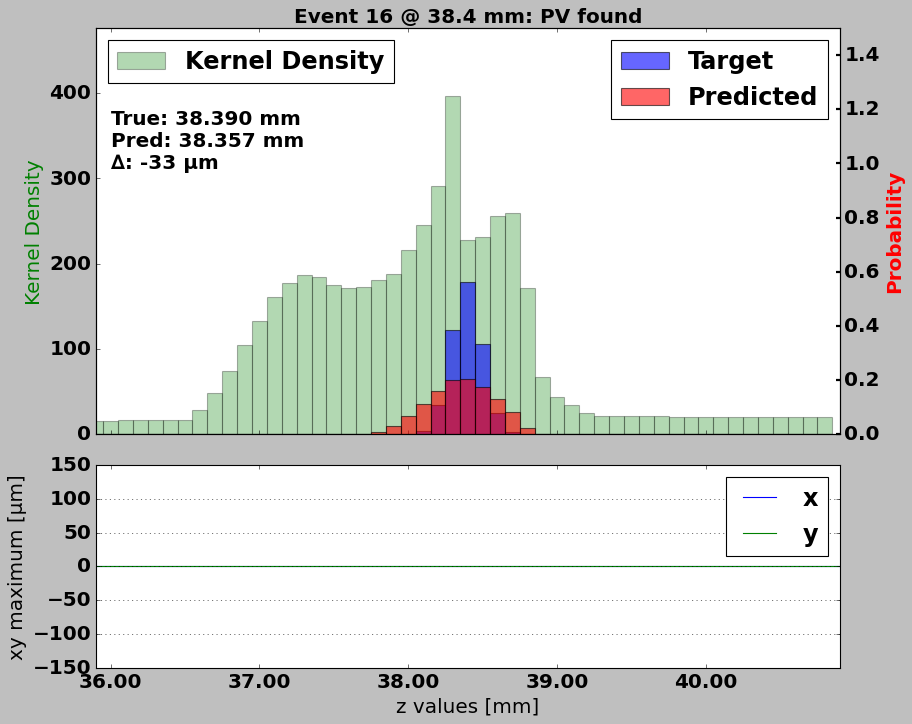


Event 17: Found 6 of 7, added 0 (eff 85.71%)


ValueError: max() arg is an empty sequence

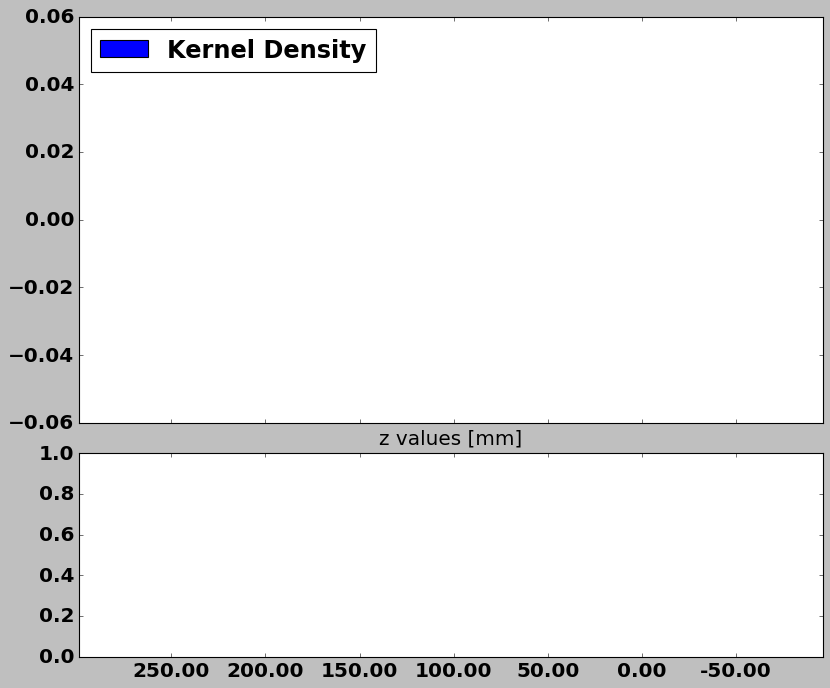

In [17]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)


inputs = validation.dataset.tensors[0].cpu().numpy()[:,0,:]
##print(' = ',inputs)
zvals = np.linspace(-100, 300, 4000, endpoint=False) + 0.05
finalmsg = ''
internal_count = 0
output_filename = None # Or set: '120000_3layer_{number:02}.pdf'

for event in range(100):
    input = inputs[event]
    label = labels[event]
    output = outputs[event]
    
##    print('input from inputs = ',input)
    
    # Consistent parameters for the calls below
    parameters = {
        "threshold": 1e-2,
        "integral_threshold": .2,
        "min_width": 3
    }
    
    # Compute the "actual" efficenies and things
    ftruth = pv_locations(label, **parameters)
    fcomputed = pv_locations(output, **parameters)
    results = efficiency(label, output, difference=5.0, **parameters)
    
    # Add a line to the final results string (print at end)
    finalmsg += f"Event {event}: {results}\n"
    
    # Make sure bin numbers are integers
    truth = np.around(ftruth).astype(np.int32)
    computed = np.around(fcomputed).astype(np.int32)
    
    # Join arrays and remove any points closer than 5 bins
    # We plot over these "points of interest"
    poi = np.sort(np.concatenate([truth, computed]))
    poi = poi[np.concatenate([[True], np.fabs(np.diff(poi)) > 5])]
    
    print(f"\nEvent {event}:", results)
    
    for index, i in enumerate(poi):
        # Convert to location in z
        center = (i / 10) - 100
        
        # Collect items less than 5 apart as "true"
        b_truth = np.fabs(ftruth - i) <= 5
        b_comp = np.fabs(fcomputed - i) <= 5
        in_truth = np.any(b_truth)
        in_comp = np.any(b_comp)
        
        if in_truth and in_comp:
            msg = 'PV found'
        elif in_truth:
            msg = 'PV not found'
        elif False:
            pass # Check for NaNs
        else:
            msg = 'False positive'
            
        with plt.style.context({
            'font.size':18,
            'font.weight':'bold'}):
        
            fig, axs = plt.subplots(2, figsize=(12,10), sharex=True,
                                    gridspec_kw={'height_ratios':[2,1],
                                                'hspace':0.1})
        
            # ax1 is the axis that is tied to left (density)
            # ax2 is the axis that is tied to the right (probability)
            ax1, ax2 = plot_ruiplot(zvals, i, input, label, output, ax=axs[0])
            ax1.set_title(f"Event {event} @ {center:.1f} mm: {msg}",
                          fontdict={'size':18, 'weight':'bold'})


            msg = ""
            
            truth_centroid = (ftruth[b_truth] / 10) - 100
            for value in truth_centroid:
                msg += f"True: {value:.3f} mm\n"
                
            comp_centroid = (fcomputed[b_comp] / 10) - 100
            for value in comp_centroid:
                msg += f"Pred: {value:.3f} mm\n"
                
            if len(truth_centroid) == 1 and len(comp_centroid) == 1:
                diff = (comp_centroid[0] - truth_centroid[0]) * 1_000
                msg += f"∆: {diff:.0f} µm\n"
            
            ax1.text(.02, .8, msg,
                     transform=ax1.transAxes,
                     verticalalignment='top')
            
            print(f"\nEvent {event}.{index}:")
            
            # Plot and print PVs
            ax2.scatter(PV.z[event], np.ones_like(PV.z[event])*.4, s=50, color='C0')
            for x,y,z,n,cat in zip(PV.x[event], PV.y[event], PV.z[event], PV.n[event], PV.cat[event]):
                # Only print out if z in plotting range
                if center - 2.5 < z < center + 2.5:
                    print()
                    print(f'PV: {n} tracks (type {cat})')
                    print(f'  x: {x*1000:5.0f} μm')
                    print(f'  y: {y*1000:5.0f} μm')
                    print(f'  z: {z:8.3f} mm')
                    

            # Plot and print SVs
            ax2.scatter(SV.z[event], np.ones_like(SV.z[event])*.6, s=50, color='C1')
            for x,y,z,n,cat in zip(SV.x[event], SV.y[event], SV.z[event], SV.n[event], SV.cat[event]):
                # Only print out if z in plotting range
                if center - 2.5 < z < center + 2.5:
                    print()
                    print(f'SV: {n} tracks (type {cat})')
                    print(f'  x: {x*1000:5.0f} μm')
                    print(f'  y: {y*1000:5.0f} μm')
                    print(f'  z: {z:8.3f} mm')
            
            ax = axs[1]
            ax.plot((np.arange(4000) / 10) - 100, xmax[event]*1000000, label="x")
            ax.plot((np.arange(4000) / 10) - 100, ymax[event]*1000000, label="y")
            ax.set_xlim(ax1.get_xlim())
            ax.set_ylim(-150,150)
            ax.grid(axis='y')
            ax.set_ylabel('xy maximum [μm]')
            ax.legend(loc='best')
            
            ax.set_xlabel(ax1.get_xlabel())
            ax1.set_xlabel("")
            
            # Save and show
            if output_filename:        
                plt.savefig(output_filename.format(number=internal_count))
            plt.show()
            
            internal_count += 1
            
print(finalmsg)

In [ ]:
quit()